# **Use case ML: price prediction of used bikes**

**Table of contents**<a id='toc0_'></a>    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## *Data Preprocessing*

In [1]:
########### Loading in Libs ###########

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve, KFold
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor

########### Style for Plots  ###########

plt.style.use('ggplot')

np.int = np.int_ #fix needed for the py version i used

In [2]:
########### reading in the dataframes ###########
df_BMW_raw = pd.read_csv("BMW_bike.csv", delimiter = ",", usecols=[0, 1, 2, 3], dtype={"mileage":"string", "price":"string", "Bike":"string", "Types and Used Time": "string"})
df_ducatti_raw = pd.read_csv("ducatti_bike.csv", delimiter = ",", usecols=[0, 1, 2, 3])
df_KTM_raw = pd.read_csv("KTM_bike.csv", delimiter = ",", usecols=[0, 1, 2, 3])
df_Royal_Enfield_raw = pd.read_csv("Royal_Enfield_Standard_bike.csv", delimiter = ",", usecols=[0, 1, 2, 3])
df_Suzuki_raw = pd.read_csv("Suzuki_bike.csv", delimiter = ",",usecols=[0, 1, 2, 3])
df_Yamaha_raw = pd.read_csv("Yamaha_bike.csv", delimiter = ",",usecols=[0, 1, 2, 3])
df_bikez =  pd.read_csv("all_bikez_curated.csv", delimiter = ",", dtype={"Brand":"string", "Model":"string", "Year":int, "Category":"string", "Rating":float, "Displacement (ccm)":float, "Power (hp)":float, "Torque(Nm)":float, "Engine cylinder":"string", "Engine stroke":"string",'Gearbox':"string", 'Bore (mm)':float, 'Stroke (mm)':"string", 'Fuel capacity (lts)':float,
       'Fuel system':"string", 'Fuel control':"string", 'Cooling system':"string", 'Transmission type':"string",
       'Dry weight (kg)':float, 'Wheelbase (mm)':float, 'Seat height (mm)':float, 'Front brakes':"string",
       'Rear brakes':"string", 'Front tire':"string", 'Rear tire':"string", 'Front suspension':"string",
       'Rear suspension':"string", 'Color options':"string"})

########### Dropping nans for mileage and formatting bike column to lower case ###########
df_BMW_raw = df_BMW_raw.dropna(subset=["mileage"])
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.lower()

df_ducatti_raw = df_ducatti_raw.dropna(subset=["mileage"])
df_ducatti_raw = df_ducatti_raw.rename(columns={"Bike name": "Bike", "Time of USed": "Types and Used Time"})
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.lower()

df_KTM_raw = df_KTM_raw.dropna(subset=["mileage"])
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.lower()

df_Royal_Enfield_raw = df_Royal_Enfield_raw.dropna(subset=["mileage"])
df_Royal_Enfield_raw = df_Royal_Enfield_raw.rename(columns={"bike": "Bike", "Types": "Types and Used Time"})
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.lower()

df_Suzuki_raw = df_Suzuki_raw.dropna(subset=["mileage"])
df_Suzuki_raw = df_Suzuki_raw.rename(columns={"BIke name": "Bike"})
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.lower()

df_Yamaha_raw = df_Yamaha_raw.dropna(subset=["mileage"])
df_Yamaha_raw = df_Yamaha_raw.rename(columns={"Bike name": "Bike", "Types and Used  Time": "Types and Used Time"})
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.lower()

########### Rename models column to Bike column and reformat ###########
df_bikez = df_bikez.rename(columns={"Model": "Bike"})
df_bikez["Bike"] = df_bikez["Bike"].str.lower()

In [4]:
########### Creating dataframes for the model specifications for the different brands for performance and overview reasons ###########

df_bikez_bmw = df_bikez[df_bikez["Brand"] == "bmw"]
df_bikez_royal_enfield = df_bikez[df_bikez["Brand"] == "enfield"]
df_bikez_ducatti = df_bikez[df_bikez["Brand"] == "ducati"]
df_bikez_ktm = df_bikez[df_bikez["Brand"] == "ktm"]
df_bikez_suzuki = df_bikez[df_bikez["Brand"] == "suzuki"]
df_bikez_yamaha = df_bikez[df_bikez["Brand"] == "yamaha"]

### BMW:

In [5]:
########### Extract Year ###########

df_BMW_raw["Year"] = df_BMW_raw["Types and Used Time"].str.split('BMW').str[0]
df_BMW_raw["Year"] = df_BMW_raw["Year"].replace("New", "", regex=True).astype(int)

########### Reformat ###########

df_BMW_raw["Bike"] = df_BMW_raw["Bike"].replace(" ", "", regex=True)
df_bikez_bmw["Bike"] = df_bikez_bmw["Bike"].replace(" ", "", regex=True)

########### Adjust model names to fit the names from the model specifications dataframe ###########

df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.split('first').str[0]
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].replace("[/]", "", regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].replace("r1100sboxercup", "r1100sboxercupreplica", regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].replace("r1250", "r1250gs", regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].replace("r1100rtabs", "r1100rt", regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].replace("r807", "r80", regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1250gs.*$)', 'r1250gs', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*s1000xr.*$)', 's1000xr', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*g310.*$)', 'g310r', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*k1600b.*$)', 'k1600b', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1250.*$)', 'r1250gs', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r18.*$)', 'r18', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*s1000r.*$)', 's1000r', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f900r.*$)', 'f900r', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f900xr.*$)', 'f900xr', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1200rt.*$)', 'r1200rt', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*ce04.*$)', 'ce04', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1200gsadventure.*$)', 'r1200gsadventure', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f850gsadventure.*$)', 'f850gsadventure', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f800gt.*$)', 'f800gt', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f800gs.*$)', 'f800gs', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*s1000.*$)', 's1000rr', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1250rt.*$)', 'r1250rt', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*m1000r.*$)', 'm1000rr', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f750.*$)', 'f750gs', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*f850gs.*$)', 'f850gs', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*k1600.*$)', 'k1600b', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1000.*$)', 'm1000rr', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1200.*$)', 'r1200avantgarde', regex=True)
df_BMW_raw["Bike"] = df_BMW_raw["Bike"].str.replace(r'(^.*r1200gs.*$)', 'r1200gs', regex=True)

/tmp/ipykernel_1106/2619773030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikez_bmw["Bike"] = df_bikez_bmw["Bike"].replace(" ", "", regex=True)


In [6]:
########### Merge according to Bike and Year ###########

df_BMW = pd.merge(df_BMW_raw, df_bikez_bmw, how = "left",  on = ["Bike", "Year"])

########### Drop the with that created duplicates ###########

df_BMW = df_BMW.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

########### Merge on bike model for the cases for which there is no corresponding Year ###########

df_merged_temp = pd.merge(df_BMW_raw, df_bikez_bmw, how = "left",  on = ["Bike"])
df_merged_temp = df_merged_temp.drop_duplicates(subset = ["Bike"], keep = "first") #jedes Modell ein uniquer Index
df_merged_temp.reset_index(inplace=True, drop=True)
df_BMW.reset_index(inplace=True, drop=True)

########### Fill NaNs for the same model ###########

df_BMW["Category"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
df_BMW["Displacement (ccm)"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Displacement (ccm)']), inplace=True) 
df_BMW["Power (hp)"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Power (hp)']), inplace=True) 
df_BMW["Torque (Nm)"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Torque (Nm)']), inplace=True) 
df_BMW["Engine stroke"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Engine stroke']), inplace=True) 
df_BMW["Brand"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Brand']), inplace=True) 

########### Drop entries for which the Category is empty ###########

df_BMW = df_BMW.dropna(subset=["Category"])

########### Drop unused columns ###########

df_BMW = df_BMW.drop(columns = ['Rating', 'Wheelbase (mm)', 'Seat height (mm)', 'Front brakes', 'Gearbox', 'Bore (mm)', 
       'Stroke (mm)','Fuel capacity (lts)', 'Fuel system','Fuel control', 'Cooling system', 'Transmission type' ,'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'Color options', 'Dry weight (kg)'])

########### Drop duplicates again? This kinda grew historically throughout the programming. It had a reason at some point I think :) ###########

df_BMW = df_BMW.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

########### Fill NaNs for which some entries are empty and there is no corresponding model with values ###########

df_BMW["Displacement (ccm)"].fillna(value=df_BMW.groupby('Category')["Displacement (ccm)"].mean(), inplace=True) 
df_BMW["Displacement (ccm)"].fillna(value=df_BMW["Displacement (ccm)"].mean(), inplace=True) 

df_BMW["Power (hp)"].fillna(value=df_BMW.groupby('Category')["Power (hp)"].mean(), inplace=True) 
df_BMW["Power (hp)"].fillna(value=df_BMW["Power (hp)"].mean(), inplace=True) 

df_BMW["Torque (Nm)"].fillna(value=df_BMW.groupby('Category')["Torque (Nm)"].mean(), inplace=True) 
df_BMW["Torque (Nm)"].fillna(value=df_BMW["Torque (Nm)"].mean(), inplace=True) 

########### Reformat mileage and price + drop entries for which there is no price ###########

df_BMW["mileage"] = df_BMW["mileage"].replace("[miles,]", "", regex=True).astype(int)
df_BMW = df_BMW.loc[df_BMW["price"]!= "No Price Listed"]
df_BMW["price"] = df_BMW["price"].replace("[$,]", "", regex=True).astype(int)


/tmp/ipykernel_1106/3799189007.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_BMW["Category"].fillna(df_BMW['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
/tmp/ipykernel_1106/3799189007.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

$\textbf{BMW CLEANING DONE}$

### Royal Enfield:

In [7]:
df_Royal_Enfield_raw["Year"] = df_Royal_Enfield_raw["Types and Used Time"].str.split('Royal').str[0]
df_Royal_Enfield_raw["Year"] = df_Royal_Enfield_raw["Year"].replace("New", "", regex=True)
df_Royal_Enfield_raw["Year"] = df_Royal_Enfield_raw["Year"].replace("Used", "", regex=True).astype(int)

df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].replace(" ", "", regex=True)
df_bikez_royal_enfield["Bike"] = df_bikez_royal_enfield["Bike"].replace(" ", "", regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*himalayan.*$)', 'himalayan', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*continentalgt.*$)', 'continentalgt', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*classic350.*$)', 'classic350', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*int650.*$)', 'interceptor650', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*meteor350.*$)', 'meteor350', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*classic500.*$)', 'classic500', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*metro350.*$)', 'meteor350', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*contienetalgt650.*$)', 'continentalgt650', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*meteor.*$)', 'meteor350', regex=True)
df_Royal_Enfield_raw["Bike"] = df_Royal_Enfield_raw["Bike"].str.replace(r'(^.*interceptor650.*$)', 'interceptor650', regex=True)

/tmp/ipykernel_1106/746029178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikez_royal_enfield["Bike"] = df_bikez_royal_enfield["Bike"].replace(" ", "", regex=True)


In [8]:
df_Royal_Enfield = pd.merge(df_Royal_Enfield_raw, df_bikez_royal_enfield, how = "left",  on = ["Bike", "Year"])
df_Royal_Enfield = df_Royal_Enfield.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

df_merged_temp = pd.merge(df_Royal_Enfield_raw, df_bikez_royal_enfield, how = "left",  on = ["Bike"])
df_merged_temp = df_merged_temp.drop_duplicates(subset = ["Bike"], keep = "first") #jedes Modell ein uniquer Index
df_merged_temp.reset_index(inplace=True, drop=True)
df_Royal_Enfield.reset_index(inplace=True, drop=True)

df_Royal_Enfield["Category"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
df_Royal_Enfield["Displacement (ccm)"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Displacement (ccm)']), inplace=True) 
df_Royal_Enfield["Power (hp)"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Power (hp)']), inplace=True) 
df_Royal_Enfield["Torque (Nm)"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Torque (Nm)']), inplace=True) 
df_Royal_Enfield["Engine stroke"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Engine stroke']), inplace=True) 
#df_Royal_Enfield["Dry weight (kg)"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Dry weight (kg)']), inplace=True) 
df_Royal_Enfield["Brand"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Brand']), inplace=True) 

df_Royal_Enfield = df_Royal_Enfield.dropna(subset=["Category"])

df_Royal_Enfield = df_Royal_Enfield.drop(columns = ['Rating', 'Wheelbase (mm)', 'Seat height (mm)', 'Front brakes', 'Gearbox', 'Bore (mm)', 
       'Stroke (mm)','Fuel capacity (lts)', 'Fuel system','Fuel control', 'Cooling system', 'Transmission type' ,'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'Color options', 'Dry weight (kg)'])

#df_Royal_Enfield["Dry weight (kg)"].fillna(value=df_BMW.groupby(['Category'])['Dry weight (kg)'].mean(), inplace=True)
#df_Royal_Enfield["Dry weight (kg)"].fillna(value=df_BMW['Dry weight (kg)'].mean(), inplace=True)

df_Royal_Enfield["Displacement (ccm)"].fillna(value=df_Royal_Enfield.groupby('Category')["Displacement (ccm)"].mean(), inplace=True) 
df_Royal_Enfield["Displacement (ccm)"].fillna(value=df_Royal_Enfield["Displacement (ccm)"].mean(), inplace=True) 

df_Royal_Enfield["Power (hp)"].fillna(value=df_Royal_Enfield.groupby('Category')["Power (hp)"].mean(), inplace=True) 
df_Royal_Enfield["Power (hp)"].fillna(value=df_Royal_Enfield["Power (hp)"].mean(), inplace=True) 

df_Royal_Enfield["Torque (Nm)"].fillna(value=df_Royal_Enfield.groupby('Category')["Torque (Nm)"].mean(), inplace=True) 
df_Royal_Enfield["Torque (Nm)"].fillna(value=df_Royal_Enfield["Torque (Nm)"].mean(), inplace=True) 

df_Royal_Enfield["mileage"] = df_Royal_Enfield["mileage"].replace("[miles,]", "", regex=True).astype(int)
df_Royal_Enfield = df_Royal_Enfield.loc[df_Royal_Enfield["price"]!= "No Price Listed"]
df_Royal_Enfield["price"] = df_Royal_Enfield["price"].replace("[$,]", "", regex=True).astype(int)
df_Royal_Enfield

/tmp/ipykernel_1106/1737067518.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_Royal_Enfield["Category"].fillna(df_Royal_Enfield['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
/tmp/ipykernel_1106/1737067518.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

mileage  price            Bike  \
0          1   5299       himalayan   
1       1256   4500     bullet500b5   
2          5   6349   continentalgt   
3          3   6349   continentalgt   
4          1   4499      classic350   
..       ...    ...             ...   
338     5717   4700       meteor350   
339     1056   3980       meteor350   
340     1162   4495  interceptor650   
341        6   5449       himalayan   
342        1   5550       himalayan   

                           Types and Used Time  Year    Brand  \
0              New 2022 Royal Enfield Standard  2022  enfield   
1    Used 2009 Royal Enfield Classic / Vintage  2009  enfield   
2               New 2023 Royal Enfield Cruiser  2023  enfield   
3               New 2023 Royal Enfield Cruiser  2023  enfield   
4              New 2022 Royal Enfield Standard  2022  enfield   
..                                         ...   ...      ...   
338            Used 2021 Royal Enfield Cruiser  2021  enfield   
339            Used 2021 Royal Enfield Cruiser  2021  enfield   
340           Used 2019 Royal Enfield Standard  2019  enfield   
341            New 2023 Royal Enfield Standard  2023  enfield   
342            New 2023 Royal Enfield Standard  2023  enfield   

             Category  Displacement (ccm)  Power (hp)  Torque (Nm)  \
0    Enduro / offroad               411.0   24.500000         32.0   
1             Classic               499.0   30.218505         40.9   
2            Allround               535.0   29.100000         41.3   
3            Allround               535.0   29.100000         41.3   
4             Classic               349.3   19.700000         27.0   
..                ...                 ...         ...          ...   
338           Classic               349.0   19.900000         27.0   
339           Classic               349.0   19.900000         27.0   
340          Allround               648.0   47.000000         52.0   
341  Enduro / offroad               411.0   24.500000         32.0   
342  Enduro / offroad               411.0   24.500000         32.0   

     Engine cylinder Engine stroke  
0    Single cylinder   four-stroke  
1               <NA>   four-stroke  
2               <NA>   four-stroke  
3               <NA>   four-stroke  
4    Single cylinder   four-stroke  
..               ...           ...  
338             <NA>   four-stroke  
339             <NA>   four-stroke  
340             Twin   four-stroke  
341             <NA>   four-stroke  
342             <NA>   four-stroke  

[283 rows x 12 columns]

$\textbf{ROYAL ENFIELD CLEANING DONE}$

### Ducati:

In [9]:
df_ducatti_raw["Year"] = df_ducatti_raw["Types and Used Time"].str.split('Ducati').str[0]
df_ducatti_raw["Year"] = df_ducatti_raw["Year"].replace("New", "", regex=True)
df_ducatti_raw["Year"] = df_ducatti_raw["Year"].replace("Used", "", regex=True).astype(int)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].replace(" ", "", regex=True)
df_bikez_ducatti["Bike"] = df_bikez_ducatti["Bike"].replace(" ", "", regex=True)

df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*superleggera1299.*$)', 'superleggera1299', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*1199panigale.*$)', '1199panigale', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*937.*$)', 'monster797plus', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*panigalev4sp.*$)', 'panigalev4sp', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*monster821.*$)', 'monster821', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*959panigale.*$)', '959panigale', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].replace("superbikepanigalev4", "panigalev4", regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*multistradav4.*$)', 'multistradav4', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*diavel.*$)', 'diavel1260', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*multistrada1260.*$)', 'multistrada1260', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*base.*$)', 'monsterplus', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*panigale899.*$)', 'panigale959', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*panigalev2.*$)', 'panigalev2', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*superleggera.*$)', 'superleggerav4', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*monster1200.*$)', 'monster1200', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*scrambler800.*$)', 'scramblercaferacer', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*streetfighterv4s.*$)', 'streetfighterv4s', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*1299panigale.*$)', '1299panigale', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*supersport9.*$)', 'supersport950', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*monster+.*$)', 'monsterplus', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*panigale1199.*$)', '1199panigale', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*panigale1299.*$)', '1199panigale', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*multistrada1200.*$)', 'multistrada1200enduro', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*multistrada950.*$)', 'multistrada950', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*899panigale.*$)', '899panigale', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*streetfighterv4d.*$)', 'streetfighterv4', regex=True)
df_ducatti_raw["Bike"] = df_ducatti_raw["Bike"].str.replace(r'(^.*panigalev4s.*$)', 'panigalev4s', regex=True)


/tmp/ipykernel_1106/1497480933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikez_ducatti["Bike"] = df_bikez_ducatti["Bike"].replace(" ", "", regex=True)


In [10]:
df_ducati = pd.merge(df_ducatti_raw, df_bikez_ducatti, how = "left",  on = ["Bike", "Year"])
df_ducati = df_ducati.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

df_merged_temp = pd.merge(df_ducatti_raw, df_bikez_ducatti, how = "left",  on = ["Bike"])
df_merged_temp = df_merged_temp.drop_duplicates(subset = ["Bike"], keep = "first") #jedes Modell ein uniquer Index
df_merged_temp.reset_index(inplace=True, drop=True)
df_ducati.reset_index(inplace=True, drop=True)

df_ducati["Category"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
df_ducati["Displacement (ccm)"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Displacement (ccm)']), inplace=True) 
df_ducati["Power (hp)"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Power (hp)']), inplace=True) 
df_ducati["Torque (Nm)"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Torque (Nm)']), inplace=True) 
df_ducati["Engine stroke"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Engine stroke']), inplace=True) 
#df_ducati["Dry weight (kg)"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Dry weight (kg)']), inplace=True) 
df_ducati["Brand"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Brand']), inplace=True) 

df_ducati = df_ducati.dropna(subset=["Category"])

df_ducati = df_ducati.drop(columns = ['Rating', 'Wheelbase (mm)', 'Seat height (mm)', 'Front brakes', 'Gearbox', 'Bore (mm)', 
       'Stroke (mm)','Fuel capacity (lts)', 'Fuel system','Fuel control', 'Cooling system', 'Transmission type' ,'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'Color options', 'Dry weight (kg)'])

#df_ducati["Dry weight (kg)"].fillna(value=df_ducati.groupby(['Category'])['Dry weight (kg)'].mean(), inplace=True)
#df_ducati["Dry weight (kg)"].fillna(value=df_ducati['Dry weight (kg)'].mean(), inplace=True)

df_ducati["Displacement (ccm)"].fillna(value=df_ducati.groupby('Category')["Displacement (ccm)"].mean(), inplace=True) 
df_ducati["Displacement (ccm)"].fillna(value=df_ducati["Displacement (ccm)"].mean(), inplace=True) 

df_ducati["Power (hp)"].fillna(value=df_ducati.groupby('Category')["Power (hp)"].mean(), inplace=True) 
df_ducati["Power (hp)"].fillna(value=df_ducati["Power (hp)"].mean(), inplace=True) 

df_ducati["Torque (Nm)"].fillna(value=df_ducati.groupby('Category')["Torque (Nm)"].mean(), inplace=True) 
df_ducati["Torque (Nm)"].fillna(value=df_ducati["Torque (Nm)"].mean(), inplace=True) 

df_ducati["mileage"] = df_ducati["mileage"].replace("[miles,]", "", regex=True).astype(int)
df_ducati = df_ducati.loc[df_ducati["price"]!= "No Price Listed"]
df_ducati["price"] = df_ducati["price"].replace("[$,]", "", regex=True).astype(int)
df_ducati

/tmp/ipykernel_1106/1127063342.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ducati["Category"].fillna(df_ducati['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
/tmp/ipykernel_1106/1127063342.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

mileage  price                   Bike          Types and Used Time  Year  \
0       1050  49995         superleggerav4        2014 Ducati Sportbike  2014   
1       6308  11795            monsterplus        2021 Ducati Dirt Bike  2021   
2       2400   9495          scrambler1100        2018 Ducati Sportbike  2018   
3      11200   5500                    st2    1999 Ducati Sport Touring  1999   
4       1300  34900       streetfighterv4s        2022 Ducati Sportbike  2022   
..       ...    ...                    ...                          ...   ...   
578     2049  10499     scramblercaferacer         2018 Ducati Standard  2018   
579    20632  14495  multistrada1200enduro    2016 Ducati Sport Touring  2016   
580    10850  11999             diavel1260        2015 Ducati Sportbike  2015   
581    12000  10750          hypermotardsp       2015 Ducati Super Moto  2015   
582      302  13999  multistrada1200enduro    2014 Ducati Sport Touring  2014   

      Brand          Category  Displacement (ccm)  Power (hp)  Torque (Nm)  \
0    ducati        Naked bike               998.0       221.0        116.0   
1    ducati        Naked bike               937.0       111.0         93.0   
2    ducati           Classic              1079.0        84.5         88.0   
3    ducati     Sport touring               944.0        83.0         83.0   
4    ducati        Naked bike              1103.0       208.0        123.0   
..      ...               ...                 ...         ...          ...   
578  ducati           Classic               803.0        73.0         68.0   
579  ducati  Enduro / offroad              1198.4       160.0        136.0   
580  ducati          Allround              1262.0       155.0        129.0   
581  ducati      Super motard               821.1       110.0         89.0   
582  ducati  Enduro / offroad              1198.4       160.0        136.0   

    Engine cylinder Engine stroke  
0              <NA>   four-stroke  
1                V2   four-stroke  
2                V2   four-stroke  
3                V2   four-stroke  
4              <NA>   four-stroke  
..              ...           ...  
578              V2   four-stroke  
579              V2   four-stroke  
580            <NA>   four-stroke  
581              V2   four-stroke  
582            <NA>   four-stroke  

[525 rows x 12 columns]

$\textbf{DUCATTI CLEANING DONE}$

### KTM:

In [11]:
df_KTM_raw["Year"] = df_KTM_raw["Types and Used Time"].str.split('KTM').str[0]
df_KTM_raw["Year"] = df_KTM_raw["Year"].replace("New", "", regex=True)
df_KTM_raw["Year"] = df_KTM_raw["Year"].replace("Used", "", regex=True).astype(int)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].replace(" ", "", regex=True)
df_bikez_ktm["Bike"] = df_bikez_ktm["Bike"].replace(" ", "", regex=True)

df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*smc690r.*$)', '690smcr', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*690smcr.*$)', '690smcr', regex=True)

df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*superduke1290r.*$)', '1290superduker', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*1290superduke.*$)', '1290superduker', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*superduke990.*$)', '990superduke', regex=True)

df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*duke390abs.*$)', '390duke', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*adventure1190.*$)', '1090adventure', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*adventure1290.*$)', '1290superadventurer', regex=True)
#df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*adventure1290.*$)', '1290adventure', regex=True)

df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*adventure890.*$)', '890adventure', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*890adventure.*$)', '890adventure', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*790adventure.*$)', '790adventure', regex=True)

df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*890duke.*$)', '890duke', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*rc390.*$)', 'rc390', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*690duke.*$)', '690duke', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*duke690.*$)', '690duke', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*500exc-f.*$)', '500exc-f', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*450xc.*$)', '450exc-f', regex=True)
df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*350xc.*$)', '350exc-f', regex=True)

df_KTM_raw["Bike"] = df_KTM_raw["Bike"].str.replace(r'(^.*smc690r.*$)', '690smcr', regex=True)

/tmp/ipykernel_1106/1294204431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikez_ktm["Bike"] = df_bikez_ktm["Bike"].replace(" ", "", regex=True)


In [12]:
df_ktm = pd.merge(df_KTM_raw, df_bikez_ktm, how = "left",  on = ["Bike", "Year"])
df_ktm = df_ktm.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

df_merged_temp = pd.merge(df_KTM_raw, df_bikez_ktm, how = "left",  on = ["Bike"])
df_merged_temp = df_merged_temp.drop_duplicates(subset = ["Bike"], keep = "first") #jedes Modell ein uniquer Index
df_merged_temp.reset_index(inplace=True, drop=True)
df_ktm.reset_index(inplace=True, drop=True)

df_ktm["Category"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
df_ktm["Displacement (ccm)"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Displacement (ccm)']), inplace=True) 
df_ktm["Power (hp)"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Power (hp)']), inplace=True) 
df_ktm["Torque (Nm)"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Torque (Nm)']), inplace=True) 
df_ktm["Engine stroke"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Engine stroke']), inplace=True) 
#df_ktm["Dry weight (kg)"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Dry weight (kg)']), inplace=True) 
df_ktm["Brand"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Brand']), inplace=True) 

df_ktm = df_ktm.dropna(subset=["Category"])

df_ktm = df_ktm.drop(columns = ['Rating', 'Wheelbase (mm)', 'Seat height (mm)', 'Front brakes', 'Gearbox', 'Bore (mm)', 
       'Stroke (mm)','Fuel capacity (lts)', 'Fuel system','Fuel control', 'Cooling system', 'Transmission type' ,'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'Color options', 'Dry weight (kg)'])

#df_ktm["Dry weight (kg)"].fillna(value=df_ktm.groupby(['Category'])['Dry weight (kg)'].mean(), inplace=True)
#df_ktm["Dry weight (kg)"].fillna(value=df_ktm['Dry weight (kg)'].mean(), inplace=True)

df_ktm["Displacement (ccm)"].fillna(value=df_ktm.groupby('Category')["Displacement (ccm)"].mean(), inplace=True) 
df_ktm["Displacement (ccm)"].fillna(value=df_ktm["Displacement (ccm)"].mean(), inplace=True) 

df_ktm["Power (hp)"].fillna(value=df_ktm.groupby('Category')["Power (hp)"].mean(), inplace=True) 
df_ktm["Power (hp)"].fillna(value=df_ktm["Power (hp)"].mean(), inplace=True) 

df_ktm["Torque (Nm)"].fillna(value=df_ktm.groupby('Category')["Torque (Nm)"].mean(), inplace=True) 
df_ktm["Torque (Nm)"].fillna(value=df_ktm["Torque (Nm)"].mean(), inplace=True) 

df_ktm["mileage"] = df_ktm["mileage"].replace("[miles,]", "", regex=True).astype(int)
df_ktm = df_ktm.loc[df_ktm["price"]!= "No Price Listed"]
df_ktm["price"] = df_ktm["price"].replace("[$,]", "", regex=True).astype(int)
df_ktm

/tmp/ipykernel_1106/1960192824.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ktm["Category"].fillna(df_ktm['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
/tmp/ipykernel_1106/1960192824.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

mileage  price            Bike       Types and Used Time  Year Brand  \
0      10336  14994  1290superduker    2019 KTM Sport Touring  2019   ktm   
1       5796  10999         690smcr       2019 KTM Super Moto  2019   ktm   
2        485   9500        350exc-f       2018 KTM Dual Sport  2018   ktm   
3         57   7995        350exc-f       2020 KTM Dual Sport  2020   ktm   
5         35   9586         790duke         2019 KTM Standard  2019   ktm   
..       ...    ...             ...                       ...   ...   ...   
583    26756   9999  1190adventurer       2014 KTM Dual Sport  2014   ktm   
584    11815   5999      690absduke        2014 KTM Sportbike  2014   ktm   
585    13568  10999   1190adventure       2014 KTM Dual Sport  2014   ktm   
586    10995   4499         690duke        2014 KTM Sportbike  2014   ktm   
587        3   9199         790duke    New 2023 KTM Sportbike  2023   ktm   

             Category  Displacement (ccm)  Power (hp)  Torque (Nm)  \
0          Naked bike              1301.0  177.000000    87.525114   
1        Super motard               690.0   67.000000    64.000000   
2    Enduro / offroad               349.7  109.491579    87.525114   
3    Enduro / offroad               349.7  109.491579    87.525114   
5          Naked bike               799.0  105.000000    87.525114   
..                ...                 ...         ...          ...   
583          Allround              1195.0  147.000000    87.525114   
584        Naked bike               690.0   67.100000    87.525114   
585          Allround              1195.0  147.000000    87.525114   
586        Naked bike               654.0   64.400000    67.000000   
587        Naked bike               790.0  105.000000    87.525114   

     Engine cylinder Engine stroke  
0                 V2   four-stroke  
1    Single cylinder   four-stroke  
2    Single cylinder   four-stroke  
3    Single cylinder   four-stroke  
5               Twin   four-stroke  
..               ...           ...  
583             Twin   four-stroke  
584  Single cylinder   four-stroke  
585             Twin   four-stroke  
586             <NA>   four-stroke  
587             <NA>   four-stroke  

[545 rows x 12 columns]

$\textbf{KTM CLEANING DONE}$

### Suzuki:

In [13]:
df_Suzuki_raw["Year"] = df_Suzuki_raw["Types and Used Time"].str.split('Suzuki').str[0]
df_Suzuki_raw["Year"] = df_Suzuki_raw["Year"].replace("New", "", regex=True)
df_Suzuki_raw["Year"] = df_Suzuki_raw["Year"].replace("Used", "", regex=True).astype(int)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].replace(" ", "", regex=True)
df_bikez_suzuki["Bike"] = df_bikez_suzuki["Bike"].replace(" ", "", regex=True)

df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*hayabusa.*$)', 'hayabusa', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-r1300.*$)', 'hayabusa', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-1300r.*$)', 'hayabusa', regex=True)

df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx1300.*$)', 'hayabusa', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-1000.*$)', 'gsx-r1000', regex=True)

df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*m109rb.*$)', 'boulevardm109rboss', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*boulevard.*$)', 'boulevardc50t', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsxr1000.*$)', 'gsx-r1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-r1000.*$)', 'gsx-r1000', regex=True)

df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-r750.*$)', 'gsx-r750', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsxr750.*$)', 'gsx-r750', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsxr600.*$)', 'gsx-r600', regex=True)

df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*vstrom650.*$)', 'v-strom650', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*vstrom1000.*$)', 'v-strom1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*v-strom1000.*$)', 'v-strom1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*v-strom1000.*$)', 'v-strom1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*bandit1200.*$)', 'bandit1250sa', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-s1000gt.*$)', 'gsx-s1000gt', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx1000.*$)', 'gsx-r1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsx-s750z.*$)', 'gsx-s750z', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsxs1000.*$)', 'gsx-s1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsxs1000.*$)', 'gsx-s1000', regex=True)
df_Suzuki_raw["Bike"] = df_Suzuki_raw["Bike"].str.replace(r'(^.*gsxr-600.*$)', 'gsx-r600', regex=True)



/tmp/ipykernel_1106/2620846397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikez_suzuki["Bike"] = df_bikez_suzuki["Bike"].replace(" ", "", regex=True)


In [14]:
df_suzuki = pd.merge(df_Suzuki_raw, df_bikez_suzuki, how = "left",  on = ["Bike", "Year"])
df_suzuki = df_suzuki.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

df_merged_temp = pd.merge(df_Suzuki_raw, df_bikez_suzuki, how = "left",  on = ["Bike"])
df_merged_temp = df_merged_temp.drop_duplicates(subset = ["Bike"], keep = "first") #jedes Modell ein uniquer Index
df_merged_temp.reset_index(inplace=True, drop=True)
df_suzuki.reset_index(inplace=True, drop=True)

df_suzuki["Category"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
df_suzuki["Displacement (ccm)"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Displacement (ccm)']), inplace=True) 
df_suzuki["Power (hp)"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Power (hp)']), inplace=True) 
df_suzuki["Torque (Nm)"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Torque (Nm)']), inplace=True) 
df_suzuki["Engine stroke"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Engine stroke']), inplace=True) 
#df_suzuki["Dry weight (kg)"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Dry weight (kg)']), inplace=True) 
df_suzuki["Brand"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Brand']), inplace=True) 

df_suzuki = df_suzuki.dropna(subset=["Category"])

df_suzuki = df_suzuki.drop(columns = ['Rating', 'Wheelbase (mm)', 'Seat height (mm)', 'Front brakes', 'Gearbox', 'Bore (mm)', 
       'Stroke (mm)','Fuel capacity (lts)', 'Fuel system','Fuel control', 'Cooling system', 'Transmission type' ,'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'Color options', 'Dry weight (kg)'])

#df_suzuki["Dry weight (kg)"].fillna(value=df_ktm.groupby(['Category'])['Dry weight (kg)'].mean(), inplace=True)
#df_suzuki["Dry weight (kg)"].fillna(value=df_ktm['Dry weight (kg)'].mean(), inplace=True)

df_suzuki["Displacement (ccm)"].fillna(value=df_suzuki.groupby('Category')["Displacement (ccm)"].mean(), inplace=True) 
df_suzuki["Displacement (ccm)"].fillna(value=df_suzuki["Displacement (ccm)"].mean(), inplace=True) 

df_suzuki["Power (hp)"].fillna(value=df_suzuki.groupby('Category')["Power (hp)"].mean(), inplace=True) 
df_suzuki["Power (hp)"].fillna(value=df_suzuki["Power (hp)"].mean(), inplace=True) 

df_suzuki["Torque (Nm)"].fillna(value=df_suzuki.groupby('Category')["Torque (Nm)"].mean(), inplace=True) 
df_suzuki["Torque (Nm)"].fillna(value=df_suzuki["Torque (Nm)"].mean(), inplace=True) 

df_suzuki["mileage"] = df_suzuki["mileage"].replace("[miles,]", "", regex=True).astype(int)
df_suzuki = df_suzuki.loc[df_suzuki["price"]!= "No Price Listed"]
df_suzuki["price"] = df_suzuki["price"].replace("[$,]", "", regex=True).astype(int)
df_suzuki

/tmp/ipykernel_1106/876307532.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_suzuki["Category"].fillna(df_suzuki['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
/tmp/ipykernel_1106/876307532.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

mileage  price                    Bike         Types and Used Time  Year  \
0       8038  14995               gsx-r1000       2020 Suzuki Sportbike  2020   
1      10217  10498           boulevardc50t         2019 Suzuki Cruiser  2019   
2         18  18500                hayabusa       2022 Suzuki Sportbike  2022   
3      10600   6450  v-strom650absadventure      2013 Suzuki Dual Sport  2013   
4       5540   6999               dr-z400sm     2021 Suzuki Competition  2021   
..       ...    ...                     ...                         ...   ...   
748        3  10799              v-strom650  New 2023 Suzuki Dual Sport  2023   
749        5  15599           boulevardc50t     New 2023 Suzuki Cruiser  2023   
750        2   9104              v-strom650  New 2023 Suzuki Dual Sport  2023   
751        2  18799                hayabusa   New 2023 Suzuki Sportbike  2023   
752        2  14099                gsx-r750   New 2023 Suzuki Sportbike  2023   

      Brand          Category  Displacement (ccm)  Power (hp)  Torque (Nm)  \
0    suzuki             Sport               999.8  198.000000   117.000000   
1    suzuki           Touring               805.0   53.000000    69.000000   
2    suzuki             Sport              1340.0  197.000000   155.000000   
3    suzuki      Super motard               645.0   67.000000    60.000000   
4    suzuki      Super motard               398.0  110.543925    89.722047   
..      ...               ...                 ...         ...          ...   
748  suzuki          Allround               645.0  110.543925    89.722047   
749  suzuki  Custom / cruiser               819.4  110.543925    89.722047   
750  suzuki          Allround               645.0  110.543925    89.722047   
751  suzuki             Sport              1340.0  110.543925    89.722047   
752  suzuki             Sport               749.0  106.000000    89.722047   

     Engine cylinder Engine stroke  
0       In-line four   four-stroke  
1                 V2   four-stroke  
2       In-line four   four-stroke  
3                 V2   four-stroke  
4    Single cylinder   four-stroke  
..               ...           ...  
748             <NA>   four-stroke  
749             <NA>   four-stroke  
750             <NA>   four-stroke  
751             <NA>   four-stroke  
752             <NA>   four-stroke  

[696 rows x 12 columns]

$\textbf{SUZUKI CLEANING DONE}$

### Yamaha:

In [15]:
df_Yamaha_raw["Year"] = df_Yamaha_raw["Types and Used Time"].str.split('Yamaha').str[0]
df_Yamaha_raw["Year"] = df_Yamaha_raw["Year"].replace("New", "", regex=True)
df_Yamaha_raw["Year"] = df_Yamaha_raw["Year"].replace("Used", "", regex=True).astype(int)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].replace(" ", "", regex=True)
df_bikez_yamaha["Bike"] = df_bikez_yamaha["Bike"].replace(" ", "", regex=True)

df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr1m.*$)', 'yzf-r1m', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt-03.*$)', 'mt-03', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr6.*$)', 'yzf-r6', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xvs1100.*$)', 'xvs950', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xvs650.*$)', 'xvs650', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xvs950.*$)', 'xvs950', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xv1900.*$)', 'xv1900a', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xv1700.*$)', 'xv1900a', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*fz07.*$)', 'fz-07', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*raider1900.*$)', 'raider', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yz450f.*$)', 'yz450f', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*vstar950.*$)', 'vstar950', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*fz-07.*$)', 'fz-07', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt03.*$)', 'mt-03', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xv650.*$)', 'xvs650', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*xvs1300.*$)', 'xvs950', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzf-r7.*$)', 'yzf-r7', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr3.*$)', 'yzf-r3', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt09.*$)', 'mt-09', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*r1yzf.*$)', 'yzf-r1m', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*raider.*$)', 'raider', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*v-star1100.*$)', 'vstar950', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt09.*$)', 'mt-09', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt10.*$)', 'mt-10', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr7.*$)', 'yzf-r7', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzf-r3.*$)', 'yzf-r3', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr7.*$)', 'yzf-r7', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr150.*$)', 'yzf-r15', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*vstar650.*$)', 'vstar650', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*vstarcustom650.*$)', 'vstar650', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt-10ca.*$)', 'mt-10', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt-07ca.*$)', 'mt-07', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*vstar®1100.*$)', 'vstar950', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*yzfr1s.*$)', 'yzf-r1s', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*fz10.*$)', 'fz-10', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*fz09.*$)', 'fz-09', regex=True)
df_Yamaha_raw["Bike"] = df_Yamaha_raw["Bike"].str.replace(r'(^.*mt07.*$)', 'mt-07', regex=True)



/tmp/ipykernel_1106/4220114532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikez_yamaha["Bike"] = df_bikez_yamaha["Bike"].replace(" ", "", regex=True)


In [16]:
df_yamaha = pd.merge(df_Yamaha_raw, df_bikez_yamaha, how = "left",  on = ["Bike", "Year"])
df_yamaha = df_yamaha.drop_duplicates(subset = ["mileage", "price", "Bike", "Year"], keep = "first")

df_merged_temp = pd.merge(df_Yamaha_raw, df_bikez_yamaha, how = "left",  on = ["Bike"])
df_merged_temp = df_merged_temp.drop_duplicates(subset = ["Bike"], keep = "first") #jedes Modell ein uniquer Index
df_merged_temp.reset_index(inplace=True, drop=True)
df_yamaha.reset_index(inplace=True, drop=True)

df_yamaha["Category"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
df_yamaha["Displacement (ccm)"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Displacement (ccm)']), inplace=True) 
df_yamaha["Power (hp)"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Power (hp)']), inplace=True) 
df_yamaha["Torque (Nm)"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Torque (Nm)']), inplace=True) 
df_yamaha["Engine stroke"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Engine stroke']), inplace=True) 
#df_yamaha["Dry weight (kg)"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Dry weight (kg)']), inplace=True) 
df_yamaha["Brand"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Brand']), inplace=True) 

df_yamaha = df_yamaha.dropna(subset=["Category"])

df_yamaha = df_yamaha.drop(columns = ['Rating', 'Wheelbase (mm)', 'Seat height (mm)', 'Front brakes', 'Gearbox', 'Bore (mm)', 
       'Stroke (mm)','Fuel capacity (lts)', 'Fuel system','Fuel control', 'Cooling system', 'Transmission type' ,'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'Color options', 'Dry weight (kg)'])

#df_yamaha["Dry weight (kg)"].fillna(value=df_yamaha.groupby(['Category'])['Dry weight (kg)'].mean(), inplace=True)
#df_yamaha["Dry weight (kg)"].fillna(value=df_yamaha['Dry weight (kg)'].mean(), inplace=True)

df_yamaha["Displacement (ccm)"].fillna(value=df_yamaha.groupby('Category')["Displacement (ccm)"].mean(), inplace=True) 
df_yamaha["Displacement (ccm)"].fillna(value=df_yamaha["Displacement (ccm)"].mean(), inplace=True) 

df_yamaha["Power (hp)"].fillna(value=df_yamaha.groupby('Category')["Power (hp)"].mean(), inplace=True) 
df_yamaha["Power (hp)"].fillna(value=df_yamaha["Power (hp)"].mean(), inplace=True) 

df_yamaha["Torque (Nm)"].fillna(value=df_yamaha.groupby('Category')["Torque (Nm)"].mean(), inplace=True) 
df_yamaha["Torque (Nm)"].fillna(value=df_yamaha["Torque (Nm)"].mean(), inplace=True) 

df_yamaha["mileage"] = df_yamaha["mileage"].replace("[miles,]", "", regex=True).astype(int)
df_yamaha = df_yamaha.loc[df_yamaha["price"]!= "No Price Listed"]
df_yamaha["price"] = df_yamaha["price"].replace("[$,]", "", regex=True).astype(int)
df_yamaha

/tmp/ipykernel_1106/3300373351.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_yamaha["Category"].fillna(df_yamaha['Bike'].map(df_merged_temp.set_index(['Bike'])['Category']), inplace=True)
/tmp/ipykernel_1106/3300373351.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

mileage  price           Bike          Types and Used Time  Year   Brand  \
0       1261  16688     stareluder          2018 Yamaha Touring  2018  yamaha   
1      11256  17999    starventure          2018 Yamaha Touring  2018  yamaha   
3       9400   6500          fz-09        2015 Yamaha Sportbike  2015  yamaha   
4       6689  13499  supertenerees       2021 Yamaha Dual Sport  2021  yamaha   
5       8415   6150          fz-07        2017 Yamaha Sportbike  2017  yamaha   
..       ...    ...            ...                          ...   ...     ...   
643        1   8599         yz250f  New 2023 Yamaha Competition  2023  yamaha   
644      344  11500         yzf-r7        2023 Yamaha Sportbike  2023  yamaha   
645        1   1699           pw50    New 2023 Yamaha Dirt Bike  2023  yamaha   
646        2   2299       tt-r110e    New 2023 Yamaha Dirt Bike  2023  yamaha   
647        1   7899          yz250  New 2023 Yamaha Competition  2023  yamaha   

              Category  Displacement (ccm)  Power (hp)  Torque (Nm)  \
0              Touring              1851.9   89.900000   171.000000   
1              Touring              1854.0  103.949842    81.543772   
3           Naked bike               847.0  115.000000    61.500000   
4         Super motard              1199.0  112.000000   117.000000   
5           Naked bike               689.0  103.949842    81.543772   
..                 ...                 ...         ...          ...   
643  Cross / motocross               249.0  103.949842    81.543772   
644              Sport               749.0  140.000000    81.543772   
645    Minibike, cross                49.0    2.700000     3.800000   
646   Enduro / offroad               110.0  103.949842    81.543772   
647  Cross / motocross               249.0  103.949842    81.543772   

    Engine cylinder Engine stroke  
0                V2   four-stroke  
1                V2   four-stroke  
3     In-line three   four-stroke  
4              Twin   four-stroke  
5              Twin   four-stroke  
..              ...           ...  
643            <NA>   four-stroke  
644            <NA>   four-stroke  
645            <NA>    two-stroke  
646            <NA>   four-stroke  
647            <NA>    two-stroke  

[528 rows x 12 columns]

**SUZUKI CLEANING DONE**

### **MERGING DATAFRAMES:**

In [17]:
########### Merge dataframes ###########

df_all_brands = pd.concat([df_BMW, df_Royal_Enfield, df_ktm, df_ducati, df_suzuki, df_yamaha])

########### Drop further unused columns ###########

df_all_brands = df_all_brands.drop(columns = ["Types and Used Time", "Engine cylinder", "Engine stroke"])

########### Define Condition and Age + Drop Year ###########

df_all_brands["Condition"] = df_all_brands["mileage"] > 100 # True ist gebraucht, False ist neu
df_all_brands["Age"] = 2023 - df_all_brands["Year"]
df_all_brands = df_all_brands.drop(columns = ["Year"])

In [18]:
########### Sind irgendwelche Special Editions / Haben Sammlerwert ###########

Z = df_all_brands[df_all_brands['price'] < 50000] 

########### Kategorien ausschließen und richtig zuordnen ###########

Z = Z[~Z['Category'].isin( ["Prototype / concept model", "Scooter", "Unspecified category","Super motard"])]
Z.loc[Z["Category"] == "Cross / motocross", "Category"] = "Enduro / offroad"
Z.loc[Z["Category"] == "Minibike, cross", "Category"] = "Enduro / offroad"
Z.loc[Z["Category"] == "Sport touring", "Category"] = "Touring"

########### Sortieren für das Splitting später ###########

Z = Z.sort_values(by = 'price')
Z = Z.reset_index(drop=True)
Z['price'] = Z['price']*0.92 #in Euro
Z['mileage'] = Z['mileage']*1.60934 #in km

Z = Z.rename(columns = {"mileage":"Mileage [km]", "Displacement (ccm)": "Displacement [ccm]", "Torque (Nm)": "Torque [Nm]", "Power (hp)":"Power [hp]", "Age": "Age [a]"})

########### dealing with categorical features ###########

Z_num = pd.get_dummies(Z, columns=['Brand', 'Condition'], drop_first=True) 

########### Manual Frequency Mapping ###########

freq_Bike = Z_num["Bike"].value_counts().to_dict()
Z_num["Bike"] = Z_num["Bike"].map(freq_Bike)
freq_Cat = Z_num["Category"].value_counts().to_dict()
Z_num["Category"] = Z_num["Category"].map(freq_Cat)

########### Splitting into Attributes and Target ###########

X = Z.drop('price', axis=1) 
y = Z['price']


X_num = Z_num.drop('price', axis=1) 
y_num = Z_num['price']


########### Splitting into different Price Ranges (not used later) ###########

n = int(Z.shape[0] / 5)
Split_Z = [Z[i:i+n].copy() for i in range(0,Z.shape[0],n)]

Z1, Z2, Z3, Z4, Z5 = Split_Z[0], Split_Z[1], Split_Z[2], Split_Z[3], Split_Z[4]
X1, X2, X3, X4, X5 = Z1.drop('price', axis=1), Z2.drop('price', axis=1) , Z3.drop('price', axis=1) , Z4.drop('price', axis=1) , Z5.drop('price', axis=1)
y1, y2, y3, y4, y5 = Z1['price'], Z2['price'], Z3['price'], Z4['price'], Z5['price']

########### Log scaling for cases where i needed the whole dataset ###########

y_log_num = np.log1p(y_num)
y_log = np.log1p(y)
Z


Mileage [km]     price            Bike   Brand          Category  \
0          1.60934   1425.08         tt-r50e  yamaha  Enduro / offroad   
1          3.21868   1563.08            pw50  yamaha  Enduro / offroad   
2          1.60934   1563.08            pw50  yamaha  Enduro / offroad   
3       2414.01000   1564.00           xs650  yamaha           Classic   
4          1.60934   1609.08         tt-r50e  yamaha  Enduro / offroad   
...            ...       ...             ...     ...               ...   
3201    2655.41100  44150.80     panigalev4r  ducati             Sport   
3202     300.94658  44619.08  superleggerav4  ducati        Naked bike   
3203     482.80200  45908.00     panigalev4s  ducati             Sport   
3204    1689.80700  45995.40  superleggerav4  ducati        Naked bike   
3205    9417.85768  45999.08           900ss  ducati             Sport   

      Displacement [ccm]  Power [hp]  Torque [Nm]  Condition  Age [a]  
0                   49.0  103.949842    81.543772      False        1  
1                   49.0    2.700000     3.800000      False        0  
2                   49.0    2.700000     3.800000      False        0  
3                  654.0   50.000000    81.543772       True       41  
4                   49.0  103.949842    81.543772      False        1  
...                  ...         ...          ...        ...      ...  
3201               998.0  217.000000   112.000000       True        4  
3202               998.0  221.000000   116.000000       True        9  
3203              1103.0  214.000000   124.000000       True        0  
3204               998.0  221.000000   116.000000       True        9  
3205               864.0   70.000000   108.807294       True       46  

[3206 rows x 10 columns]

## Data Analysis:

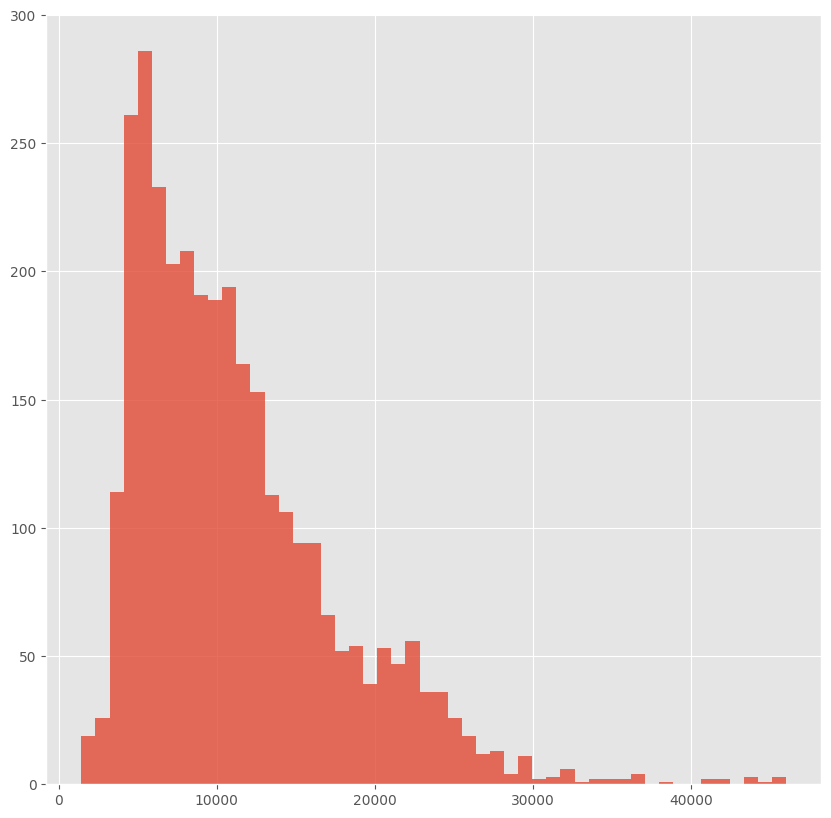

In [19]:
########### Price distribution ###########

y.hist(alpha=0.8, figsize=(10, 10), bins = 50)
plt.show()

/tmp/ipykernel_1106/3405678203.py:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix_plot  = scatter_matrix(X_num.iloc[:, :7],c=y_log_num, alpha=0.8, s=100,  cmap='magma', grid = True, diagonal = 'kde',hist_kwds = {'bins':50}, ax=ax)


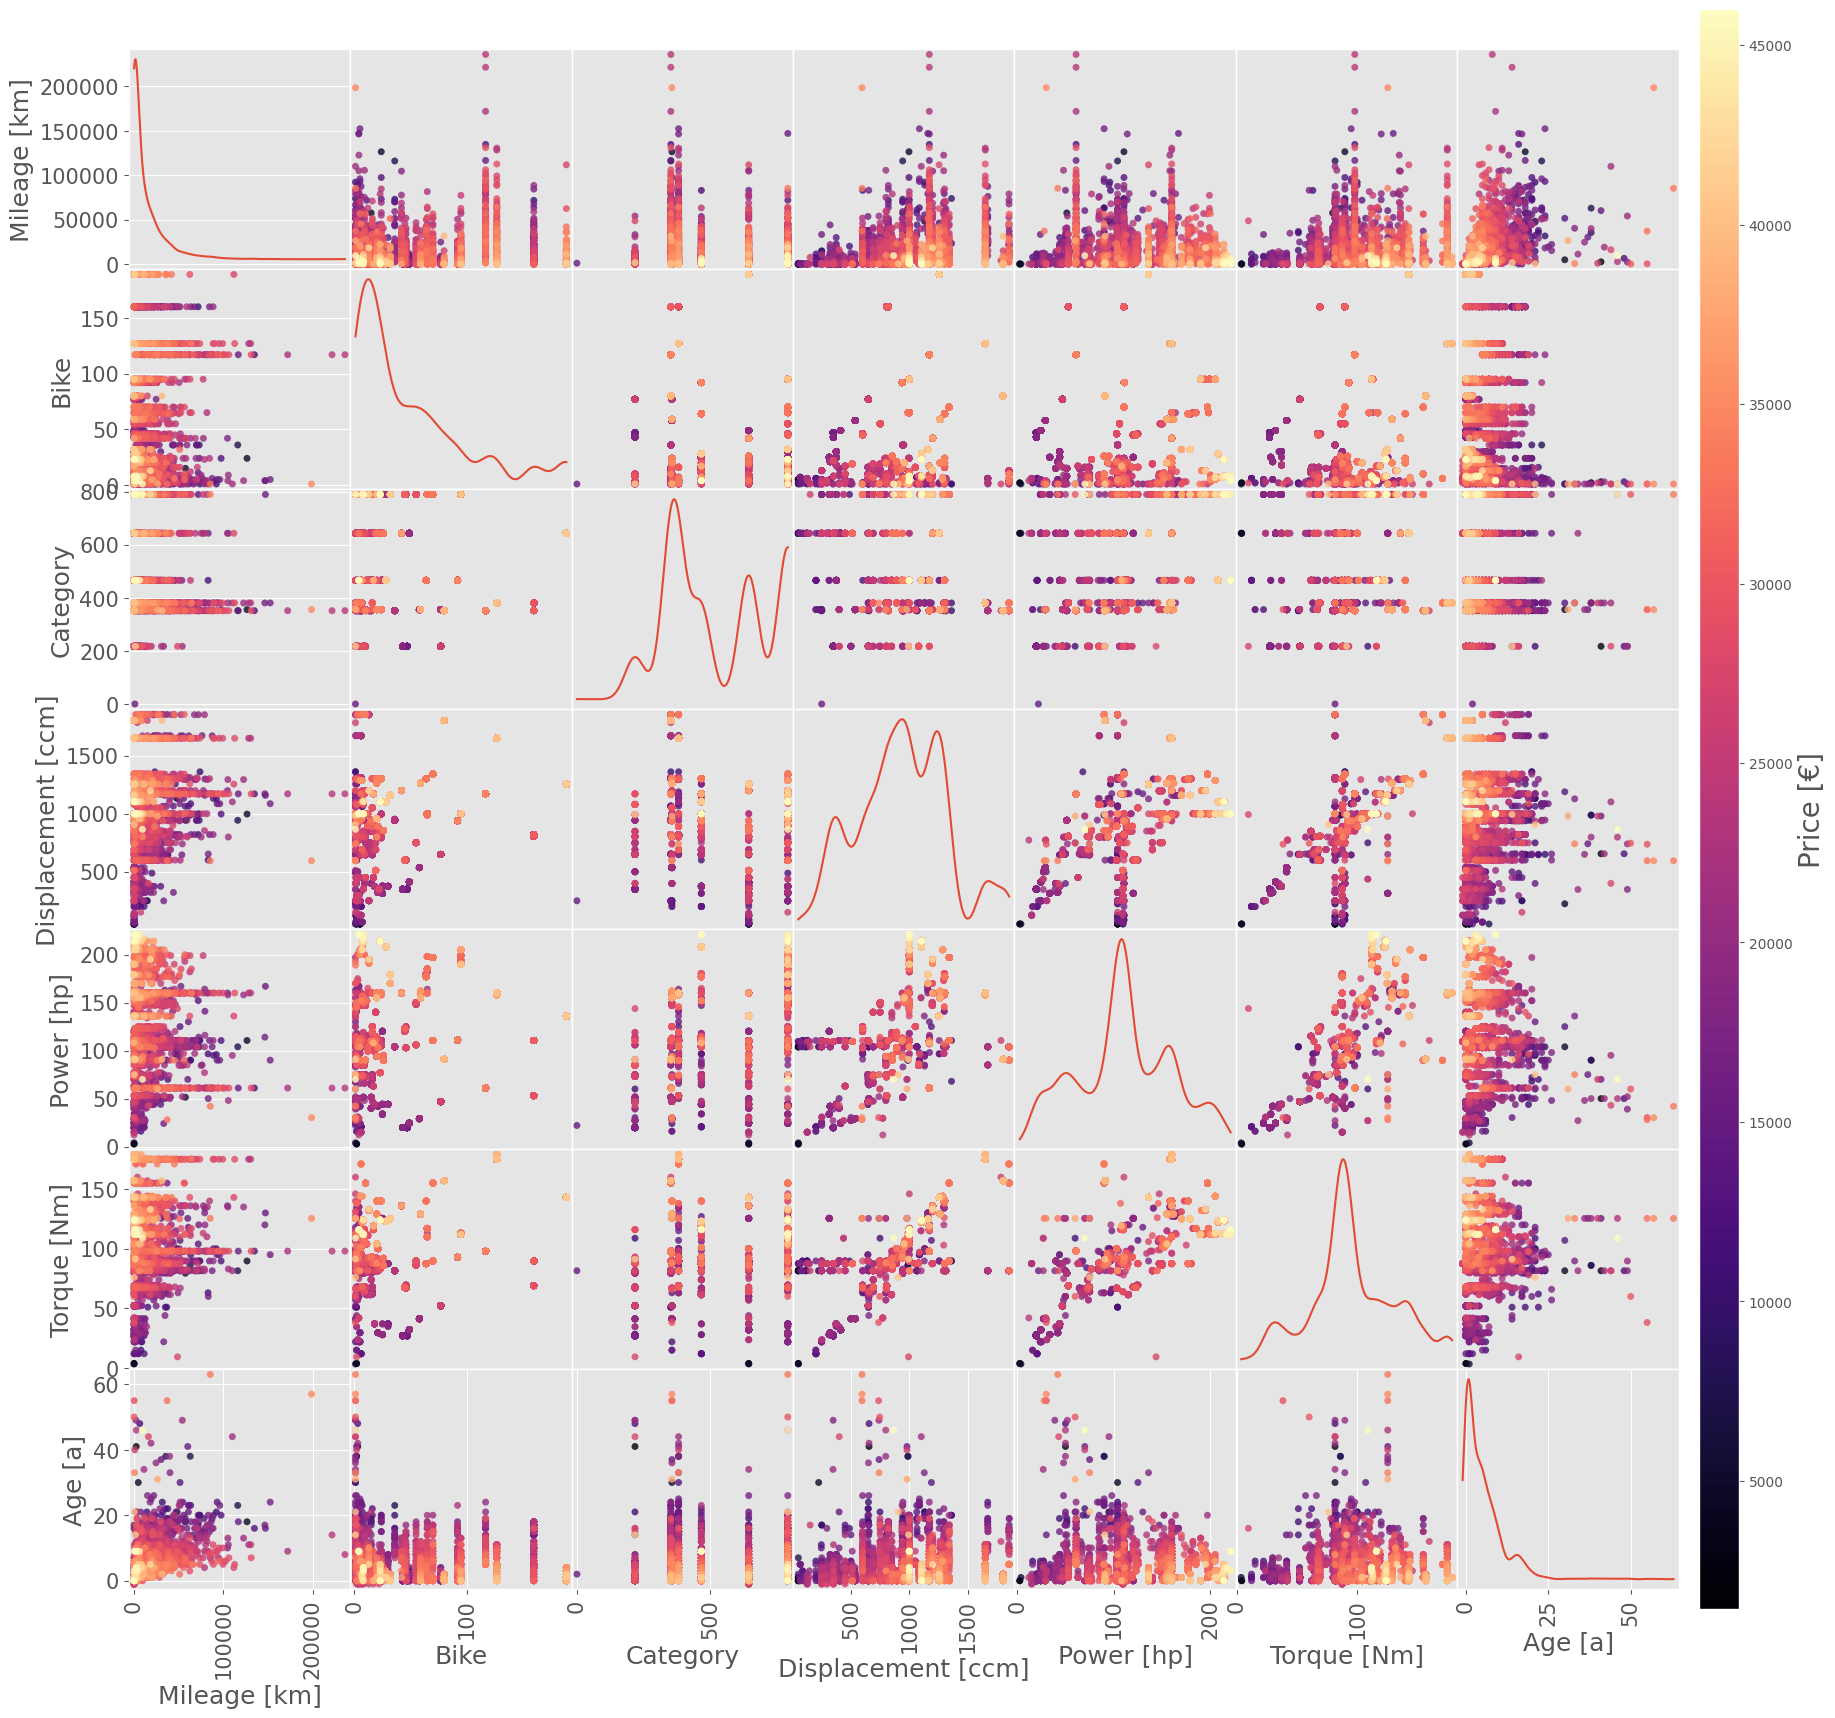

In [20]:
########### Scatter matrix ###########

from pandas.plotting import scatter_matrix
import matplotlib.colors as mcolors

y_mm_num = minmax_scale(y_num, feature_range=(0, 1))
y_log_num = np.log1p(y_num)

plt.rcParams['axes.labelsize'] = 18
fig, ax = plt.subplots(figsize=(20, 20))

cmap = plt.get_cmap('magma')
norm = mcolors.Normalize(vmin=y_num.min(), vmax=y_num.max())

scatter_matrix_plot  = scatter_matrix(X_num.iloc[:, :7],c=y_log_num, alpha=0.8, s=100,  cmap='magma', grid = True, diagonal = 'kde',hist_kwds = {'bins':50}, ax=ax)
plt.subplots_adjust(right=0.9)

for ax1 in scatter_matrix_plot.ravel():
    ax1.tick_params(axis='both', which='major', labelsize=15)

cbar_ax = fig.add_axes([0.91, 0.1, 0.02, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cbar_ax)
cb.set_label('Price [€]', fontsize = 20)

plt.show()

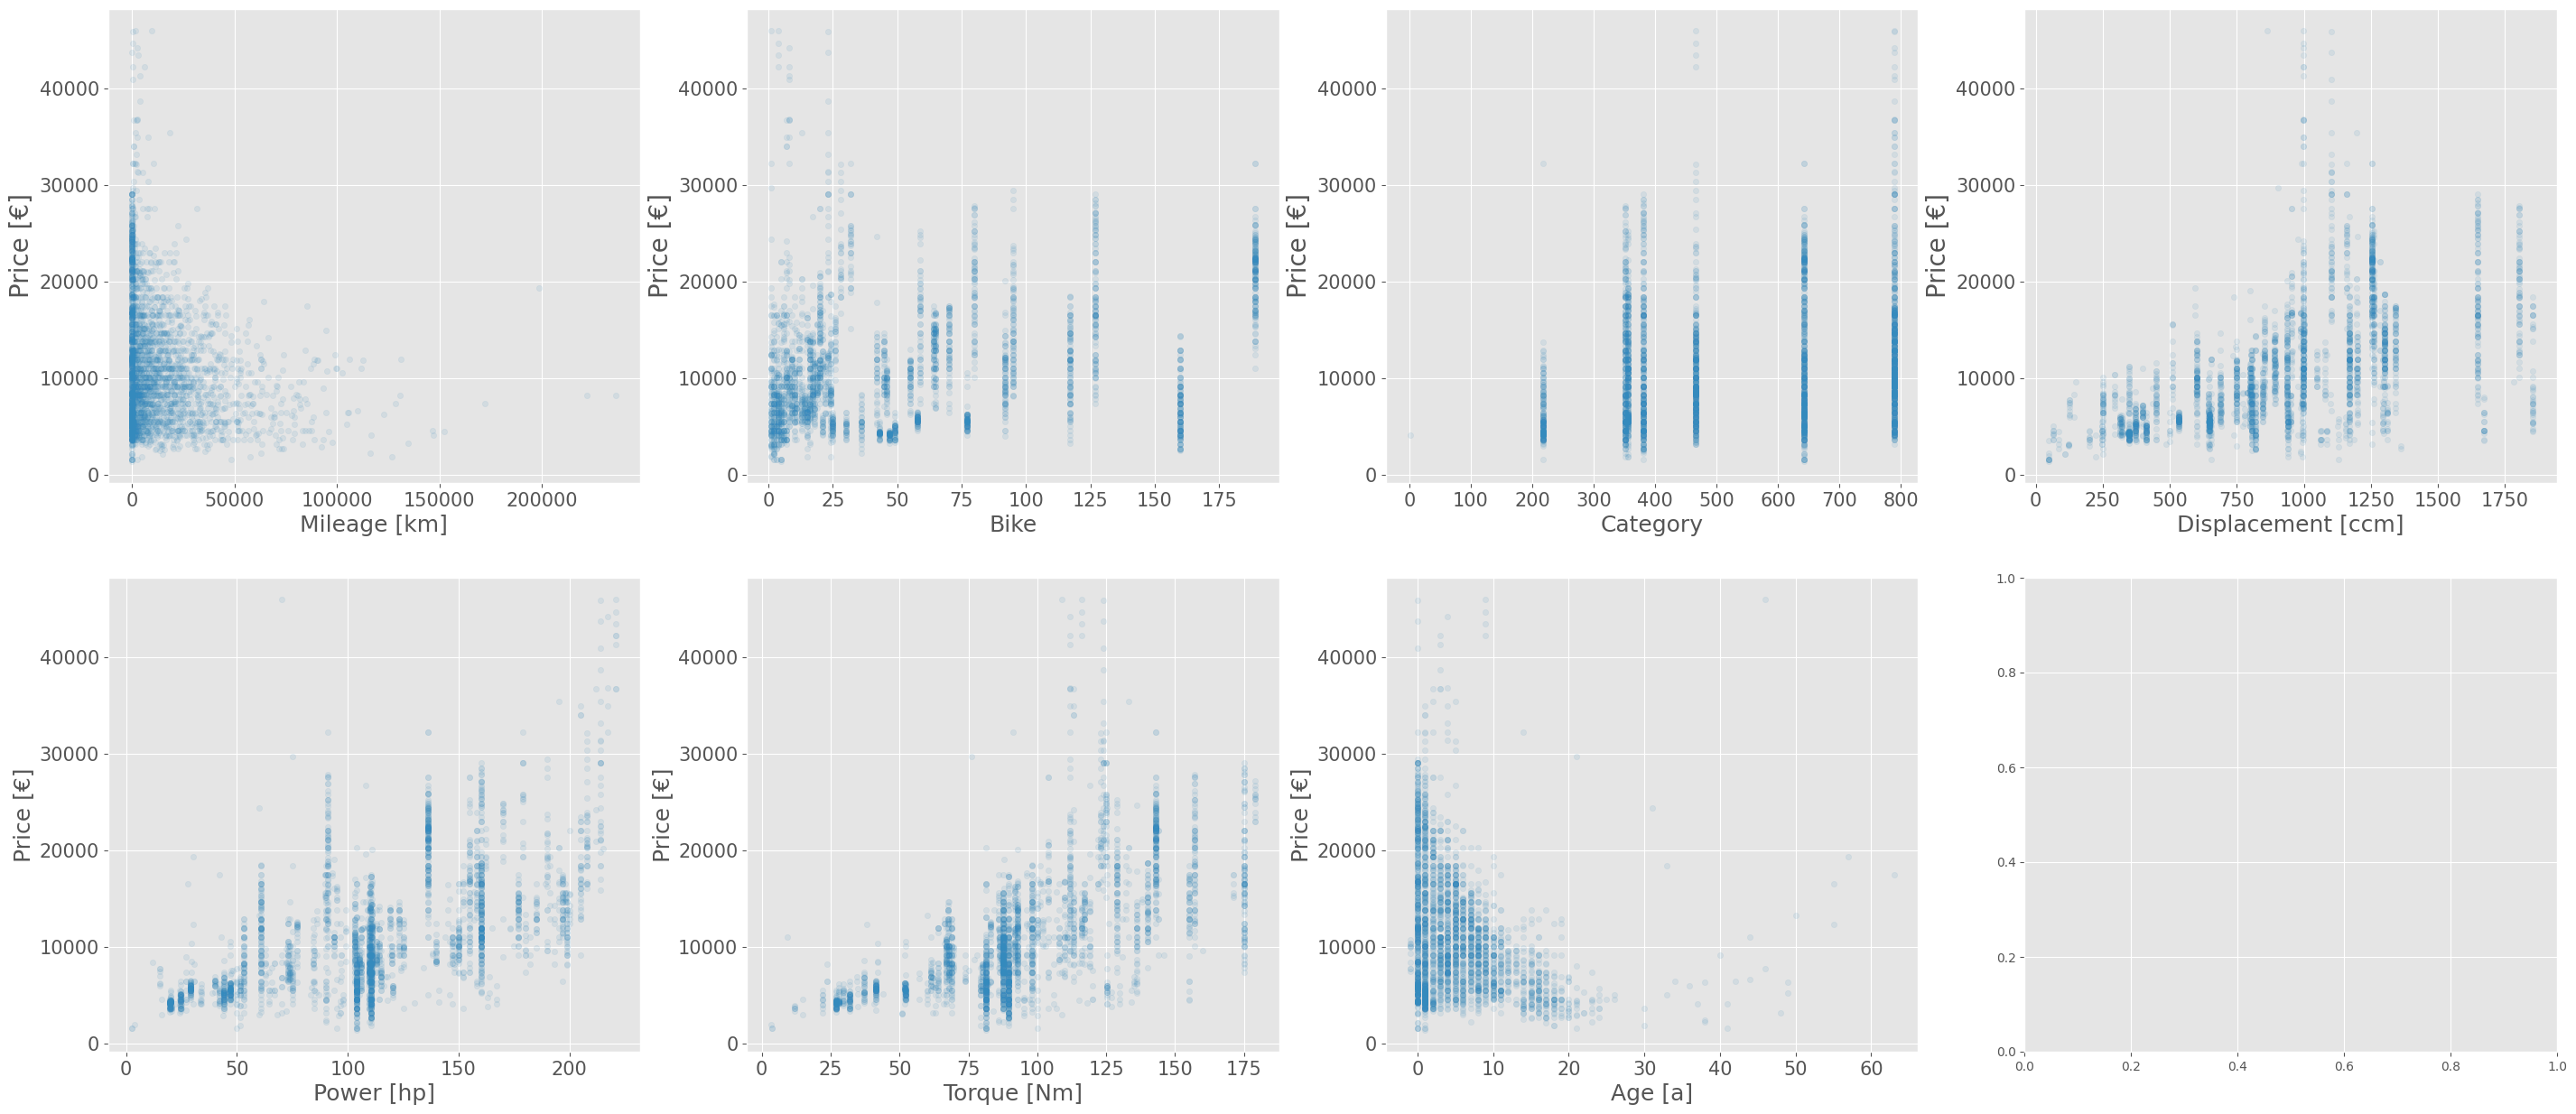

In [21]:
########### scatter plots ###########

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(35,15))


for xcol, ax in zip(['Mileage [km]', 'Bike', 'Category', 'Displacement [ccm]'], axes[0,:]):
    Z_num.plot(kind='scatter', x=xcol, y='price',ax=ax, alpha=0.1,ylabel='Price [€]')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylabel('Price [€]', fontsize=20)

for xcol, ax in zip(['Power [hp]', 'Torque [Nm]', 'Age [a]'], axes[1,:]):
    Z_num.plot(kind='scatter', x=xcol, y='price',ax=ax, alpha=0.1, ylabel='Price [€]')
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

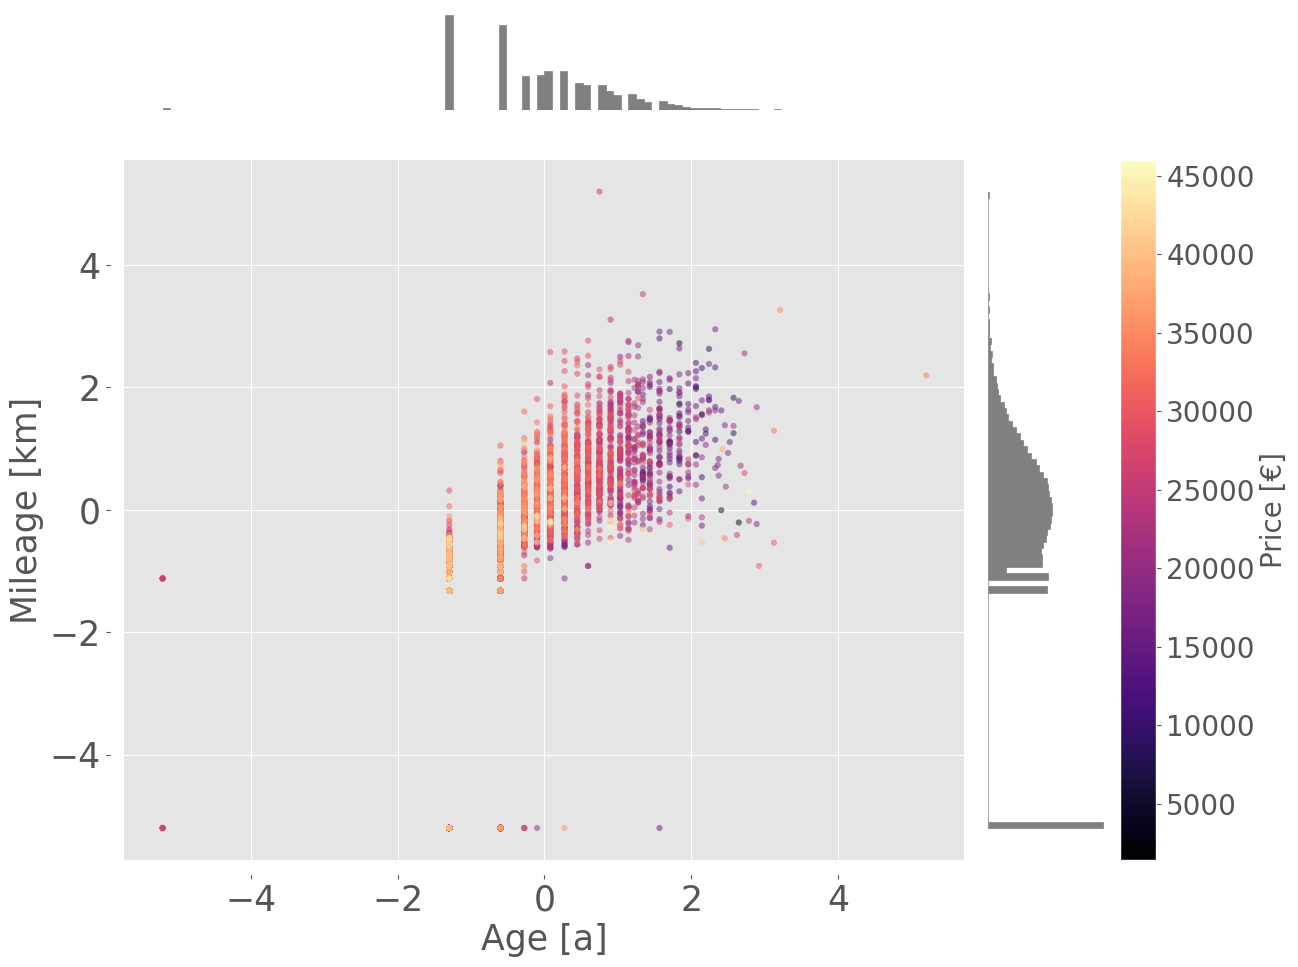

In [22]:
########### Different scalings ###########

X_Standard = StandardScaler().fit_transform(X_num)
X_Standard = MinMaxScaler().fit_transform(X_num)
X_MaxAbs = MaxAbsScaler().fit_transform(X_num)
X_Robust = RobustScaler(quantile_range=(25, 75)).fit_transform(X_num)
X_Uni = QuantileTransformer(output_distribution='uniform').fit_transform(X_num)
X_Normal = QuantileTransformer(output_distribution='normal').fit_transform(X_num)
X_L2 = Normalizer().fit_transform(X_num)

fig = plt.figure(figsize=(12,10))

X_ = X_Normal                        ########### CHANGE THIS FOR DIFFERENT SCALINGS -> X_Standard, X_MaxAbs, X_Robust, X_Uni, X_Normal, X_L2 ###########
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.1]
rect_histy = [left_h, bottom, 0.1, height]

ax_scatter = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

left, width = width + left + 0.13, 0.03

rect_colorbar = [left, bottom, width, height]
ax_colorbar = plt.axes(rect_colorbar)

ax, hist_X1, hist_X0 = ax_scatter, ax_histy, ax_histx

x0_label="Age [a]"
x1_label="Mileage [km]"

ax.set_xlabel(x0_label, fontsize=25)
ax.set_ylabel(x1_label, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax_colorbar.tick_params(axis='both', which='major', labelsize=20)
ax_colorbar.set_ylabel('Price [€]', fontsize=20)

cmap = plt.get_cmap('magma')

ax.scatter(X_[:,6], X_[:,0], alpha=0.5,c=y_log_num,cmap = cmap, marker='o', s=20, lw=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

hist_X1.set_ylim(ax.get_ylim())
hist_X1.hist(X_[:,0], bins=100, orientation='horizontal',
                color='grey', ec='grey')
hist_X1.axis('off')                 

hist_X0.set_xlim(ax.get_xlim())
hist_X0.hist(X_[:,6], bins=100, orientation='vertical',
                color='grey', ec='grey')

hist_X0.axis('off')

norm = mcolors.Normalize(vmin=y_num.min(), vmax=y_num.max())

cb = matplotlib.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              orientation='vertical',
                              label='Price [€]', norm = norm)

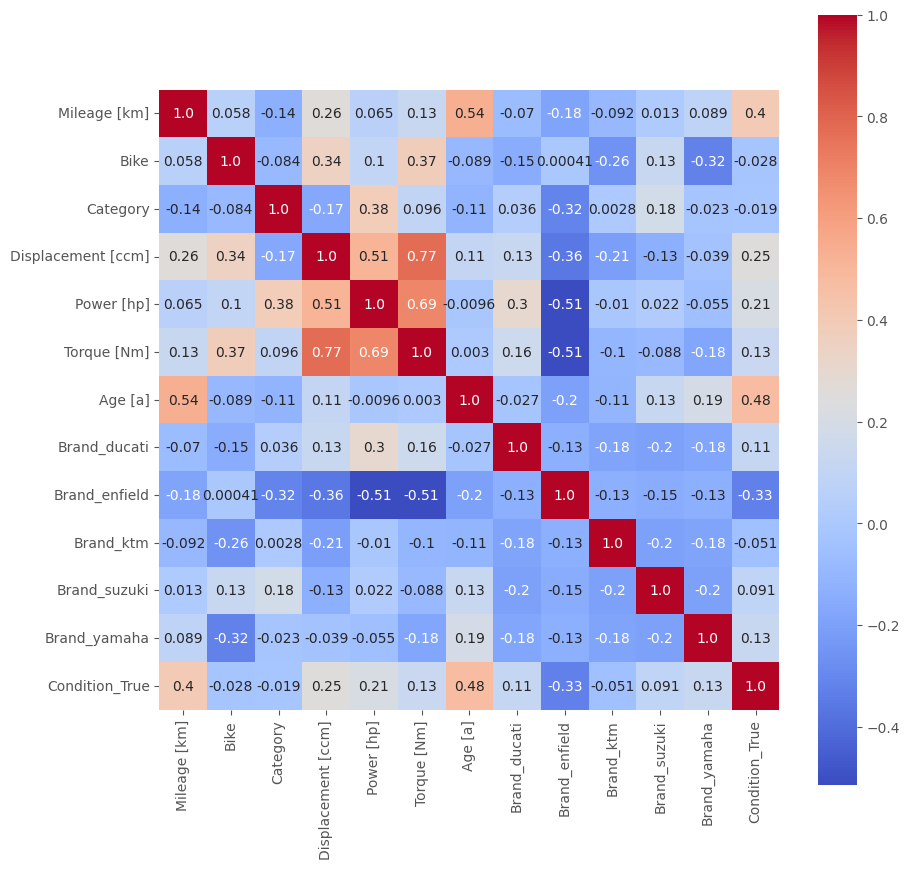

In [23]:
########### Correlation matrix ###########

Z_temp = X_num[:]
plt.figure(figsize=(10,10))
sns.heatmap(data = Z_temp.iloc[:].corr(), annot=True, square=True, cmap='coolwarm', label='Correlation', fmt=".2")
plt.show()

## **Machine Learning:**

### Scalers, Transformers and Pipelines:

In [25]:
########### Numerical and Categorical Features ###########

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_ = X.select_dtypes(include=['object', 'string[python]', 'bool']).columns.tolist()

########### Preprocessing for numerical data ###########

num_transformer_std = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

num_transformer_norm = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', QuantileTransformer(output_distribution='normal'))
])

num_transformer_robust = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler(quantile_range=(25, 75)))
])

num_transformer_none = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

########### Preprocessing for categorical data ###########

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#For CatBoost
cat_transformer_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))]) 

########### Define different preprocessors for numerical data ##########

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', num_transformer_std, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_norm = ColumnTransformer(
    transformers=[
        ('num', num_transformer_norm, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_robust = ColumnTransformer(
    transformers=[
        ('num', num_transformer_robust, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_none = ColumnTransformer(
    transformers=[
        ('num', num_transformer_none, num_features),
        ('cat', cat_transformer, cat_features_)
    ])

#For CatBoost

preprocessor_none_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_none, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_std_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_std, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_norm_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_norm, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_robust_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_robust, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

########### Transformer for the Price ###########

target_transformer_log = FunctionTransformer(np.log1p,inverse_func=np.expm1, validate=True)
target_transformer_mm = MinMaxScaler()

### Train - Test Split:

In [26]:
########### Train - Test - Splitting ###########

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

########### Log Transformation ###########

y_train_log = target_transformer_log.fit_transform(y_train.values.reshape(-1, 1))
y_test_log = target_transformer_log.transform(y_test.values.reshape(-1, 1))

y_train_mm = target_transformer_mm.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)
y_test_mm = target_transformer_mm.transform(y_test.values.reshape(-1, 1)).reshape(-1)

########### Define Scorers for the Cross validation ###########

def rmsle_score(y_true, y_pred):
    #y_true = target_transformer_mm.inverse_transform(y_true.reshape(-1, 1)).reshape(-1)  ########### SWITCH IF MIN MAX SCALING IS USED INSTEAD OF LOG ###########
    #y_pred = target_transformer_mm.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))
def mse_score(y_true, y_pred):
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return mean_squared_error(y_true, y_pred)
def mae_score(y_true, y_pred):
    y_true = np.expm1(y_true)  
    y_pred = np.expm1(y_pred)
    return mean_absolute_error(y_true, y_pred)
def r2_score1(y_true, y_pred):
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return r2_score(y_true, y_pred)

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)
r2_scorer = make_scorer(r2_score1, greater_is_better=False)
mse_scorer = make_scorer(mse_score, greater_is_better=False)
mae_scorer = make_scorer(mae_score, greater_is_better=False)

########### KFold for Cross Validation ###########

kf = KFold(n_splits=10, shuffle=True, random_state=123)

### **Training Models:**

#### **XGBOOST TREE**

In [27]:
########### Define Parameter Grid ###########

param_grid_xgbtree = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__learning_rate': [0.03, 0.05, 0.08],
    'regressor__max_depth': [4, 5, 6],
    'regressor__min_child_weight': [2, 3, 4],
    'regressor__subsample': [0.4, 0.6, 0.7],
    'regressor__colsample_bytree': [0.3, 0.6, 0.8],
    'regressor__gamma': [0, 0.1, 0.3, 0.5],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1]
}


########### Initialize Base Model ###########

xgb_tree_model = XGBRegressor(objective='reg:squarederror', booster='gbtree', random_state=42, enable_categorical=True)

########### Use Pipeline on Base Model ###########

model_xgbtree = Pipeline(steps=[
    ('preprocessor', preprocessor_norm),  ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', xgb_tree_model)
])

########### Random Search for best parameters ###########

#random_search_xgbtree = RandomizedSearchCV(estimator=model_xgbtree, param_distributions=param_grid_xgbtree, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_xgbtree.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_xgbtree_std_log = {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_norm_log = {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_robust_log = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_none_log = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_std_mm = {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.01, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_xgbtree = best_params_xgbtree_norm_log
#random_search_xgbtree.best_params_ ########### Parameters of Grid Search

########### Set Parameters ###########

best_xgbtree = model_xgbtree.set_params(**best_params_xgbtree)
start = time.time() ########### Track Time
best_xgbtree.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_xgbtree = best_xgbtree.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_xgbtree_inv = target_transformer_log.inverse_transform(y_pred_xgbtree.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########
 
cv_scores_xgbtree_rmsle = cross_val_score(best_xgbtree, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for XGBoost Tree: ")
print(f"Best parameters: {best_params_xgbtree}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgbtree_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgbtree_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgbtree_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgbtree_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgbtree_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgbtree))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Tree: 
Best parameters: {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
Cross-Validation RMSE Scores: [2108.01541487 3368.12942851 2133.29050235 2345.37097715 2596.80736949
 2104.8347019  2634.62190639 2450.33423845 2314.68497565 1743.43810945]
Mean RMSE: 2379.9527624209454
Standard Deviation of RMSE: 414.0552855767157
MSE: 4524585.92
MAE: 1350.72
R2-Score: 0.895
Training time: 2.3216142654418945s


##### **XGBoost Metrics:**

**Metrics for XGBoost Tree Log Standard:**

Best parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2112.02973138 3359.98328441 2116.63709523 2258.95546336 2534.21538524 2075.57920921 2803.52390877 2532.2391268  2469.95961849 1741.7229471 ]

Mean RMSE: 2400.48

Standard Deviation of RMSE: 429.71

MSE: 4557951.89

MAE: **1350.62**

R2-Score: **0.894**

Training time: 2.37s


**Metrics for XGBoost Tree Log Normalised: (BEST)**

Best parameters: {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2161.23741596 3322.02786192 2137.90912851 2315.7989309  2587.76970711 2112.66001255 2676.10762662 2330.87051486 2369.97988735 1778.2157678 ]

Mean RMSE: 2379.26

Standard Deviation of RMSE: 395.60

MSE: 4514569.40

MAE: **1352.13**

R2-Score: **0.897**

Training time: 2.42s


**Metrics for XGBoost Tree Robust:**

Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2085.10909863 3393.07532792 2223.32343396 2414.82424385 2626.12583229 2026.79056983 2698.34018201 2447.40098379 2373.95324535 1760.78647443]

Mean RMSE: 2404.97

Standard Deviation of RMSE: 425.15

MSE: 4500529.41

MAE: **1356.10**

R2-Score: **0.895**

Training time: 2.71


**Metrics for XGBoost Tree Log No Scaling:**

Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2075.83261461 3322.12092512 2164.67377904 2332.07881493 2616.94182646 2014.93333682 2721.03162476 2500.56481784 2381.85544236 1762.41658875]

Mean RMSE: 2389.245

Standard Deviation of RMSE: 415.883

MSE: 4479635.33

MAE: **1342.35**

R2-Score: **0.897**

Training time: 2.351s


**Metrics for XGBoost Tree MM Standard:**

Best parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.01, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2288.1187393  3436.89222874 2219.56272654 1924.27277691 2685.30148106 2146.61733512 2622.66234688 2507.47615984 2729.01564972 2307.90476099]

Mean RMSE: 2486.78

Standard Deviation of RMSE: 399.34

MSE: 4706014.85

MAE: **1447.28**

R2-Score: **0.878**

Training time: 5.20

#### **XGBOOST LIN**

In [28]:
########### Define Parameter Grid ###########

param_grid_xgblin = {
    'regressor__learning_rate': [0.06, 0.08, 0.1, 0.12],
    'regressor__alpha': [1.3, 1.5, 1.7],
    'regressor__lambda': [0.001, 0.1, 1],
    'regressor__n_estimators': [300, 320, 349],
    'regressor__reg_alpha': [0, 0.001, 0.01],
    'regressor__reg_lambda': [0.003, 0.005, 0.01]
}

########### Initialize Base Model ###########

xgb_lin_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=50)

########### Use Pipeline on Base Model ###########

model_xgblin = Pipeline(steps=[
    ('preprocessor', preprocessor_none), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', xgb_lin_model)
])

########### Random Search for best parameters ###########

#random_search_xgblin = RandomizedSearchCV(estimator=model_xgblin, param_distributions=param_grid_xgblin, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_xgblin.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_xgblin_std_log = {'regressor__reg_lambda': 0.005, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.001, 'regressor__alpha': 1.5}
best_params_xgblin_norm_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}
best_params_xgblin_robust_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}
best_params_xgblin_none_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}
#random_search_xgblin.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_xgblin = best_params_xgblin_none_log

########### Set Parameters ###########

best_xgblin = model_xgblin.set_params(**best_params_xgblin)
start = time.time()
best_xgblin.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_xgblin = best_xgblin.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_xgblin_inv = target_transformer_log.inverse_transform(y_pred_xgblin.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_xgblin_rmsle = cross_val_score(best_xgblin, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for XGBoost Lin: ")
print(f"Best parameters: {best_params_xgblin}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgblin_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgblin_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgblin_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgblin_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgblin_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgblin))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Tree: 
Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}
Cross-Validation RMSE Scores: [2961.09557324 3848.40173514 3502.93564087 3689.29023325 3548.88058273
 2677.62509613 3787.36191294 3355.09025762 4332.8394422  2754.09441872]
Mean RMSE: 3445.761489283757
Standard Deviation of RMSE: 495.02375389219577
MSE: 8563106.21
MAE: 1943.01
R2-Score: 0.779
Training time: 2.1650400161743164s


##### **XGBOOST LIN METRICS:**

**Metrics for XGBoost Lin Standard:**

Best parameters: {'regressor__reg_lambda': 0.005, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.001, 'regressor__alpha': 1.5}

Cross-Validation RMSE Scores: [2875.92350078 3813.3397601  3527.17262871 3599.8244191  3509.00374465 2826.62478785 3840.11190907 3346.20591247 4341.02300559 2708.38487218]

Mean RMSE: 3438.76

Standard Deviation of RMSE: 488.64

MSE: 8740382.35

MAE: **1920.28**

R2-Score: **0.783**

Training time: 2.37s


**Metrics for XGBoost Lin Normalised:**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}

Cross-Validation RMSE Scores: [2978.67539117 3831.7430115  3583.40216116 3240.15981843 3411.10240912 2844.63171407 3608.77164637 3248.2082167  3841.29823349 2905.98954913]

Mean RMSE: 3349.40

Standard Deviation of RMSE: 348.06

MSE: 9572071.25

MAE: **2082.50**

R2-Score: **0.765**

Training time: 2.45s

**Metrics for XGBoost Lin Robust: (BEST)**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}

ross-Validation RMSE Scores: [3135.96235869 3812.42318278 3587.86662636 3384.04775868 3606.06094928 2650.43955494 3930.40119147 3443.79756281 4347.24998711 2709.42401445]

Mean RMSE: 3460.77

Standard Deviation of RMSE: 500.02

MSE: 8402075.27

MAE: **1915.19**

R2-Score: **0.787**

Training time: 3.43

**Metrics for XGBoost Lin No Scaling:**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}

Cross-Validation RMSE Scores: [2838.05481834 3924.09805536 3583.14428551 3579.86077855 3657.67248474 2675.76984055 3788.55376952 3417.78301586 4226.34412204 2749.16816792]
 
Mean RMSE: 3444.05

Standard Deviation of RMSE: 498.56

MSE: 9371909.08

MAE: **2027.86**

R2-Score: **0.764**

Training time: 2.54s


#### **CatBoost:**

In [64]:
########### Define Parameter Grid ###########

param_grid_catboost = {
    'regressor__iterations': [500, 1000],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__depth': [4, 6, 8, 10],
    'regressor__l2_leaf_reg': [1, 3, 5, 7],
    'regressor__bagging_temperature': [0.5, 1],
    'regressor__random_strength': [0.05, 1, 5],
    'regressor__border_count': [32, 64, 128],
    'regressor__min_data_in_leaf': [1, 3, 10],
    'regressor__one_hot_max_size': [2, 10, 20]
}

########### Index of Cat features after preprocessor ###########

cat_features__ = [5, 6, 7, 8]

########### Initialize Base Model ###########

catboost_model = CatBoostRegressor(random_seed=42, cat_features= cat_features__)

########### Use Pipeline on Base Model ###########

model_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor_std_cat), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('regressor', catboost_model)
])

########### Random Search for best parameters ###########

#random_search_catboost = RandomizedSearchCV(estimator=model_catboost.set_params(regressor__cat_features= cat_features__), param_distributions=param_grid_catboost, cv=kf, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

########### Fitting for Randomized Search ###########

#random_search_catboost.fit(X_train, y_train_log, regressor__cat_features= cat_features__)

########### Best Parameters from Search ###########

best_params_catboost_std_log = {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 10, 'regressor__min_data_in_leaf': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
best_params_catboost_norm_log = {'regressor__random_strength': 0.05, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 6, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.5}
best_params_catboost_robust_log = {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}
best_params_catboost_none_log =  {'regressor__random_strength': 5, 'regressor__one_hot_max_size': 20, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.05, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
#random_search_catboost.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_catboost = best_params_catboost_std_log

########### Set Parameters ###########

best_catboost = model_catboost.set_params(**best_params_catboost,)

start = time.time()
best_catboost.fit(X_train, y_train_log, regressor__cat_features =cat_features__) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_catboost = best_catboost.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_catboost_inv = target_transformer_log.inverse_transform(y_pred_catboost.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_catboost_rmsle = cross_val_score(best_catboost, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for CatBoost: ")
print(f"Best parameters: {best_params_catboost}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_catboost_rmsle}")
print(f"Mean RMSE: {-cv_scores_catboost_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_catboost_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_catboost_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_catboost_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_catboost))
print(f"Training time: {stop - start}s")

0:	learn: 0.5270792	total: 3.77ms	remaining: 1.88s
1:	learn: 0.4963924	total: 6.53ms	remaining: 1.63s
2:	learn: 0.4683285	total: 9.79ms	remaining: 1.62s
3:	learn: 0.4411357	total: 12.9ms	remaining: 1.6s
4:	learn: 0.4166772	total: 16ms	remaining: 1.58s
5:	learn: 0.3948086	total: 18.7ms	remaining: 1.54s
6:	learn: 0.3768028	total: 21.1ms	remaining: 1.49s
7:	learn: 0.3599170	total: 23.9ms	remaining: 1.47s
8:	learn: 0.3444329	total: 26.8ms	remaining: 1.46s
9:	learn: 0.3305767	total: 29.2ms	remaining: 1.43s
10:	learn: 0.3182772	total: 31.6ms	remaining: 1.4s
11:	learn: 0.3073375	total: 34.6ms	remaining: 1.41s
12:	learn: 0.2978112	total: 38.2ms	remaining: 1.43s
13:	learn: 0.2893322	total: 42.3ms	remaining: 1.47s
14:	learn: 0.2813775	total: 44.9ms	remaining: 1.45s
15:	learn: 0.2744498	total: 47.1ms	remaining: 1.43s
16:	learn: 0.2676026	total: 49.7ms	remaining: 1.41s
17:	learn: 0.2619835	total: 52.4ms	remaining: 1.4s
18:	learn: 0.2558610	total: 56ms	remaining: 1.42s
19:	learn: 0.2510691	total: 5

##### METRICS CATBOOST:

**Metrics for Catboost Log Standard (BEST):**

Best parameters: {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 10, 'regressor__min_data_in_leaf': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}

Cross-Validation RMSE Scores: [2054.22396583 3185.68220274 2242.48420856 2270.15758479 2503.43829942 2013.0169515  2588.78605261 2517.41866886 2302.57048513 1663.35454145]

Mean RMSE: 2334.11

Standard Deviation of RMSE: 386.93

MSE: 4146873.05

MAE: **1297.27**

R2-Score: **0.902**

Training time: 2.15

**Metrics for Catboost Normalised:** 

Best parameters: {'regressor__random_strength': 0.05, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 6, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.5}

Cross-Validation RMSE Scores: [2159.76198192 3140.28206616 2155.62470872 2092.91998605 2474.50740455 1957.51152263 2496.91183554 2524.20096755 2319.4981183  1662.72679045]

Mean RMSE: 2298.39

Standard Deviation of RMSE: 378.51

MSE: 4407888.22

MAE: **1320.62**

R2-Score: **0.899**

Training time: 1.73s

**Metrics for Catboost Robust:**

Best parameters: {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}

Cross-Validation RMSE Scores: [2206.89994378 3158.02482086 2264.00659475 2098.50868624 2690.36732593 1967.90998071 2480.77836633 2525.8082817  2406.77617059 1640.11327456]

Mean RMSE: 2343.92

Standard Deviation of RMSE: 395.05

MSE: 4174227.18

MAE: **1305.89**

R2-Score: **0.899**

Training time: 2.51s

**Metrics for Catboost No Scaling:** 

Best parameters: {'regressor__random_strength': 5, 'regressor__one_hot_max_size': 20, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.05, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
Cross-Validation RMSE Scores: [2007.58404541 3276.55882292 2087.87444843 2051.36170411 2515.72346317 2045.67003296 2599.41770193 2460.58616417 2361.81591538 1693.02003295]

Mean RMSE: 2309.96

Standard Deviation of RMSE: 417.60

MSE: 4148775.54

MAE: **1300.41**

R2-Score: **0.901**

Training time: 1.81s

#### **ADABOOST:**

In [30]:
########### Define Parameter Grid ###########

param_grid_adatree = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 1],
    'regressor__estimator__max_depth': [1, 2, 3]}

########### Initialize Base Model ###########

base_model = DecisionTreeRegressor()
ada_tree_model = AdaBoostRegressor(estimator=base_model, random_state=42, loss ='exponential')

########### Use Pipeline on Base Model ###########

model_adatree = Pipeline(steps=[
    ('preprocessor', preprocessor_none), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', ada_tree_model)
])

########### Random Search for best parameters ###########

#random_search_adatree = RandomizedSearchCV(estimator=model_adatree, param_distributions=param_grid_adatree, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_adatree.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_adatree_std_log = {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_norm_log = {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_robust_log = {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_none_log = {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
#random_search_adatree.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_adatree = best_params_adatree_none_log

########### Set Parameters ###########

best_adatree = model_adatree.set_params(**best_params_adatree)
start = time.time()
best_adatree.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_adatree = best_adatree.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_adatree_inv = target_transformer_log.inverse_transform(y_pred_adatree.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_adatree_rmsle = cross_val_score(best_adatree, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for AdaBoost: ")
print(f"Best parameters: {best_params_adatree}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_adatree_rmsle}")
print(f"Mean RMSE: {-cv_scores_adatree_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_adatree_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_adatree_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_adatree_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_adatree))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Tree: 
Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
Cross-Validation RMSE Scores: [3169.00930376 3862.74586243 3395.879334   3529.88666315 3593.65254522
 3249.19703945 4167.76196901 3716.54487244 4205.49062915 2968.61246879]
Mean RMSE: 3585.8780687395943
Standard Deviation of RMSE: 390.34391117975736
MSE: 11360725.55
MAE: 2355.92
R2-Score: 0.763
Training time: 2.7594351768493652s


##### **ADABOOST METRICS:**

**Metrics for AdaBoost Tree Log Standard:** 

Best parameters: {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3095.99922263 3755.09487152 3311.82332674 3623.61666092 3625.9379629 3167.97207058 4168.57773347 3750.19046947 4385.82384339 2945.78789522]

Mean RMSE: 3583.08

Standard Deviation of RMSE: 440.17

MSE: 10952648.28

MAE: **2337.28**

R2-Score: **0.768**

Training time: 2.62s

**Metrics for AdaBoost Tree Log Normalised: (BEST)** 

Best parameters: {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [2957.28343312 3755.84203139 3323.35389333 3491.85800767 3591.22256778 3188.35036614 4098.92760647 3786.8502023  4267.29447033 2940.70727812]

Mean RMSE: 3540.17

Standard Deviation of RMSE: 426.98

MSE: 11411895.78

MAE: **2325.36**

R2-Score: **0.767**

Training time: 2.54s

**Metrics for AdaBoost Tree Log Robust:** 

Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3157.30278356 3789.27792427 3395.26796872 3691.11138487 3626.3725542 3174.04872236 4360.58018463 3758.99854509 4354.39070176 3197.1272112 ]

Mean RMSE: 3650.45

Standard Deviation of RMSE: 421.17

MSE: 11127472.68

MAE: **2370.37**

R2-Score: **0.762**

Training time: 3.22

**Metrics for AdaBoost Tree No Scaling:** 

Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3172.62841034 3908.32059859 3317.08896478 3634.51874029 3593.65254522 3147.55785325 4382.87224401 3805.52471023 4334.8678519  2967.82287387]

Mean RMSE: 3626.49

Standard Deviation of RMSE: 463.84

MSE: 11975364.10

MAE: **2421.71**

R2-Score: **0.751**

Training time: 2.86s

#### **EXTRA TREES**

In [31]:
########### Define Parameter Grid ###########

param_grid_ET = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
    #'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

########### Initialize Base Model ###########

extra_trees_regressor = ExtraTreesRegressor(random_state=42, bootstrap = True, max_features = 'log2')

########### Use Pipeline on Base Model ###########

model_et = Pipeline(steps=[
    ('preprocessor', preprocessor_robust), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', extra_trees_regressor)
])

########### Random Search for best parameters ###########

#random_search_et = RandomizedSearchCV(estimator=model_et, param_distributions=param_grid_ET, n_iter=200, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_et.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_et_std_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
best_params_et_norm_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 30}
best_params_et_robust_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
best_params_et_none_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}
#random_search_et.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_et = best_params_et_robust_log

########### Set Parameters ###########

best_et = model_et.set_params(**best_params_et)
start = time.time()
best_et.fit(X_train, y_train_log.ravel())  ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_et = best_et.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_et_inv = target_transformer_log.inverse_transform(y_pred_et.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_et_rmsle = cross_val_score(best_et, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########
print("Metrics for Extra Trees: ")
print(f"Best parameters: {best_params_et}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_et_rmsle}")
print(f"Mean RMSE: {-cv_scores_et_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_et_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_et_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_et_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_et))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Tree: 
Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
Cross-Validation RMSE Scores: [2223.90318935 3418.75900001 2410.52599883 2448.14433971 2517.62889039
 2145.15415401 2777.3933756  2516.32172302 2626.4598932  1847.47359626]
Mean RMSE: 2493.1764160353946
Standard Deviation of RMSE: 396.9633723892788
MSE: 4426741.60
MAE: 1345.30
R2-Score: 0.890
Training time: 3.5916287899017334s


##### EXTRA TREES METRICS:

**Metrics for Extra Tree Log Standard:**

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

Cross-Validation RMSE Scores: [2232.01337882 3424.82983704 2412.39290284 2451.24930626 2512.36167334 2079.55354287 2787.69893628 2530.17626057 2672.5654003  1842.8446666 ]

Mean RMSE: 2494.57

Standard Deviation of RMSE: 407.32

MSE: 4481129.52

MAE: **1349.45**

R2-Score: **0.889**

Training time: 3.47s

**Metrics for Extra Tree Log Normalised:** 

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 30}

Cross-Validation RMSE Scores: [2248.18737597 3403.90449366 2411.22516908 2532.23084757 2523.01533853 2152.76242567 2841.59419393 2546.08601446 2546.59697768 1864.03075091]

Mean RMSE: 2506.96

Standard Deviation of RMSE: 391.85

MSE: 4426545.16

MAE: **1357.27**

R2-Score: **0.886**

Training time: 3.47s

**Metrics for Extra Tree Log Robust: (BEST)**

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

Cross-Validation RMSE Scores: [2234.87335067 3425.79842625 2401.25712544 2396.36577456 2507.45672722 2066.67180223 2783.59600359 2525.73859772 2536.13462763 1821.82190257]

Mean RMSE: 2469.97

Standard Deviation of RMSE: 408.54

MSE: 4394657.34

MAE: **1339.02**

R2-Score: **0.890**

Training time: 3.76

**Metrics for Extra Tree Log No Scaling:** 

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}

Cross-Validation RMSE Scores: [2276.57774037 3527.9864219  2411.34020842 2365.66351731 2746.04872753 2146.28303406 2725.95728645 2508.91628507 2677.95911865 1791.22241392]

Mean RMSE: 2517.80

Standard Deviation of RMSE: 435.92

MSE: 4590153.21

MAE: **1369.69**

R2-Score: **0.891**

Training time: 3.94s


#### ENSEMBLE CATBOOST, XGBOOST, EXTRA TREES

In [32]:
########### Define Ensemble ###########

ensemble_model = VotingRegressor(estimators=[('CatBoost',best_catboost ),('ExtraTrees', best_et), ('XGBoost', best_xgbtree)])

In [33]:
########### Search for Best Weights ###########

params_weights = {
          'weights':[(1,1,1), (1,1,2), 
                     (2,1,1), (1,2,1),
                     (2,2,1), (1,2,2), 
                     (1,2,3), (3,2,1),
                     (2,3,1), (1,3,2)]}

#grid = GridSearchCV(ensemble_model, params_weights, n_jobs = -1, cv=kf, verbose=2, scoring='neg_mean_squared_error')
#grid.fit(X_train, y_train_log.ravel())

best_params_ = {'weights': (2, 1, 1)} ########### Best weights ###########

########### Set Parameters ###########

tuned_ensemble_model = VotingRegressor(estimators=[('CatBoost',best_catboost ),('ExtraTrees', best_et), ('XGBoost', best_xgbtree)] ,**best_params_)

In [34]:
########### Fit Model ###########

tuned_ensemble_model.fit(X_train,y_train_log)

0:	learn: 0.5270792	total: 2.82ms	remaining: 1.41s
1:	learn: 0.4963924	total: 5.3ms	remaining: 1.32s
2:	learn: 0.4683285	total: 7.93ms	remaining: 1.31s
3:	learn: 0.4411357	total: 11.1ms	remaining: 1.37s
4:	learn: 0.4166772	total: 15.5ms	remaining: 1.53s
5:	learn: 0.3948086	total: 18.2ms	remaining: 1.5s
6:	learn: 0.3768028	total: 20.8ms	remaining: 1.46s
7:	learn: 0.3599170	total: 23.1ms	remaining: 1.42s
8:	learn: 0.3444329	total: 25.3ms	remaining: 1.38s
9:	learn: 0.3305767	total: 28.6ms	remaining: 1.4s
10:	learn: 0.3182772	total: 31.4ms	remaining: 1.4s
11:	learn: 0.3073375	total: 33.9ms	remaining: 1.38s
12:	learn: 0.2978112	total: 36.4ms	remaining: 1.36s
13:	learn: 0.2893322	total: 38.8ms	remaining: 1.34s
14:	learn: 0.2813775	total: 42.6ms	remaining: 1.38s
15:	learn: 0.2744498	total: 44.9ms	remaining: 1.36s
16:	learn: 0.2676026	total: 47.1ms	remaining: 1.34s
17:	learn: 0.2619835	total: 49.4ms	remaining: 1.32s
18:	learn: 0.2558610	total: 51.9ms	remaining: 1.31s
19:	learn: 0.2510691	total

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


44:	learn: 0.2006748	total: 114ms	remaining: 1.15s
45:	learn: 0.1996936	total: 116ms	remaining: 1.14s
46:	learn: 0.1987518	total: 119ms	remaining: 1.14s
47:	learn: 0.1980838	total: 122ms	remaining: 1.15s
48:	learn: 0.1973990	total: 125ms	remaining: 1.15s
49:	learn: 0.1968732	total: 127ms	remaining: 1.14s
50:	learn: 0.1961391	total: 129ms	remaining: 1.14s
51:	learn: 0.1953630	total: 132ms	remaining: 1.14s
52:	learn: 0.1945345	total: 134ms	remaining: 1.13s
53:	learn: 0.1938853	total: 136ms	remaining: 1.13s
54:	learn: 0.1933286	total: 139ms	remaining: 1.12s
55:	learn: 0.1928874	total: 141ms	remaining: 1.12s
56:	learn: 0.1922785	total: 143ms	remaining: 1.11s
57:	learn: 0.1915216	total: 145ms	remaining: 1.11s
58:	learn: 0.1910037	total: 148ms	remaining: 1.1s
59:	learn: 0.1902529	total: 150ms	remaining: 1.1s
60:	learn: 0.1898160	total: 152ms	remaining: 1.1s
61:	learn: 0.1893156	total: 155ms	remaining: 1.09s
62:	learn: 0.1887813	total: 157ms	remaining: 1.09s
63:	learn: 0.1879196	total: 160ms	

VotingRegressor(estimators=[('CatBoost',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Mileage '
                                                                                '[km]',
                                                                                'Displacement '
                                                                                '[ccm]',
                                                                                'Power '
                                                                                '[hp]',
                                                                                'Torque '
                                                                                '[Nm]',
                                                                                'Age '
                                                                                '[a]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['Bike'...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.08,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=5,
                                                           max_leaves=None,
                                                           min_child_weight=4,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=300,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))],
                weights=(2, 1, 1))

In [35]:
########### Print Parameters of Model ###########

tuned_ensemble_model.get_params()

{'estimators': [('CatBoost',
   Pipeline(steps=[('preprocessor',
                    ColumnTransformer(transformers=[('num',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())]),
                                                     ['Mileage [km]',
                                                      'Displacement [ccm]',
                                                      'Power [hp]', 'Torque [Nm]',
                                                      'Age [a]']),
                                                    ('cat',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer(strategy='most

Training time: 11.21348786354065s


In [36]:
########### Predict Prices ###########

########### For Test
y_pred_ens_test = tuned_ensemble_model.predict(X_test)
y_pred_ens_test_inv = target_transformer_log.inverse_transform(y_pred_ens_test.reshape(-1, 1)).reshape(-1)
########### For Train
y_pred_ens_train = tuned_ensemble_model.predict(X_train)
y_pred_ens_train_inv = target_transformer_log.inverse_transform(y_pred_ens_train.reshape(-1, 1)).reshape(-1)

########### Do Cross Validation with RMSE ###########

cv_scores_ensemble_rmse = cross_val_score(ensemble_model, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for Ensemble: ")
print(f"Cross-Validation RMSE Scores: {-cv_scores_ensemble_rmse}")
print(f"Mean RMSE: {-cv_scores_ensemble_rmse.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_ensemble_rmse.std()}")
print('MSE Test: %.2f' % mean_squared_error(y_test, y_pred_ens_test_inv))
print('MAE Test: %.2f' % mean_absolute_error(y_test, y_pred_ens_test_inv))
print('R2-Score Test: %.3f' % r2_score(y_test_log, y_pred_ens_test))
print('MSE Train: %.2f' % mean_squared_error(y_train, y_pred_ens_train_inv))
print('MAE Train: %.2f' % mean_absolute_error(y_train, y_pred_ens_train_inv))
print('R2-Score Train: %.3f' % r2_score(y_train_log, y_pred_ens_train))

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5241093	total: 2.45ms	remaining: 1.22s
1:	learn: 0.4938294	total: 4.71ms	remaining: 1.17s
2:	learn: 0.4654802	total: 7.03ms	remaining: 1.17s
3:	learn: 0.4416469	total: 10.2ms	remaining: 1.27s
4:	learn: 0.4173115	total: 12.6ms	remaining: 1.25s
5:	learn: 0.3958686	total: 15ms	remaining: 1.24s
6:	learn: 0.3775589	total: 17.4ms	remaining: 1.23s
7:	learn: 0.3603165	total: 19.6ms	remaining: 1.21s
8:	learn: 0.3460548	total: 22.7ms	remaining: 1.24s
9:	learn: 0.3320977	total: 25ms	remaining: 1.23s
10:	learn: 0.3205480	total: 27.2ms	remaining: 1.21s
11:	learn: 0.3102099	total: 29.4ms	remaining: 1.2s
12:	learn: 0.2994335	total: 31.6ms	remaining: 1.18s
13:	learn: 0.2902623	total: 35ms	remaining: 1.21s
14:	learn: 0.2823085	total: 38.4ms	remaining: 1.24s
15:	learn: 0.2747435	total: 41.2ms	remaining: 1.25s
16:	learn: 0.2684292	total: 43.4ms	remaining: 1.23s
17:	learn: 0.2618090	total: 45.3ms	remaining: 1.21s
18:	learn: 0.2559957	total: 47.3ms	remaining: 1.2s
19:	learn: 0.2505611	total: 49

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5272466	total: 2.33ms	remaining: 1.16s
1:	learn: 0.4979581	total: 4.91ms	remaining: 1.22s
2:	learn: 0.4694196	total: 6.92ms	remaining: 1.15s
3:	learn: 0.4443889	total: 9.19ms	remaining: 1.14s
4:	learn: 0.4214192	total: 11.7ms	remaining: 1.16s
5:	learn: 0.3998161	total: 14.5ms	remaining: 1.19s
6:	learn: 0.3810920	total: 16.5ms	remaining: 1.16s
7:	learn: 0.3634332	total: 18.8ms	remaining: 1.15s
8:	learn: 0.3481432	total: 21ms	remaining: 1.14s
9:	learn: 0.3338814	total: 23.2ms	remaining: 1.14s
10:	learn: 0.3208912	total: 25.5ms	remaining: 1.13s
11:	learn: 0.3094274	total: 28.8ms	remaining: 1.17s
12:	learn: 0.2994834	total: 31.3ms	remaining: 1.17s
13:	learn: 0.2907305	total: 33.5ms	remaining: 1.16s
14:	learn: 0.2826854	total: 35.6ms	remaining: 1.15s
15:	learn: 0.2742294	total: 37.7ms	remaining: 1.14s
16:	learn: 0.2668560	total: 39.9ms	remaining: 1.13s
17:	learn: 0.2604353	total: 42.1ms	remaining: 1.13s
18:	learn: 0.2547064	total: 44.2ms	remaining: 1.12s
19:	learn: 0.2498578	tot

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5259510	total: 2.74ms	remaining: 1.37s
1:	learn: 0.4963722	total: 5.01ms	remaining: 1.25s
2:	learn: 0.4679776	total: 7.4ms	remaining: 1.23s
3:	learn: 0.4422292	total: 9.77ms	remaining: 1.21s
4:	learn: 0.4179914	total: 12.4ms	remaining: 1.23s
5:	learn: 0.3968278	total: 15.1ms	remaining: 1.24s
6:	learn: 0.3772024	total: 17.5ms	remaining: 1.23s
7:	learn: 0.3610548	total: 19.9ms	remaining: 1.22s
8:	learn: 0.3464575	total: 21.9ms	remaining: 1.19s
9:	learn: 0.3321407	total: 24.3ms	remaining: 1.19s
10:	learn: 0.3193591	total: 27ms	remaining: 1.2s
11:	learn: 0.3073246	total: 29.2ms	remaining: 1.19s
12:	learn: 0.2968463	total: 31.4ms	remaining: 1.18s
13:	learn: 0.2878845	total: 33.5ms	remaining: 1.16s
14:	learn: 0.2801199	total: 37.4ms	remaining: 1.21s
15:	learn: 0.2722110	total: 39.8ms	remaining: 1.2s
16:	learn: 0.2662606	total: 42ms	remaining: 1.19s
17:	learn: 0.2613535	total: 43.6ms	remaining: 1.17s
18:	learn: 0.2560808	total: 45.6ms	remaining: 1.15s
19:	learn: 0.2510496	total: 4

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5221488	total: 2.86ms	remaining: 1.43s
1:	learn: 0.4909935	total: 4.96ms	remaining: 1.24s
2:	learn: 0.4633293	total: 7.36ms	remaining: 1.22s
3:	learn: 0.4365790	total: 9.78ms	remaining: 1.21s
4:	learn: 0.4131786	total: 11.9ms	remaining: 1.18s
5:	learn: 0.3917084	total: 14.7ms	remaining: 1.21s
6:	learn: 0.3726070	total: 17.1ms	remaining: 1.21s
7:	learn: 0.3561487	total: 19.8ms	remaining: 1.22s
8:	learn: 0.3414187	total: 22.2ms	remaining: 1.21s
9:	learn: 0.3284937	total: 24.4ms	remaining: 1.2s
10:	learn: 0.3162582	total: 27.2ms	remaining: 1.21s
11:	learn: 0.3050158	total: 29.6ms	remaining: 1.2s
12:	learn: 0.2951393	total: 31.8ms	remaining: 1.19s
13:	learn: 0.2862843	total: 34.2ms	remaining: 1.19s
14:	learn: 0.2784116	total: 36.6ms	remaining: 1.18s
15:	learn: 0.2717188	total: 39.4ms	remaining: 1.19s
16:	learn: 0.2657681	total: 42.1ms	remaining: 1.2s
17:	learn: 0.2595568	total: 44.5ms	remaining: 1.19s
18:	learn: 0.2540901	total: 46.6ms	remaining: 1.18s
19:	learn: 0.2492027	tota

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5196177	total: 2.63ms	remaining: 1.31s
1:	learn: 0.4892540	total: 4.69ms	remaining: 1.17s
2:	learn: 0.4606191	total: 7.03ms	remaining: 1.16s
3:	learn: 0.4358258	total: 9.06ms	remaining: 1.12s
4:	learn: 0.4131856	total: 11.2ms	remaining: 1.1s
5:	learn: 0.3934209	total: 14.5ms	remaining: 1.2s
6:	learn: 0.3760350	total: 16.6ms	remaining: 1.17s
7:	learn: 0.3592510	total: 18.8ms	remaining: 1.16s
8:	learn: 0.3448137	total: 21.1ms	remaining: 1.15s
9:	learn: 0.3315033	total: 23.4ms	remaining: 1.15s
10:	learn: 0.3188379	total: 25.8ms	remaining: 1.15s
11:	learn: 0.3087194	total: 28.4ms	remaining: 1.16s
12:	learn: 0.2988723	total: 30.7ms	remaining: 1.15s
13:	learn: 0.2905159	total: 33ms	remaining: 1.15s
14:	learn: 0.2831471	total: 35.4ms	remaining: 1.14s
15:	learn: 0.2761323	total: 37.6ms	remaining: 1.14s
16:	learn: 0.2687293	total: 40.2ms	remaining: 1.14s
17:	learn: 0.2626561	total: 42.4ms	remaining: 1.14s
18:	learn: 0.2573556	total: 44.4ms	remaining: 1.12s
19:	learn: 0.2523986	total

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5280530	total: 2.49ms	remaining: 1.24s
1:	learn: 0.4961462	total: 4.9ms	remaining: 1.22s
2:	learn: 0.4666668	total: 7.27ms	remaining: 1.2s
3:	learn: 0.4413522	total: 9.68ms	remaining: 1.2s
4:	learn: 0.4173711	total: 13.8ms	remaining: 1.36s
5:	learn: 0.3959146	total: 16.1ms	remaining: 1.33s
6:	learn: 0.3764842	total: 18.4ms	remaining: 1.29s
7:	learn: 0.3601593	total: 20.6ms	remaining: 1.26s
8:	learn: 0.3462558	total: 22.1ms	remaining: 1.21s
9:	learn: 0.3329137	total: 25ms	remaining: 1.22s
10:	learn: 0.3205716	total: 27.6ms	remaining: 1.23s
11:	learn: 0.3089192	total: 30.5ms	remaining: 1.24s
12:	learn: 0.2998068	total: 32.8ms	remaining: 1.23s
13:	learn: 0.2905022	total: 35ms	remaining: 1.22s
14:	learn: 0.2832076	total: 37.3ms	remaining: 1.21s
15:	learn: 0.2754748	total: 39.7ms	remaining: 1.2s
16:	learn: 0.2694618	total: 42ms	remaining: 1.19s
17:	learn: 0.2629337	total: 44.2ms	remaining: 1.18s
18:	learn: 0.2568416	total: 46.3ms	remaining: 1.17s
19:	learn: 0.2516071	total: 48.3

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5298343	total: 2.48ms	remaining: 1.24s
1:	learn: 0.4991286	total: 4.72ms	remaining: 1.18s
2:	learn: 0.4700308	total: 6.78ms	remaining: 1.12s
3:	learn: 0.4444504	total: 9.2ms	remaining: 1.14s
4:	learn: 0.4209022	total: 11.5ms	remaining: 1.14s
5:	learn: 0.3989221	total: 13.9ms	remaining: 1.15s
6:	learn: 0.3795672	total: 16.2ms	remaining: 1.14s
7:	learn: 0.3629497	total: 18.6ms	remaining: 1.15s
8:	learn: 0.3485070	total: 21.3ms	remaining: 1.16s
9:	learn: 0.3346400	total: 23.6ms	remaining: 1.16s
10:	learn: 0.3219270	total: 25.8ms	remaining: 1.15s
11:	learn: 0.3113598	total: 28.1ms	remaining: 1.14s
12:	learn: 0.3012508	total: 30.2ms	remaining: 1.13s
13:	learn: 0.2905744	total: 32.6ms	remaining: 1.13s
14:	learn: 0.2840194	total: 35ms	remaining: 1.13s
15:	learn: 0.2761016	total: 37.3ms	remaining: 1.13s
16:	learn: 0.2688576	total: 39.2ms	remaining: 1.11s
17:	learn: 0.2621191	total: 41.3ms	remaining: 1.1s
18:	learn: 0.2564467	total: 43.3ms	remaining: 1.1s
19:	learn: 0.2509028	total:

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5265511	total: 2.51ms	remaining: 1.25s
1:	learn: 0.4968010	total: 4.68ms	remaining: 1.16s
2:	learn: 0.4670058	total: 7.04ms	remaining: 1.17s
3:	learn: 0.4406934	total: 9.02ms	remaining: 1.12s
4:	learn: 0.4177800	total: 11.7ms	remaining: 1.16s
5:	learn: 0.3974594	total: 14.2ms	remaining: 1.17s
6:	learn: 0.3788348	total: 17ms	remaining: 1.2s
7:	learn: 0.3610056	total: 19.4ms	remaining: 1.2s
8:	learn: 0.3469169	total: 21.5ms	remaining: 1.17s
9:	learn: 0.3334799	total: 23.8ms	remaining: 1.17s
10:	learn: 0.3215640	total: 26ms	remaining: 1.16s
11:	learn: 0.3124062	total: 28.9ms	remaining: 1.17s
12:	learn: 0.3026814	total: 31.3ms	remaining: 1.17s
13:	learn: 0.2930747	total: 33.5ms	remaining: 1.16s
14:	learn: 0.2849954	total: 35.7ms	remaining: 1.15s
15:	learn: 0.2770404	total: 38.1ms	remaining: 1.15s
16:	learn: 0.2695003	total: 41.9ms	remaining: 1.19s
17:	learn: 0.2624911	total: 44.3ms	remaining: 1.19s
18:	learn: 0.2561256	total: 46.3ms	remaining: 1.17s
19:	learn: 0.2509872	total: 

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5218885	total: 2.34ms	remaining: 1.17s
1:	learn: 0.4917035	total: 4.77ms	remaining: 1.19s
2:	learn: 0.4617963	total: 7.12ms	remaining: 1.18s
3:	learn: 0.4367371	total: 10.2ms	remaining: 1.27s
4:	learn: 0.4125278	total: 12.7ms	remaining: 1.25s
5:	learn: 0.3929344	total: 15ms	remaining: 1.24s
6:	learn: 0.3750047	total: 17.5ms	remaining: 1.23s
7:	learn: 0.3588679	total: 19.8ms	remaining: 1.22s
8:	learn: 0.3451782	total: 21.4ms	remaining: 1.17s
9:	learn: 0.3315862	total: 24.2ms	remaining: 1.18s
10:	learn: 0.3198431	total: 26.5ms	remaining: 1.18s
11:	learn: 0.3089015	total: 28.7ms	remaining: 1.17s
12:	learn: 0.2999144	total: 31.1ms	remaining: 1.17s
13:	learn: 0.2904502	total: 33.2ms	remaining: 1.15s
14:	learn: 0.2823880	total: 36.2ms	remaining: 1.17s
15:	learn: 0.2748210	total: 38.8ms	remaining: 1.17s
16:	learn: 0.2685413	total: 40.9ms	remaining: 1.16s
17:	learn: 0.2616248	total: 43ms	remaining: 1.15s
18:	learn: 0.2562764	total: 45ms	remaining: 1.14s
19:	learn: 0.2513947	total: 

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5242388	total: 2.73ms	remaining: 1.36s
1:	learn: 0.4934021	total: 5.31ms	remaining: 1.32s
2:	learn: 0.4643816	total: 7.29ms	remaining: 1.21s
3:	learn: 0.4374031	total: 9.63ms	remaining: 1.19s
4:	learn: 0.4144523	total: 11.7ms	remaining: 1.16s
5:	learn: 0.3934972	total: 14.3ms	remaining: 1.18s
6:	learn: 0.3752402	total: 17.5ms	remaining: 1.23s
7:	learn: 0.3594538	total: 20.4ms	remaining: 1.25s
8:	learn: 0.3456664	total: 22.6ms	remaining: 1.23s
9:	learn: 0.3318890	total: 24.9ms	remaining: 1.22s
10:	learn: 0.3198108	total: 27.1ms	remaining: 1.2s
11:	learn: 0.3085007	total: 30.5ms	remaining: 1.24s
12:	learn: 0.2992176	total: 33.8ms	remaining: 1.26s
13:	learn: 0.2906623	total: 36ms	remaining: 1.25s
14:	learn: 0.2826073	total: 38ms	remaining: 1.23s
15:	learn: 0.2752516	total: 40.5ms	remaining: 1.23s
16:	learn: 0.2684508	total: 42.7ms	remaining: 1.21s
17:	learn: 0.2620983	total: 44.8ms	remaining: 1.2s
18:	learn: 0.2565854	total: 46.5ms	remaining: 1.18s
19:	learn: 0.2512514	total: 

**Ensemble Model:**

Cross-Validation RMSE Scores: [2064.77066959 3252.65334189 2207.97713323 2282.15552523 2476.15493144 2052.1084133  2599.24262234 2426.41170929 2373.52435283 1680.60015308]

Mean RMSE: 2341.559885222926

Standard Deviation of RMSE: 392.61488600269826

MSE Test: 4116364.15

MAE Test: **1291.63**

R2-Score Test: **0.905**

MSE Train: 2802783.56

MAE Train: **1014.94**

R2-Score Train: **0.951**

#### DF for Scores

In [39]:
########### Learning Curve ###########

train_sizes, train_scores, test_scores = learning_curve(
    tuned_ensemble_model, X_train, y_train_log.ravel(), cv=kf, scoring=mae_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

0:	learn: 0.5296560	total: 58ms	remaining: 28.9s
0:	learn: 0.5073675	total: 60.4ms	remaining: 30.1s
1:	learn: 0.4847064	total: 66.8ms	remaining: 16.6s
1:	learn: 0.5068531	total: 70.4ms	remaining: 17.5s
2:	learn: 0.4598437	total: 70.6ms	remaining: 11.7s
3:	learn: 0.4378778	total: 73.4ms	remaining: 9.11s
4:	learn: 0.4188855	total: 75.5ms	remaining: 7.47s
0:	learn: 0.5292772	total: 55.2ms	remaining: 27.5s
2:	learn: 0.4866323	total: 84.9ms	remaining: 14.1s
5:	learn: 0.4041158	total: 81.9ms	remaining: 6.74s
6:	learn: 0.3851217	total: 83.4ms	remaining: 5.87s
1:	learn: 0.5016746	total: 74.8ms	remaining: 18.6s
7:	learn: 0.3699355	total: 97ms	remaining: 5.96s
8:	learn: 0.3548913	total: 99.9ms	remaining: 5.45s
3:	learn: 0.4729958	total: 109ms	remaining: 13.5s
4:	learn: 0.4539761	total: 111ms	remaining: 11s
2:	learn: 0.4765857	total: 92ms	remaining: 15.2s
9:	learn: 0.3433084	total: 111ms	remaining: 5.43s
0:	learn: 0.5353011	total: 81.4ms	remaining: 40.6s
5:	learn: 0.4388626	total: 123ms	remaining

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


459:	learn: 0.1049392	total: 10.3s	remaining: 899ms
460:	learn: 0.1048987	total: 10.3s	remaining: 875ms
461:	learn: 0.1047689	total: 10.3s	remaining: 851ms
475:	learn: 0.0911859	total: 10.1s	remaining: 509ms
462:	learn: 0.1046332	total: 10.3s	remaining: 827ms
480:	learn: 0.1040504	total: 10.1s	remaining: 398ms
476:	learn: 0.0910853	total: 10.1s	remaining: 487ms
461:	learn: 0.0767979	total: 9.85s	remaining: 810ms
462:	learn: 0.0767426	total: 9.86s	remaining: 788ms
481:	learn: 0.1039587	total: 10.1s	remaining: 377ms
463:	learn: 0.0765276	total: 9.86s	remaining: 765ms
464:	learn: 0.0764037	total: 9.86s	remaining: 742ms
479:	learn: 0.0615594	total: 9.41s	remaining: 392ms
480:	learn: 0.0614447	total: 9.41s	remaining: 372ms
482:	learn: 0.1038484	total: 10.1s	remaining: 355ms
465:	learn: 0.0763196	total: 9.87s	remaining: 720ms
481:	learn: 0.0613225	total: 9.42s	remaining: 352ms
407:	learn: 0.1148442	total: 10.1s	remaining: 2.27s
466:	learn: 0.0761968	total: 9.88s	remaining: 698ms
482:	learn: 

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


419:	learn: 0.1139285	total: 10.3s	remaining: 1.97s
485:	learn: 0.1029061	total: 10.7s	remaining: 308ms
484:	learn: 0.0746466	total: 10.2s	remaining: 315ms
393:	learn: 0.1202046	total: 10.3s	remaining: 2.77s
486:	learn: 0.1027563	total: 10.7s	remaining: 286ms
499:	learn: 0.0591243	total: 9.73s	remaining: 0us
493:	learn: 0.0894343	total: 10.5s	remaining: 127ms
420:	learn: 0.1138404	total: 10.3s	remaining: 1.94s
498:	learn: 0.1024210	total: 10.4s	remaining: 20.8ms
494:	learn: 0.0893825	total: 10.5s	remaining: 106ms
499:	learn: 0.1023724	total: 10.4s	remaining: 0us
485:	learn: 0.0745930	total: 10.2s	remaining: 294ms
495:	learn: 0.0892510	total: 10.5s	remaining: 84.4ms
394:	learn: 0.1201885	total: 10.3s	remaining: 2.75s
496:	learn: 0.0891951	total: 10.5s	remaining: 63.2ms
487:	learn: 0.1026782	total: 10.7s	remaining: 264ms
497:	learn: 0.0890871	total: 10.5s	remaining: 42.1ms
486:	learn: 0.0745567	total: 10.2s	remaining: 273ms
498:	learn: 0.0890167	total: 10.5s	remaining: 21ms
488:	learn: 0

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


461:	learn: 0.1103388	total: 10.9s	remaining: 899ms
462:	learn: 0.1102789	total: 10.9s	remaining: 873ms
441:	learn: 0.1163496	total: 11s	remaining: 1.45s
17:	learn: 0.2749786	total: 186ms	remaining: 4.98s
442:	learn: 0.1162628	total: 11s	remaining: 1.42s
463:	learn: 0.1101974	total: 10.9s	remaining: 849ms
443:	learn: 0.1161455	total: 11s	remaining: 1.39s
464:	learn: 0.1101108	total: 11s	remaining: 825ms
18:	learn: 0.2691368	total: 209ms	remaining: 5.3s
465:	learn: 0.1101088	total: 11s	remaining: 800ms
466:	learn: 0.1100937	total: 11s	remaining: 775ms
444:	learn: 0.1161135	total: 11.1s	remaining: 1.37s
467:	learn: 0.1100601	total: 11s	remaining: 750ms
445:	learn: 0.1160340	total: 11.1s	remaining: 1.34s
468:	learn: 0.1099316	total: 11s	remaining: 726ms
469:	learn: 0.1098887	total: 11s	remaining: 701ms
19:	learn: 0.2640571	total: 242ms	remaining: 5.8s
20:	learn: 0.2593259	total: 245ms	remaining: 5.59s
470:	learn: 0.1098615	total: 11s	remaining: 677ms
21:	learn: 0.2542772	total: 248ms	rema

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


152:	learn: 0.1421132	total: 1.22s	remaining: 2.77s
13:	learn: 0.3034410	total: 146ms	remaining: 5.06s
83:	learn: 0.1829108	total: 598ms	remaining: 2.96s
153:	learn: 0.1420795	total: 1.23s	remaining: 2.75s
154:	learn: 0.1414466	total: 1.23s	remaining: 2.73s
155:	learn: 0.1410679	total: 1.23s	remaining: 2.71s
14:	learn: 0.2952238	total: 168ms	remaining: 5.44s
15:	learn: 0.2866945	total: 171ms	remaining: 5.18s
84:	learn: 0.1814300	total: 628ms	remaining: 3.07s
16:	learn: 0.2789174	total: 184ms	remaining: 5.23s
156:	learn: 0.1405187	total: 1.26s	remaining: 2.75s
157:	learn: 0.1398497	total: 1.26s	remaining: 2.73s
158:	learn: 0.1396209	total: 1.26s	remaining: 2.71s
85:	learn: 0.1803026	total: 649ms	remaining: 3.13s
17:	learn: 0.2728185	total: 192ms	remaining: 5.15s
159:	learn: 0.1392394	total: 1.27s	remaining: 2.7s
160:	learn: 0.1391709	total: 1.27s	remaining: 2.68s
86:	learn: 0.1800151	total: 658ms	remaining: 3.12s
87:	learn: 0.1794151	total: 660ms	remaining: 3.09s
88:	learn: 0.1792464	to

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


106:	learn: 0.1646354	total: 823ms	remaining: 3.02s
178:	learn: 0.1393035	total: 1.25s	remaining: 2.25s
107:	learn: 0.1644398	total: 826ms	remaining: 3s
253:	learn: 0.1128470	total: 1.83s	remaining: 1.77s
179:	learn: 0.1389131	total: 1.26s	remaining: 2.24s
254:	learn: 0.1126508	total: 1.83s	remaining: 1.76s
108:	learn: 0.1638671	total: 834ms	remaining: 2.99s
255:	learn: 0.1123305	total: 1.83s	remaining: 1.75s
109:	learn: 0.1636928	total: 838ms	remaining: 2.97s
256:	learn: 0.1119223	total: 1.84s	remaining: 1.74s
180:	learn: 0.1386193	total: 1.27s	remaining: 2.25s
110:	learn: 0.1629121	total: 844ms	remaining: 2.96s
181:	learn: 0.1382463	total: 1.28s	remaining: 2.23s
257:	learn: 0.1117591	total: 1.85s	remaining: 1.73s
111:	learn: 0.1626377	total: 848ms	remaining: 2.94s
182:	learn: 0.1377484	total: 1.28s	remaining: 2.22s
258:	learn: 0.1112363	total: 1.85s	remaining: 1.72s
259:	learn: 0.1109052	total: 1.85s	remaining: 1.71s
112:	learn: 0.1618063	total: 859ms	remaining: 2.94s
260:	learn: 0.1

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


306:	learn: 0.1000969	total: 2.28s	remaining: 1.43s
307:	learn: 0.0999937	total: 2.28s	remaining: 1.42s
160:	learn: 0.1471668	total: 1.31s	remaining: 2.76s
161:	learn: 0.1471139	total: 1.31s	remaining: 2.74s
225:	learn: 0.1265127	total: 1.73s	remaining: 2.1s
162:	learn: 0.1466832	total: 1.32s	remaining: 2.72s
226:	learn: 0.1262411	total: 1.73s	remaining: 2.08s
308:	learn: 0.0998839	total: 2.29s	remaining: 1.42s
309:	learn: 0.0995917	total: 2.3s	remaining: 1.41s
163:	learn: 0.1465474	total: 1.32s	remaining: 2.7s
227:	learn: 0.1261809	total: 1.75s	remaining: 2.08s
310:	learn: 0.0995737	total: 2.3s	remaining: 1.4s
164:	learn: 0.1464733	total: 1.32s	remaining: 2.68s
228:	learn: 0.1261665	total: 1.75s	remaining: 2.07s
311:	learn: 0.0993217	total: 2.3s	remaining: 1.39s
229:	learn: 0.1258501	total: 1.75s	remaining: 2.06s
312:	learn: 0.0991574	total: 2.31s	remaining: 1.38s
165:	learn: 0.1460771	total: 1.33s	remaining: 2.67s
313:	learn: 0.0989576	total: 2.31s	remaining: 1.37s
166:	learn: 0.1460

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


181:	learn: 0.1434457	total: 1.86s	remaining: 3.25s
31:	learn: 0.2132367	total: 536ms	remaining: 7.84s
334:	learn: 0.1180918	total: 4.12s	remaining: 2.03s
365:	learn: 0.1138700	total: 3.94s	remaining: 1.44s
335:	learn: 0.1180182	total: 4.12s	remaining: 2.01s
182:	learn: 0.1432722	total: 1.88s	remaining: 3.25s
366:	learn: 0.1137237	total: 3.96s	remaining: 1.44s
32:	learn: 0.2116565	total: 559ms	remaining: 7.91s
367:	learn: 0.1136744	total: 3.96s	remaining: 1.42s
336:	learn: 0.1178138	total: 4.14s	remaining: 2s
337:	learn: 0.1176240	total: 4.14s	remaining: 1.99s
368:	learn: 0.1135118	total: 3.97s	remaining: 1.41s
338:	learn: 0.1175076	total: 4.15s	remaining: 1.97s
183:	learn: 0.1432139	total: 1.88s	remaining: 3.24s
369:	learn: 0.1133751	total: 3.97s	remaining: 1.39s
339:	learn: 0.1173823	total: 4.15s	remaining: 1.95s
33:	learn: 0.2101503	total: 573ms	remaining: 7.85s
340:	learn: 0.1172646	total: 4.15s	remaining: 1.94s
370:	learn: 0.1132570	total: 3.98s	remaining: 1.38s
341:	learn: 0.1171

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


121:	learn: 0.1625266	total: 1.89s	remaining: 5.86s
286:	learn: 0.1239679	total: 3.15s	remaining: 2.34s
122:	learn: 0.1621670	total: 1.9s	remaining: 5.81s
478:	learn: 0.1020788	total: 5.25s	remaining: 230ms
442:	learn: 0.1066568	total: 5.33s	remaining: 687ms
123:	learn: 0.1620524	total: 1.9s	remaining: 5.76s
88:	learn: 0.1726950	total: 654ms	remaining: 3.02s
287:	learn: 0.1239386	total: 3.17s	remaining: 2.33s
89:	learn: 0.1723665	total: 655ms	remaining: 2.98s
288:	learn: 0.1238953	total: 3.17s	remaining: 2.31s
90:	learn: 0.1720336	total: 657ms	remaining: 2.95s
124:	learn: 0.1619703	total: 1.91s	remaining: 5.73s
479:	learn: 0.1020609	total: 5.27s	remaining: 219ms
289:	learn: 0.1236842	total: 3.17s	remaining: 2.3s
480:	learn: 0.1019941	total: 5.27s	remaining: 208ms
443:	learn: 0.1065191	total: 5.34s	remaining: 674ms
91:	learn: 0.1697469	total: 672ms	remaining: 2.98s
444:	learn: 0.1064621	total: 5.34s	remaining: 660ms
92:	learn: 0.1690168	total: 675ms	remaining: 2.95s
125:	learn: 0.161599

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


203:	learn: 0.1275166	total: 2.87s	remaining: 4.17s
100:	learn: 0.1608808	total: 1.57s	remaining: 6.21s
204:	learn: 0.1273598	total: 2.88s	remaining: 4.14s
95:	learn: 0.1662208	total: 1.56s	remaining: 6.58s
205:	learn: 0.1272666	total: 2.88s	remaining: 4.11s
465:	learn: 0.0597128	total: 4.9s	remaining: 358ms
387:	learn: 0.0837017	total: 4.5s	remaining: 1.3s
70:	learn: 0.1826380	total: 1.38s	remaining: 8.33s
206:	learn: 0.1269174	total: 2.88s	remaining: 4.08s
207:	learn: 0.1265405	total: 2.89s	remaining: 4.06s
96:	learn: 0.1660945	total: 1.58s	remaining: 6.56s
388:	learn: 0.0836285	total: 4.52s	remaining: 1.29s
466:	learn: 0.0594369	total: 4.92s	remaining: 347ms
465:	learn: 0.1106869	total: 7.4s	remaining: 540ms
208:	learn: 0.1263795	total: 2.9s	remaining: 4.03s
467:	learn: 0.0593959	total: 4.92s	remaining: 336ms
209:	learn: 0.1260654	total: 2.9s	remaining: 4s
71:	learn: 0.1822579	total: 1.4s	remaining: 8.33s
72:	learn: 0.1819377	total: 1.4s	remaining: 8.21s
101:	learn: 0.1599031	total:

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


310:	learn: 0.1167070	total: 4.41s	remaining: 2.68s
129:	learn: 0.1568701	total: 1.92s	remaining: 5.46s
130:	learn: 0.1567753	total: 1.92s	remaining: 5.41s
311:	learn: 0.1165530	total: 4.43s	remaining: 2.67s
237:	learn: 0.1301087	total: 4.18s	remaining: 4.61s
415:	learn: 0.0905259	total: 5.75s	remaining: 1.16s
297:	learn: 0.1136471	total: 4.33s	remaining: 2.93s
312:	learn: 0.1164353	total: 4.43s	remaining: 2.65s
238:	learn: 0.1300859	total: 4.19s	remaining: 4.57s
298:	learn: 0.1134951	total: 4.33s	remaining: 2.91s
131:	learn: 0.1563404	total: 1.92s	remaining: 5.36s
239:	learn: 0.1300646	total: 4.19s	remaining: 4.54s
132:	learn: 0.1560507	total: 1.93s	remaining: 5.32s
240:	learn: 0.1296000	total: 4.2s	remaining: 4.52s
23:	learn: 0.2323289	total: 368ms	remaining: 7.29s
241:	learn: 0.1294833	total: 4.21s	remaining: 4.49s
313:	learn: 0.1163401	total: 4.46s	remaining: 2.64s
314:	learn: 0.1160980	total: 4.46s	remaining: 2.62s
315:	learn: 0.1159270	total: 4.47s	remaining: 2.6s
299:	learn: 0.1

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


423:	learn: 0.0991245	total: 6.36s	remaining: 1.14s
135:	learn: 0.1559403	total: 2.33s	remaining: 6.22s
271:	learn: 0.1223917	total: 3.97s	remaining: 3.33s
24:	learn: 0.2311458	total: 548ms	remaining: 10.4s
362:	learn: 0.1121362	total: 6.16s	remaining: 2.33s
424:	learn: 0.0991197	total: 6.39s	remaining: 1.13s
363:	learn: 0.1120180	total: 6.18s	remaining: 2.31s
25:	learn: 0.2281983	total: 566ms	remaining: 10.3s
425:	learn: 0.0989948	total: 6.39s	remaining: 1.11s
437:	learn: 0.1017760	total: 6.29s	remaining: 890ms
136:	learn: 0.1554934	total: 2.35s	remaining: 6.23s
438:	learn: 0.1016948	total: 6.29s	remaining: 874ms
137:	learn: 0.1551080	total: 2.35s	remaining: 6.17s
26:	learn: 0.2251460	total: 574ms	remaining: 10.1s
364:	learn: 0.1119068	total: 6.19s	remaining: 2.29s
138:	learn: 0.1550533	total: 2.36s	remaining: 6.12s
426:	learn: 0.0989839	total: 6.41s	remaining: 1.09s
439:	learn: 0.1015480	total: 6.3s	remaining: 859ms
365:	learn: 0.1118590	total: 6.19s	remaining: 2.27s
27:	learn: 0.222

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


486:	learn: 0.1002347	total: 7.71s	remaining: 206ms
69:	learn: 0.1781139	total: 967ms	remaining: 5.94s
326:	learn: 0.1210054	total: 5.72s	remaining: 3.03s
225:	learn: 0.0848912	total: 2.54s	remaining: 3.08s
487:	learn: 0.1000790	total: 7.71s	remaining: 190ms
232:	learn: 0.1371199	total: 4.28s	remaining: 4.9s
226:	learn: 0.0844222	total: 2.55s	remaining: 3.07s
70:	learn: 0.1768911	total: 985ms	remaining: 5.95s
123:	learn: 0.1414768	total: 1.31s	remaining: 3.98s
327:	learn: 0.1208557	total: 5.74s	remaining: 3.01s
124:	learn: 0.1414027	total: 1.32s	remaining: 3.96s
233:	learn: 0.1370753	total: 4.3s	remaining: 4.89s
125:	learn: 0.1412194	total: 1.33s	remaining: 3.95s
234:	learn: 0.1368876	total: 4.31s	remaining: 4.86s
126:	learn: 0.1401347	total: 1.33s	remaining: 3.91s
227:	learn: 0.0839054	total: 2.55s	remaining: 3.04s
71:	learn: 0.1766774	total: 1.01s	remaining: 6.03s
328:	learn: 0.1207645	total: 5.77s	remaining: 3s
127:	learn: 0.1400666	total: 1.34s	remaining: 3.91s
488:	learn: 0.100007

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


247:	learn: 0.1251831	total: 3.25s	remaining: 3.31s
457:	learn: 0.0749494	total: 6.12s	remaining: 561ms
14:	learn: 0.2895536	total: 233ms	remaining: 7.54s
191:	learn: 0.1385091	total: 2.62s	remaining: 4.2s
248:	learn: 0.1249532	total: 3.27s	remaining: 3.3s
458:	learn: 0.0748360	total: 6.16s	remaining: 550ms
192:	learn: 0.1382005	total: 2.63s	remaining: 4.18s
459:	learn: 0.0746508	total: 6.16s	remaining: 536ms
193:	learn: 0.1380583	total: 2.63s	remaining: 4.16s
194:	learn: 0.1380086	total: 2.64s	remaining: 4.13s
249:	learn: 0.1248594	total: 3.31s	remaining: 3.31s
460:	learn: 0.0744945	total: 6.17s	remaining: 522ms
195:	learn: 0.1377065	total: 2.65s	remaining: 4.11s
15:	learn: 0.2818410	total: 279ms	remaining: 8.43s
250:	learn: 0.1247924	total: 3.32s	remaining: 3.29s
16:	learn: 0.2750916	total: 283ms	remaining: 8.05s
196:	learn: 0.1374170	total: 2.67s	remaining: 4.1s
461:	learn: 0.0743826	total: 6.2s	remaining: 510ms
462:	learn: 0.0742873	total: 6.2s	remaining: 495ms
251:	learn: 0.124370

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


428:	learn: 0.0965156	total: 5.04s	remaining: 834ms
361:	learn: 0.1097570	total: 4.47s	remaining: 1.71s
362:	learn: 0.1096687	total: 4.48s	remaining: 1.69s
62:	learn: 0.1891005	total: 918ms	remaining: 6.37s
197:	learn: 0.1448450	total: 2.12s	remaining: 3.24s
429:	learn: 0.0963930	total: 5.04s	remaining: 821ms
363:	learn: 0.1095953	total: 4.48s	remaining: 1.67s
63:	learn: 0.1882685	total: 938ms	remaining: 6.39s
364:	learn: 0.1095355	total: 4.48s	remaining: 1.66s
91:	learn: 0.1767244	total: 1.03s	remaining: 4.57s
430:	learn: 0.0963396	total: 5.05s	remaining: 809ms
92:	learn: 0.1765209	total: 1.04s	remaining: 4.54s
198:	learn: 0.1446262	total: 2.15s	remaining: 3.25s
365:	learn: 0.1091612	total: 4.5s	remaining: 1.65s
64:	learn: 0.1878614	total: 956ms	remaining: 6.4s
366:	learn: 0.1088792	total: 4.5s	remaining: 1.63s
367:	learn: 0.1086032	total: 4.5s	remaining: 1.61s
431:	learn: 0.0962279	total: 5.06s	remaining: 797ms
65:	learn: 0.1877127	total: 967ms	remaining: 6.36s
93:	learn: 0.1763766	t

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


453:	learn: 0.0995325	total: 5.52s	remaining: 559ms
286:	learn: 0.1285662	total: 3.33s	remaining: 2.47s
454:	learn: 0.0993828	total: 5.53s	remaining: 546ms
163:	learn: 0.1540225	total: 2.18s	remaining: 4.47s
287:	learn: 0.1284170	total: 3.34s	remaining: 2.46s
164:	learn: 0.1536107	total: 2.19s	remaining: 4.44s
165:	learn: 0.1532728	total: 2.19s	remaining: 4.41s
0:	learn: 0.5238790	total: 3.6ms	remaining: 1.8s
166:	learn: 0.1528571	total: 2.19s	remaining: 4.38s
288:	learn: 0.1282435	total: 3.34s	remaining: 2.44s
136:	learn: 0.1567957	total: 2.08s	remaining: 5.52s
167:	learn: 0.1527538	total: 2.2s	remaining: 4.35s
455:	learn: 0.0993689	total: 5.55s	remaining: 535ms
137:	learn: 0.1559883	total: 2.09s	remaining: 5.47s
456:	learn: 0.0992825	total: 5.55s	remaining: 522ms
1:	learn: 0.4916217	total: 21.3ms	remaining: 5.31s
289:	learn: 0.1280488	total: 3.35s	remaining: 2.43s
138:	learn: 0.1553094	total: 2.09s	remaining: 5.42s
2:	learn: 0.4628457	total: 26.1ms	remaining: 4.33s
168:	learn: 0.1526

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


464:	learn: 0.1068647	total: 7.01s	remaining: 528ms
224:	learn: 0.1005999	total: 3.51s	remaining: 4.29s
312:	learn: 0.1200021	total: 5.95s	remaining: 3.55s
381:	learn: 0.1149740	total: 5.91s	remaining: 1.82s
465:	learn: 0.1066555	total: 7.02s	remaining: 512ms
162:	learn: 0.1533995	total: 3.77s	remaining: 7.8s
188:	learn: 0.1425164	total: 3.85s	remaining: 6.33s
225:	learn: 0.0999820	total: 3.51s	remaining: 4.26s
91:	learn: 0.1612651	total: 1.64s	remaining: 7.29s
313:	learn: 0.1199473	total: 5.95s	remaining: 3.53s
163:	learn: 0.1531186	total: 3.78s	remaining: 7.74s
466:	learn: 0.1065089	total: 7.05s	remaining: 498ms
189:	learn: 0.1421587	total: 3.87s	remaining: 6.31s
190:	learn: 0.1419215	total: 3.87s	remaining: 6.26s
226:	learn: 0.0993631	total: 3.52s	remaining: 4.23s
191:	learn: 0.1417308	total: 3.87s	remaining: 6.21s
382:	learn: 0.1148356	total: 5.95s	remaining: 1.82s
92:	learn: 0.1604298	total: 1.68s	remaining: 7.34s
383:	learn: 0.1146977	total: 5.96s	remaining: 1.8s
192:	learn: 0.14

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


442:	learn: 0.1139242	total: 9.48s	remaining: 1.22s
486:	learn: 0.1049515	total: 9.6s	remaining: 256ms
223:	learn: 0.1222373	total: 2.91s	remaining: 3.58s
45:	learn: 0.1996293	total: 517ms	remaining: 5.1s
128:	learn: 0.1530261	total: 1.71s	remaining: 4.92s
487:	learn: 0.1048861	total: 9.61s	remaining: 236ms
129:	learn: 0.1529681	total: 1.72s	remaining: 4.88s
46:	learn: 0.1989958	total: 532ms	remaining: 5.13s
443:	learn: 0.1138449	total: 9.5s	remaining: 1.2s
224:	learn: 0.1220540	total: 2.92s	remaining: 3.57s
388:	learn: 0.0801614	total: 5.24s	remaining: 1.49s
488:	learn: 0.1048578	total: 9.61s	remaining: 216ms
47:	learn: 0.1982466	total: 537ms	remaining: 5.06s
389:	learn: 0.0800563	total: 5.24s	remaining: 1.48s
130:	learn: 0.1525254	total: 1.73s	remaining: 4.86s
225:	learn: 0.1217240	total: 2.93s	remaining: 3.55s
48:	learn: 0.1971183	total: 540ms	remaining: 4.97s
489:	learn: 0.1048308	total: 9.61s	remaining: 196ms
49:	learn: 0.1960716	total: 543ms	remaining: 4.88s
226:	learn: 0.1216764

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


140:	learn: 0.1572325	total: 1.41s	remaining: 3.58s
371:	learn: 0.1062888	total: 3.83s	remaining: 1.32s
266:	learn: 0.1249107	total: 2.73s	remaining: 2.38s
141:	learn: 0.1568497	total: 1.41s	remaining: 3.56s
142:	learn: 0.1568353	total: 1.42s	remaining: 3.54s
267:	learn: 0.1248112	total: 2.75s	remaining: 2.38s
451:	learn: 0.0872801	total: 5.08s	remaining: 540ms
143:	learn: 0.1567969	total: 1.43s	remaining: 3.53s
452:	learn: 0.0872764	total: 5.09s	remaining: 528ms
144:	learn: 0.1567690	total: 1.43s	remaining: 3.51s
145:	learn: 0.1561923	total: 1.44s	remaining: 3.48s
268:	learn: 0.1245785	total: 2.76s	remaining: 2.37s
269:	learn: 0.1243816	total: 2.76s	remaining: 2.35s
146:	learn: 0.1558439	total: 1.44s	remaining: 3.46s
147:	learn: 0.1557608	total: 1.44s	remaining: 3.43s
453:	learn: 0.0871127	total: 5.11s	remaining: 518ms
148:	learn: 0.1557317	total: 1.45s	remaining: 3.4s
270:	learn: 0.1241544	total: 2.77s	remaining: 2.34s
454:	learn: 0.0870064	total: 5.11s	remaining: 506ms
271:	learn: 0

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


387:	learn: 0.1135041	total: 3.66s	remaining: 1.05s
195:	learn: 0.1401586	total: 2.21s	remaining: 3.43s
5:	learn: 0.3924898	total: 41.3ms	remaining: 3.4s
196:	learn: 0.1398741	total: 2.21s	remaining: 3.4s
197:	learn: 0.1397822	total: 2.21s	remaining: 3.38s
198:	learn: 0.1393992	total: 2.22s	remaining: 3.35s
388:	learn: 0.1133336	total: 3.67s	remaining: 1.05s
199:	learn: 0.1389676	total: 2.22s	remaining: 3.33s
389:	learn: 0.1132104	total: 3.67s	remaining: 1.03s
60:	learn: 0.1867830	total: 542ms	remaining: 3.9s
390:	learn: 0.1131209	total: 3.67s	remaining: 1.02s
200:	learn: 0.1385340	total: 2.22s	remaining: 3.31s
391:	learn: 0.1130179	total: 3.67s	remaining: 1.01s
61:	learn: 0.1862054	total: 550ms	remaining: 3.88s
392:	learn: 0.1128245	total: 3.68s	remaining: 1s
201:	learn: 0.1385071	total: 2.23s	remaining: 3.29s
393:	learn: 0.1126616	total: 3.68s	remaining: 990ms
6:	learn: 0.3736207	total: 69.2ms	remaining: 4.88s
7:	learn: 0.3570028	total: 71.4ms	remaining: 4.39s
8:	learn: 0.3434984	tot

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


391:	learn: 0.1111370	total: 4.04s	remaining: 1.11s
200:	learn: 0.1465378	total: 2.01s	remaining: 2.99s
248:	learn: 0.1309305	total: 2.5s	remaining: 2.52s
249:	learn: 0.1307342	total: 2.5s	remaining: 2.5s
250:	learn: 0.1304972	total: 2.5s	remaining: 2.48s
201:	learn: 0.1461170	total: 2.02s	remaining: 2.98s
251:	learn: 0.1302699	total: 2.51s	remaining: 2.47s
202:	learn: 0.1460217	total: 2.02s	remaining: 2.96s
203:	learn: 0.1457508	total: 2.02s	remaining: 2.94s
252:	learn: 0.1301674	total: 2.52s	remaining: 2.46s
253:	learn: 0.1299807	total: 2.52s	remaining: 2.44s
254:	learn: 0.1298643	total: 2.53s	remaining: 2.43s
255:	learn: 0.1296480	total: 2.53s	remaining: 2.41s
204:	learn: 0.1455046	total: 2.05s	remaining: 2.95s
392:	learn: 0.1111187	total: 4.09s	remaining: 1.11s
205:	learn: 0.1451923	total: 2.05s	remaining: 2.93s
256:	learn: 0.1293285	total: 2.54s	remaining: 2.4s
393:	learn: 0.1110463	total: 4.1s	remaining: 1.1s
257:	learn: 0.1291177	total: 2.54s	remaining: 2.39s
258:	learn: 0.12903

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


238:	learn: 0.1248759	total: 2.52s	remaining: 2.75s
378:	learn: 0.1019474	total: 3.3s	remaining: 1.05s
138:	learn: 0.1554617	total: 810ms	remaining: 2.1s
445:	learn: 0.0749236	total: 4.39s	remaining: 531ms
139:	learn: 0.1553851	total: 813ms	remaining: 2.09s
140:	learn: 0.1549245	total: 815ms	remaining: 2.08s
239:	learn: 0.1247925	total: 2.52s	remaining: 2.73s
379:	learn: 0.1019448	total: 3.33s	remaining: 1.05s
240:	learn: 0.1245417	total: 2.52s	remaining: 2.71s
446:	learn: 0.0747543	total: 4.41s	remaining: 523ms
141:	learn: 0.1545807	total: 822ms	remaining: 2.07s
380:	learn: 0.1018991	total: 3.33s	remaining: 1.04s
241:	learn: 0.1242897	total: 2.53s	remaining: 2.69s
142:	learn: 0.1544549	total: 824ms	remaining: 2.06s
381:	learn: 0.1017735	total: 3.34s	remaining: 1.03s
143:	learn: 0.1543513	total: 826ms	remaining: 2.04s
382:	learn: 0.1015606	total: 3.34s	remaining: 1.02s
144:	learn: 0.1539554	total: 828ms	remaining: 2.03s
383:	learn: 0.1014017	total: 3.34s	remaining: 1.01s
242:	learn: 0.

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


222:	learn: 0.1325025	total: 1.56s	remaining: 1.93s
457:	learn: 0.0929861	total: 4.12s	remaining: 378ms
34:	learn: 0.2177122	total: 435ms	remaining: 5.78s
35:	learn: 0.2162064	total: 441ms	remaining: 5.68s
223:	learn: 0.1323779	total: 1.57s	remaining: 1.94s
36:	learn: 0.2146499	total: 451ms	remaining: 5.64s
458:	learn: 0.0928172	total: 4.14s	remaining: 370ms
224:	learn: 0.1323608	total: 1.58s	remaining: 1.93s
459:	learn: 0.0927073	total: 4.14s	remaining: 360ms
37:	learn: 0.2130910	total: 459ms	remaining: 5.58s
323:	learn: 0.1100497	total: 3.31s	remaining: 1.8s
324:	learn: 0.1099321	total: 3.31s	remaining: 1.78s
460:	learn: 0.0926320	total: 4.15s	remaining: 351ms
38:	learn: 0.2119909	total: 468ms	remaining: 5.53s
461:	learn: 0.0925066	total: 4.16s	remaining: 342ms
225:	learn: 0.1320407	total: 1.58s	remaining: 1.92s
226:	learn: 0.1318230	total: 1.58s	remaining: 1.91s
39:	learn: 0.2107384	total: 475ms	remaining: 5.46s
227:	learn: 0.1314693	total: 1.59s	remaining: 1.89s
228:	learn: 0.13116

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


472:	learn: 0.1010824	total: 3.78s	remaining: 216ms
81:	learn: 0.1803959	total: 747ms	remaining: 3.81s
49:	learn: 0.1984390	total: 1.02s	remaining: 9.2s
473:	learn: 0.1009434	total: 3.78s	remaining: 207ms
82:	learn: 0.1800777	total: 749ms	remaining: 3.76s
239:	learn: 0.1384870	total: 2.71s	remaining: 2.93s
50:	learn: 0.1977083	total: 1.02s	remaining: 9.03s
83:	learn: 0.1776233	total: 756ms	remaining: 3.74s
240:	learn: 0.1382740	total: 2.71s	remaining: 2.91s
196:	learn: 0.1414925	total: 2.25s	remaining: 3.47s
84:	learn: 0.1772410	total: 759ms	remaining: 3.71s
474:	learn: 0.1008227	total: 3.8s	remaining: 200ms
197:	learn: 0.1412103	total: 2.26s	remaining: 3.44s
101:	learn: 0.1704348	total: 1.11s	remaining: 4.35s
102:	learn: 0.1698306	total: 1.12s	remaining: 4.31s
475:	learn: 0.1006708	total: 3.81s	remaining: 192ms
476:	learn: 0.1006483	total: 3.81s	remaining: 184ms
103:	learn: 0.1691627	total: 1.12s	remaining: 4.28s
104:	learn: 0.1687646	total: 1.13s	remaining: 4.25s
51:	learn: 0.1971359

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


302:	learn: 0.1275757	total: 3.48s	remaining: 2.26s
117:	learn: 0.1656259	total: 1.81s	remaining: 5.86s
118:	learn: 0.1655046	total: 1.81s	remaining: 5.81s
303:	learn: 0.1273666	total: 3.49s	remaining: 2.25s
304:	learn: 0.1269631	total: 3.49s	remaining: 2.23s
305:	learn: 0.1267857	total: 3.5s	remaining: 2.21s
172:	learn: 0.1228795	total: 1.5s	remaining: 2.83s
173:	learn: 0.1227934	total: 1.5s	remaining: 2.81s
178:	learn: 0.1457632	total: 1.9s	remaining: 3.4s
174:	learn: 0.1222736	total: 1.5s	remaining: 2.78s
179:	learn: 0.1456103	total: 1.9s	remaining: 3.38s
175:	learn: 0.1221883	total: 1.5s	remaining: 2.76s
176:	learn: 0.1217225	total: 1.5s	remaining: 2.74s
180:	learn: 0.1455896	total: 1.9s	remaining: 3.35s
119:	learn: 0.1650005	total: 1.83s	remaining: 5.79s
177:	learn: 0.1213242	total: 1.51s	remaining: 2.73s
178:	learn: 0.1203603	total: 1.51s	remaining: 2.71s
120:	learn: 0.1644240	total: 1.83s	remaining: 5.74s
306:	learn: 0.1265666	total: 3.51s	remaining: 2.21s
179:	learn: 0.1198907	

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


352:	learn: 0.0807699	total: 3.57s	remaining: 1.49s
330:	learn: 0.0867870	total: 3.73s	remaining: 1.91s
161:	learn: 0.1456928	total: 1.5s	remaining: 3.13s
162:	learn: 0.1456039	total: 1.5s	remaining: 3.1s
453:	learn: 0.1116181	total: 6.52s	remaining: 661ms
331:	learn: 0.0865786	total: 3.74s	remaining: 1.89s
353:	learn: 0.0806164	total: 3.57s	remaining: 1.47s
163:	learn: 0.1452685	total: 1.5s	remaining: 3.08s
354:	learn: 0.0804744	total: 3.58s	remaining: 1.46s
355:	learn: 0.0802204	total: 3.59s	remaining: 1.45s
454:	learn: 0.1115688	total: 6.54s	remaining: 647ms
332:	learn: 0.0863095	total: 3.75s	remaining: 1.88s
356:	learn: 0.0801592	total: 3.59s	remaining: 1.44s
357:	learn: 0.0799919	total: 3.59s	remaining: 1.43s
455:	learn: 0.1115222	total: 6.54s	remaining: 631ms
333:	learn: 0.0861193	total: 3.76s	remaining: 1.87s
164:	learn: 0.1447687	total: 1.53s	remaining: 3.1s
334:	learn: 0.0860429	total: 3.76s	remaining: 1.85s
165:	learn: 0.1447182	total: 1.53s	remaining: 3.08s
358:	learn: 0.079

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


235:	learn: 0.1303632	total: 2.38s	remaining: 2.66s
236:	learn: 0.1302012	total: 2.38s	remaining: 2.65s
287:	learn: 0.1185026	total: 2.42s	remaining: 1.78s
237:	learn: 0.1374636	total: 2.27s	remaining: 2.5s
237:	learn: 0.1300051	total: 2.39s	remaining: 2.63s
288:	learn: 0.1181440	total: 2.42s	remaining: 1.77s
238:	learn: 0.1372404	total: 2.29s	remaining: 2.5s
238:	learn: 0.1297257	total: 2.4s	remaining: 2.62s
239:	learn: 0.1293270	total: 2.4s	remaining: 2.6s
239:	learn: 0.1368393	total: 2.29s	remaining: 2.48s
289:	learn: 0.1179884	total: 2.44s	remaining: 1.76s
290:	learn: 0.1178687	total: 2.44s	remaining: 1.75s
240:	learn: 0.1290774	total: 2.41s	remaining: 2.59s
291:	learn: 0.1177252	total: 2.44s	remaining: 1.74s
241:	learn: 0.1287284	total: 2.42s	remaining: 2.58s
240:	learn: 0.1364136	total: 2.3s	remaining: 2.47s
242:	learn: 0.1286490	total: 2.42s	remaining: 2.56s
241:	learn: 0.1360225	total: 2.31s	remaining: 2.46s
292:	learn: 0.1175805	total: 2.45s	remaining: 1.73s
293:	learn: 0.1173

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


364:	learn: 0.1172780	total: 3.17s	remaining: 1.17s
30:	learn: 0.2151033	total: 378ms	remaining: 5.72s
402:	learn: 0.1021442	total: 3.36s	remaining: 808ms
403:	learn: 0.1020550	total: 3.36s	remaining: 798ms
365:	learn: 0.1171600	total: 3.18s	remaining: 1.16s
31:	learn: 0.2128238	total: 408ms	remaining: 5.97s
366:	learn: 0.1170075	total: 3.18s	remaining: 1.15s
367:	learn: 0.1169396	total: 3.19s	remaining: 1.14s
368:	learn: 0.1167654	total: 3.19s	remaining: 1.13s
369:	learn: 0.1167237	total: 3.19s	remaining: 1.12s
404:	learn: 0.1019752	total: 3.39s	remaining: 795ms
370:	learn: 0.1166090	total: 3.19s	remaining: 1.11s
405:	learn: 0.1019727	total: 3.39s	remaining: 785ms
406:	learn: 0.1019669	total: 3.39s	remaining: 775ms
371:	learn: 0.1164772	total: 3.2s	remaining: 1.1s
407:	learn: 0.1019195	total: 3.39s	remaining: 766ms
351:	learn: 0.1120032	total: 3.41s	remaining: 1.43s
408:	learn: 0.1018271	total: 3.4s	remaining: 756ms
372:	learn: 0.1163227	total: 3.2s	remaining: 1.09s
32:	learn: 0.21115

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


153:	learn: 0.1505480	total: 2.01s	remaining: 4.52s
219:	learn: 0.1351015	total: 2.51s	remaining: 3.2s
42:	learn: 0.2231856	total: 338ms	remaining: 3.6s
154:	learn: 0.1504682	total: 2.03s	remaining: 4.52s
43:	learn: 0.2224409	total: 345ms	remaining: 3.58s
220:	learn: 0.1347982	total: 2.52s	remaining: 3.18s
134:	learn: 0.1602523	total: 2s	remaining: 5.41s
44:	learn: 0.2204929	total: 351ms	remaining: 3.55s
155:	learn: 0.1502050	total: 2.04s	remaining: 4.49s
221:	learn: 0.1345830	total: 2.53s	remaining: 3.17s
45:	learn: 0.2182794	total: 357ms	remaining: 3.52s
46:	learn: 0.2178098	total: 357ms	remaining: 3.44s
156:	learn: 0.1499719	total: 2.04s	remaining: 4.47s
135:	learn: 0.1599125	total: 2.01s	remaining: 5.39s
222:	learn: 0.1345325	total: 2.54s	remaining: 3.15s
136:	learn: 0.1595673	total: 2.02s	remaining: 5.34s
47:	learn: 0.2168036	total: 361ms	remaining: 3.4s
157:	learn: 0.1499122	total: 2.05s	remaining: 4.44s
48:	learn: 0.2163257	total: 363ms	remaining: 3.34s
137:	learn: 0.1592773	tot

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


305:	learn: 0.1019353	total: 3.08s	remaining: 1.95s
229:	learn: 0.1227078	total: 2.61s	remaining: 3.07s
306:	learn: 0.1016790	total: 3.08s	remaining: 1.94s
307:	learn: 0.1014813	total: 3.08s	remaining: 1.92s
308:	learn: 0.1010889	total: 3.09s	remaining: 1.91s
309:	learn: 0.1007007	total: 3.1s	remaining: 1.9s
230:	learn: 0.1224719	total: 2.64s	remaining: 3.07s
310:	learn: 0.1004355	total: 3.1s	remaining: 1.89s
231:	learn: 0.1222955	total: 2.64s	remaining: 3.05s
311:	learn: 0.1003697	total: 3.1s	remaining: 1.87s
312:	learn: 0.1003065	total: 3.11s	remaining: 1.86s
313:	learn: 0.0999936	total: 3.11s	remaining: 1.84s
232:	learn: 0.1221601	total: 2.66s	remaining: 3.05s
233:	learn: 0.1217436	total: 2.66s	remaining: 3.03s
314:	learn: 0.0998978	total: 3.13s	remaining: 1.84s
315:	learn: 0.0997322	total: 3.13s	remaining: 1.82s
316:	learn: 0.0995937	total: 3.13s	remaining: 1.81s
317:	learn: 0.0994981	total: 3.13s	remaining: 1.79s
318:	learn: 0.0993459	total: 3.14s	remaining: 1.78s
234:	learn: 0.12

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


14:	learn: 0.2839466	total: 90.7ms	remaining: 2.93s
197:	learn: 0.1373057	total: 1.88s	remaining: 2.87s
198:	learn: 0.1369642	total: 1.88s	remaining: 2.85s
50:	learn: 0.1956870	total: 828ms	remaining: 7.29s
142:	learn: 0.1558701	total: 1.66s	remaining: 4.15s
143:	learn: 0.1555323	total: 1.67s	remaining: 4.12s
15:	learn: 0.2761596	total: 114ms	remaining: 3.44s
144:	learn: 0.1550553	total: 1.67s	remaining: 4.1s
199:	learn: 0.1367781	total: 1.9s	remaining: 2.86s
439:	learn: 0.0889943	total: 4.81s	remaining: 655ms
200:	learn: 0.1366606	total: 1.91s	remaining: 2.84s
440:	learn: 0.0888420	total: 4.81s	remaining: 644ms
51:	learn: 0.1950104	total: 847ms	remaining: 7.3s
201:	learn: 0.1366084	total: 1.91s	remaining: 2.82s
16:	learn: 0.2694388	total: 133ms	remaining: 3.77s
17:	learn: 0.2632603	total: 139ms	remaining: 3.71s
441:	learn: 0.0887808	total: 4.84s	remaining: 635ms
18:	learn: 0.2571867	total: 157ms	remaining: 3.96s
52:	learn: 0.1943621	total: 893ms	remaining: 7.53s
145:	learn: 0.1546332	

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


244:	learn: 0.1367703	total: 3.48s	remaining: 3.62s
245:	learn: 0.1366009	total: 3.48s	remaining: 3.59s
221:	learn: 0.1364252	total: 2.83s	remaining: 3.54s
138:	learn: 0.1562273	total: 1.8s	remaining: 4.67s
358:	learn: 0.1135677	total: 4.26s	remaining: 1.67s
78:	learn: 0.1798910	total: 1.15s	remaining: 6.12s
424:	learn: 0.1017782	total: 4.5s	remaining: 794ms
66:	learn: 0.2007756	total: 725ms	remaining: 4.68s
222:	learn: 0.1364014	total: 2.83s	remaining: 3.52s
425:	learn: 0.1016955	total: 4.5s	remaining: 782ms
246:	learn: 0.1362581	total: 3.49s	remaining: 3.58s
247:	learn: 0.1361087	total: 3.5s	remaining: 3.55s
426:	learn: 0.1016783	total: 4.5s	remaining: 770ms
248:	learn: 0.1358511	total: 3.5s	remaining: 3.52s
249:	learn: 0.1356579	total: 3.5s	remaining: 3.5s
250:	learn: 0.1354920	total: 3.51s	remaining: 3.48s
251:	learn: 0.1352743	total: 3.51s	remaining: 3.46s
223:	learn: 0.1359267	total: 2.86s	remaining: 3.52s
79:	learn: 0.1795044	total: 1.18s	remaining: 6.2s
67:	learn: 0.2001812	tot

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


476:	learn: 0.1002130	total: 5.86s	remaining: 283ms
311:	learn: 0.1225966	total: 4.46s	remaining: 2.69s
312:	learn: 0.1224881	total: 4.46s	remaining: 2.66s
364:	learn: 0.1184662	total: 5.17s	remaining: 1.91s
365:	learn: 0.1183679	total: 5.17s	remaining: 1.89s
236:	learn: 0.1350700	total: 3.56s	remaining: 3.95s
477:	learn: 0.1001911	total: 5.88s	remaining: 271ms
366:	learn: 0.1183418	total: 5.18s	remaining: 1.88s
213:	learn: 0.1029760	total: 2.31s	remaining: 3.09s
171:	learn: 0.1490351	total: 2.89s	remaining: 5.51s
214:	learn: 0.1029069	total: 2.32s	remaining: 3.07s
215:	learn: 0.1028467	total: 2.32s	remaining: 3.05s
172:	learn: 0.1487900	total: 2.9s	remaining: 5.48s
237:	learn: 0.1348029	total: 3.58s	remaining: 3.94s
238:	learn: 0.1345614	total: 3.58s	remaining: 3.91s
239:	learn: 0.1344945	total: 3.59s	remaining: 3.89s
478:	learn: 0.1001357	total: 5.93s	remaining: 260ms
313:	learn: 0.1223493	total: 4.52s	remaining: 2.68s
240:	learn: 0.1343929	total: 3.59s	remaining: 3.86s
479:	learn: 0

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(


254:	learn: 0.1155224	total: 2.21s	remaining: 2.12s
152:	learn: 0.1441770	total: 1.38s	remaining: 3.12s
496:	learn: 0.0579394	total: 4.06s	remaining: 24.5ms
153:	learn: 0.1437939	total: 1.38s	remaining: 3.11s
255:	learn: 0.1154705	total: 2.22s	remaining: 2.11s
256:	learn: 0.1152101	total: 2.22s	remaining: 2.1s
154:	learn: 0.1434941	total: 1.39s	remaining: 3.1s
257:	learn: 0.1149316	total: 2.23s	remaining: 2.09s
497:	learn: 0.0578319	total: 4.08s	remaining: 16.4ms
258:	learn: 0.1144901	total: 2.23s	remaining: 2.08s
498:	learn: 0.0577426	total: 4.08s	remaining: 8.17ms
155:	learn: 0.1432001	total: 1.4s	remaining: 3.09s
499:	learn: 0.0576981	total: 4.09s	remaining: 0us
259:	learn: 0.1144195	total: 2.25s	remaining: 2.08s
156:	learn: 0.1429368	total: 1.42s	remaining: 3.1s
157:	learn: 0.1428944	total: 1.42s	remaining: 3.07s
260:	learn: 0.1140653	total: 2.25s	remaining: 2.06s
158:	learn: 0.1423524	total: 1.43s	remaining: 3.06s
159:	learn: 0.1422977	total: 1.43s	remaining: 3.04s
160:	learn: 0.1

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


430:	learn: 0.0899515	total: 3.29s	remaining: 528ms
196:	learn: 0.1347611	total: 1.63s	remaining: 2.5s
132:	learn: 0.1594938	total: 1.35s	remaining: 3.72s
41:	learn: 0.2062907	total: 519ms	remaining: 5.66s
431:	learn: 0.0897286	total: 3.3s	remaining: 520ms
197:	learn: 0.1345720	total: 1.63s	remaining: 2.49s
432:	learn: 0.0895694	total: 3.31s	remaining: 512ms
42:	learn: 0.2046478	total: 532ms	remaining: 5.66s
198:	learn: 0.1343535	total: 1.64s	remaining: 2.48s
133:	learn: 0.1593337	total: 1.37s	remaining: 3.74s
199:	learn: 0.1342642	total: 1.64s	remaining: 2.46s
433:	learn: 0.0893649	total: 3.32s	remaining: 505ms
43:	learn: 0.2034742	total: 544ms	remaining: 5.63s
134:	learn: 0.1585899	total: 1.37s	remaining: 3.72s
200:	learn: 0.1339333	total: 1.65s	remaining: 2.45s
434:	learn: 0.0892048	total: 3.32s	remaining: 496ms
135:	learn: 0.1585406	total: 1.38s	remaining: 3.69s
201:	learn: 0.1334657	total: 1.65s	remaining: 2.43s
435:	learn: 0.0890386	total: 3.33s	remaining: 488ms
136:	learn: 0.158

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


442:	learn: 0.0964702	total: 4.04s	remaining: 521ms
85:	learn: 0.1773614	total: 1.13s	remaining: 5.45s
109:	learn: 0.1692003	total: 1.19s	remaining: 4.21s
110:	learn: 0.1683785	total: 1.19s	remaining: 4.18s
111:	learn: 0.1679280	total: 1.2s	remaining: 4.15s
351:	learn: 0.1150241	total: 3.75s	remaining: 1.58s
443:	learn: 0.0964642	total: 4.07s	remaining: 513ms
86:	learn: 0.1770861	total: 1.15s	remaining: 5.46s
112:	learn: 0.1673955	total: 1.2s	remaining: 4.12s
444:	learn: 0.0964379	total: 4.07s	remaining: 503ms
113:	learn: 0.1670777	total: 1.21s	remaining: 4.09s
352:	learn: 0.1148730	total: 3.76s	remaining: 1.56s
283:	learn: 0.1284621	total: 2.77s	remaining: 2.11s
87:	learn: 0.1769020	total: 1.16s	remaining: 5.45s
44:	learn: 0.1986481	total: 683ms	remaining: 6.91s
88:	learn: 0.1767249	total: 1.17s	remaining: 5.41s
445:	learn: 0.0963675	total: 4.09s	remaining: 495ms
446:	learn: 0.0962309	total: 4.09s	remaining: 485ms
353:	learn: 0.1146515	total: 3.78s	remaining: 1.56s
114:	learn: 0.16679

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


11:	learn: 0.3226101	total: 113ms	remaining: 4.6s
12:	learn: 0.3461174	total: 230ms	remaining: 8.63s
457:	learn: 0.1075891	total: 5.03s	remaining: 461ms
248:	learn: 0.1339209	total: 3.49s	remaining: 3.52s
12:	learn: 0.3140533	total: 119ms	remaining: 4.45s
291:	learn: 0.1240464	total: 3.42s	remaining: 2.43s
13:	learn: 0.3053482	total: 121ms	remaining: 4.19s
458:	learn: 0.1074727	total: 5.04s	remaining: 450ms
13:	learn: 0.3371748	total: 241ms	remaining: 8.37s
14:	learn: 0.2962692	total: 123ms	remaining: 3.98s
459:	learn: 0.1074232	total: 5.04s	remaining: 438ms
249:	learn: 0.1338819	total: 3.5s	remaining: 3.5s
292:	learn: 0.1239239	total: 3.43s	remaining: 2.42s
203:	learn: 0.1467133	total: 2.92s	remaining: 4.24s
293:	learn: 0.1236757	total: 3.43s	remaining: 2.4s
204:	learn: 0.1466705	total: 2.93s	remaining: 4.22s
14:	learn: 0.3278779	total: 246ms	remaining: 7.97s
205:	learn: 0.1465540	total: 2.95s	remaining: 4.21s
460:	learn: 0.1073502	total: 5.04s	remaining: 427ms
15:	learn: 0.2879027	to

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


60:	learn: 0.1838242	total: 545ms	remaining: 3.92s
329:	learn: 0.1064960	total: 2.84s	remaining: 1.46s
61:	learn: 0.1832191	total: 548ms	remaining: 3.87s
330:	learn: 0.1064021	total: 2.84s	remaining: 1.45s
331:	learn: 0.1062125	total: 2.85s	remaining: 1.44s
488:	learn: 0.0720240	total: 3.35s	remaining: 75.4ms
62:	learn: 0.1826701	total: 562ms	remaining: 3.9s
332:	learn: 0.1061109	total: 2.85s	remaining: 1.43s
63:	learn: 0.1819170	total: 566ms	remaining: 3.85s
489:	learn: 0.0718392	total: 3.37s	remaining: 68.7ms
333:	learn: 0.1060972	total: 2.86s	remaining: 1.42s
334:	learn: 0.1059524	total: 2.87s	remaining: 1.41s
335:	learn: 0.1057965	total: 2.87s	remaining: 1.4s
490:	learn: 0.0716575	total: 3.38s	remaining: 62ms
336:	learn: 0.1056599	total: 2.88s	remaining: 1.39s
491:	learn: 0.0715013	total: 3.39s	remaining: 55.1ms
337:	learn: 0.1054797	total: 2.88s	remaining: 1.38s
64:	learn: 0.1809901	total: 594ms	remaining: 3.98s
65:	learn: 0.1802900	total: 597ms	remaining: 3.92s
66:	learn: 0.17976

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(


157:	learn: 0.1536992	total: 2.11s	remaining: 4.57s
176:	learn: 0.1457858	total: 2.36s	remaining: 4.31s
76:	learn: 0.1825211	total: 1.22s	remaining: 6.7s
158:	learn: 0.1535221	total: 2.12s	remaining: 4.55s
131:	learn: 0.1578114	total: 1.87s	remaining: 5.21s
177:	learn: 0.1457498	total: 2.37s	remaining: 4.28s
77:	learn: 0.1822360	total: 1.23s	remaining: 6.63s
117:	learn: 0.1654469	total: 1.94s	remaining: 6.27s
132:	learn: 0.1573641	total: 1.88s	remaining: 5.18s
178:	learn: 0.1453382	total: 2.38s	remaining: 4.26s
78:	learn: 0.1815653	total: 1.23s	remaining: 6.55s
312:	learn: 0.1173001	total: 3.13s	remaining: 1.87s
159:	learn: 0.1534726	total: 2.14s	remaining: 4.54s
160:	learn: 0.1533585	total: 2.15s	remaining: 4.52s
313:	learn: 0.1170742	total: 3.14s	remaining: 1.86s
118:	learn: 0.1647917	total: 1.96s	remaining: 6.27s
161:	learn: 0.1533098	total: 2.15s	remaining: 4.5s
314:	learn: 0.1168210	total: 3.15s	remaining: 1.85s
133:	learn: 0.1572879	total: 1.88s	remaining: 5.14s
179:	learn: 0.145

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (807). n_quantiles is set to n_samples.
  warnings.warn(


355:	learn: 0.1137817	total: 4.7s	remaining: 1.9s
223:	learn: 0.1404637	total: 3.7s	remaining: 4.56s
337:	learn: 0.1180922	total: 4.45s	remaining: 2.13s
356:	learn: 0.1135720	total: 4.7s	remaining: 1.88s
312:	learn: 0.1208794	total: 4.34s	remaining: 2.59s
293:	learn: 0.1268303	total: 4.45s	remaining: 3.12s
474:	learn: 0.0993270	total: 5.59s	remaining: 294ms
224:	learn: 0.1403065	total: 3.7s	remaining: 4.53s
338:	learn: 0.1179319	total: 4.46s	remaining: 2.12s
357:	learn: 0.1135224	total: 4.71s	remaining: 1.87s
313:	learn: 0.1208143	total: 4.35s	remaining: 2.58s
475:	learn: 0.0991316	total: 5.6s	remaining: 282ms
314:	learn: 0.1207793	total: 4.36s	remaining: 2.56s
358:	learn: 0.1132952	total: 4.71s	remaining: 1.85s
315:	learn: 0.1207075	total: 4.36s	remaining: 2.54s
316:	learn: 0.1206559	total: 4.37s	remaining: 2.52s
317:	learn: 0.1206435	total: 4.37s	remaining: 2.5s
225:	learn: 0.1401784	total: 3.71s	remaining: 4.5s
294:	learn: 0.1267864	total: 4.49s	remaining: 3.12s
295:	learn: 0.126685

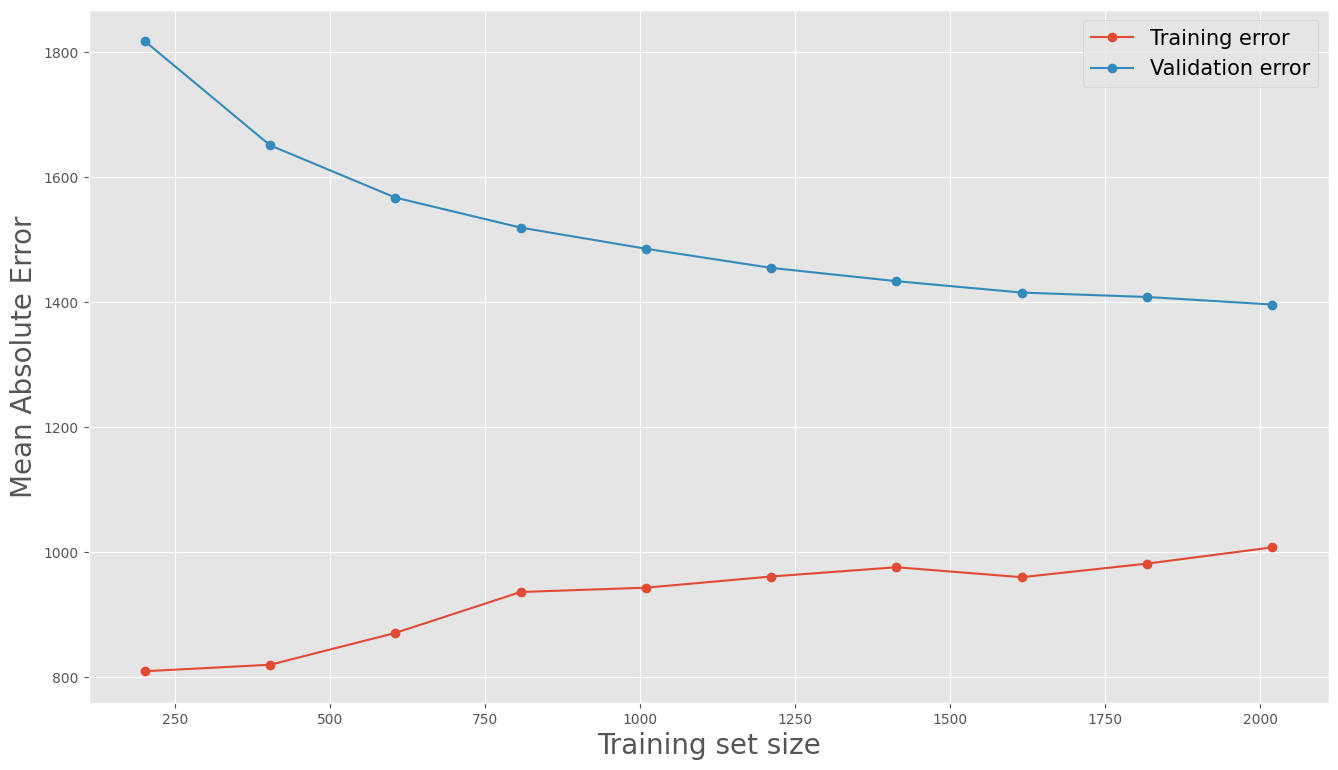

In [40]:
########### Plot Learning Curve ###########

plt.figure(figsize=(16, 9))
plt.plot(train_sizes, train_scores_mean, 'o-',  label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation error')
plt.xlabel('Training set size', fontsize = 20)
plt.ylabel('Mean Absolute Error', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.rc('xtick', labelsize='17')
plt.rc('ytick', labelsize='17')
plt.rc('axes', titlesize='15')
plt.show()

/tmp/ipykernel_1106/379550531.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


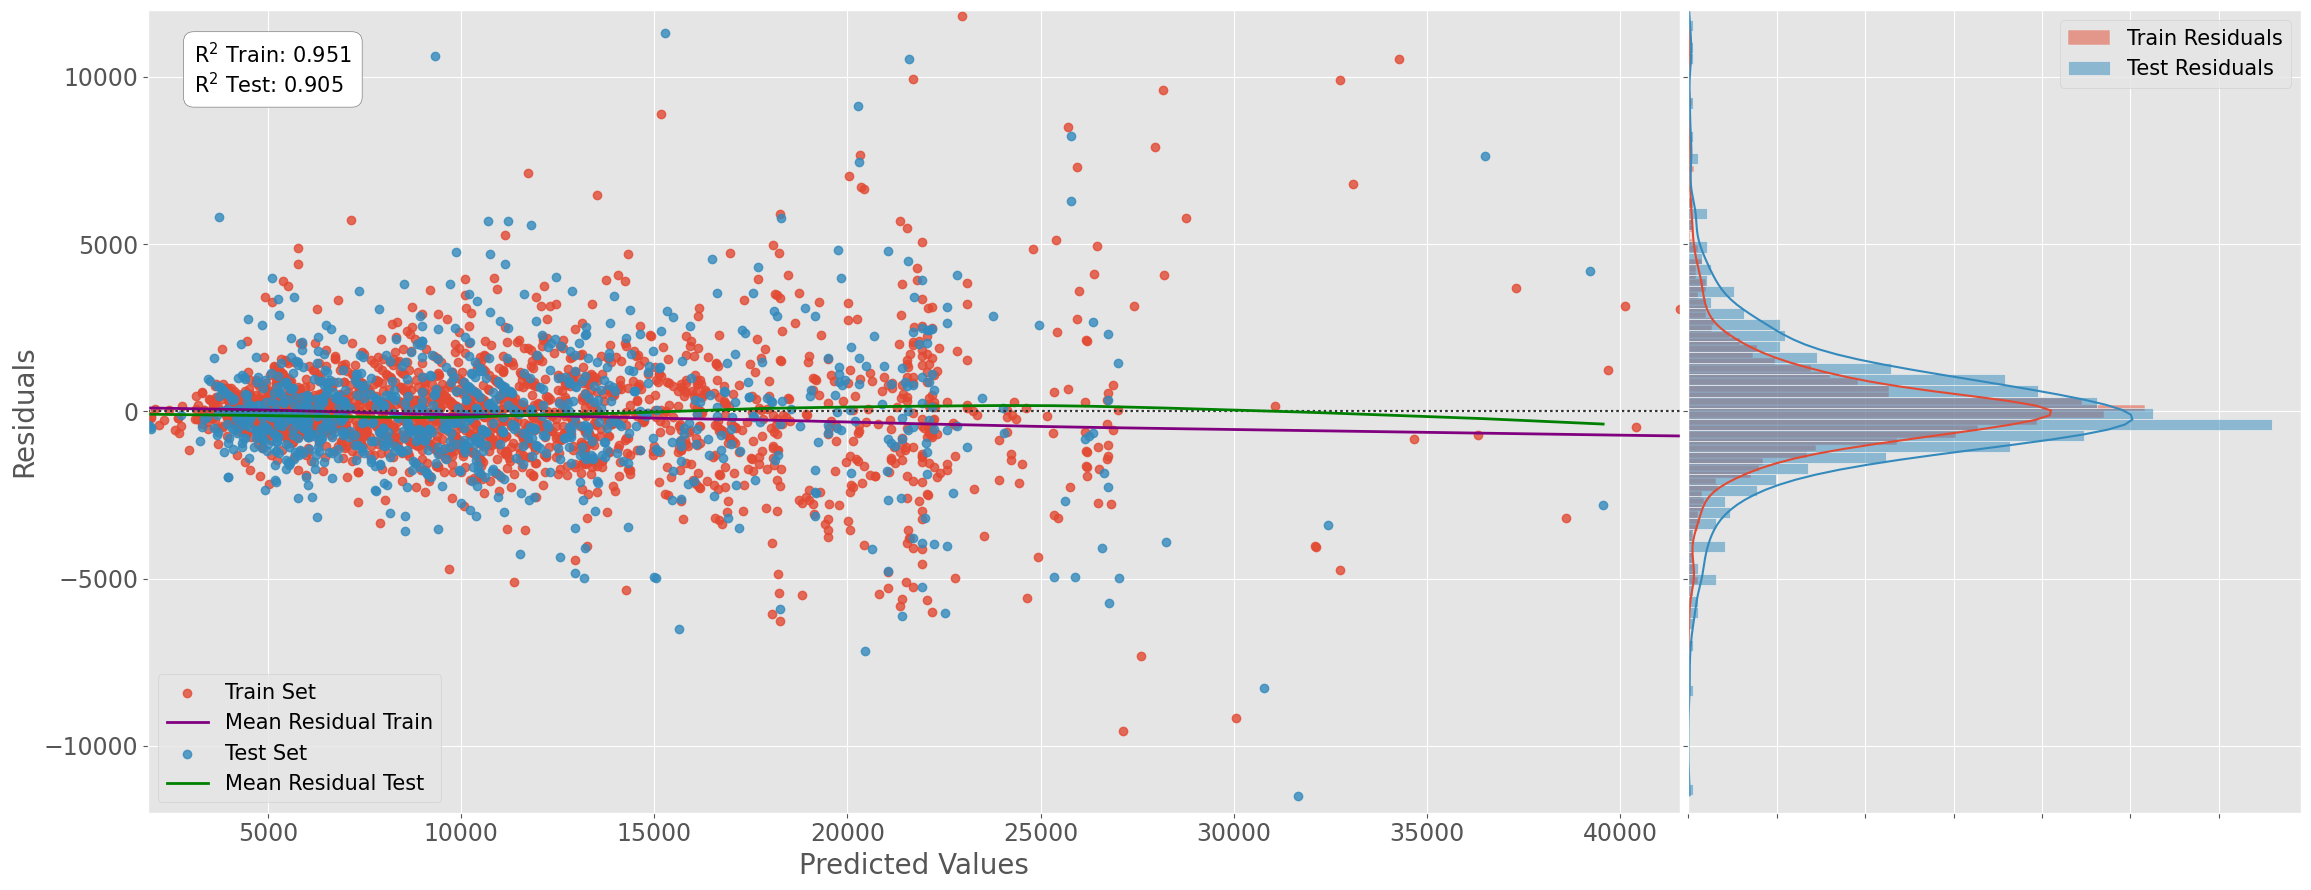

r2 train: 0.9506724082227527
r2 test: 0.9046977094330282


In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

########### Calculate Residuals ###########

residuals_test = y_test - y_pred_ens_test_inv
residuals_train = y_train - y_pred_ens_train_inv

r2train = r2_score(y_train_log, y_pred_ens_train)
r2test = r2_score(y_test_log, y_pred_ens_test)

########### Plot Residuals ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_ens_train_inv, y=residuals_train, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Train'}, label='Train Set')
sns.residplot(x= y_pred_ens_test_inv, y=residuals_test, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual Test'}, label='Test Set')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = residuals_train, kde=True,stat = 'percent',  label='Train Residuals', alpha=0.5, ax = ax_hist)
sns.histplot(y = residuals_test, kde=True, stat = 'percent', label='Test Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")
ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Train: {:.3f}'.format(r2train),
    r'R$^2$ Test: {:.3f}'.format(r2test),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

print("r2 train:", r2train)
print("r2 test:", r2test)

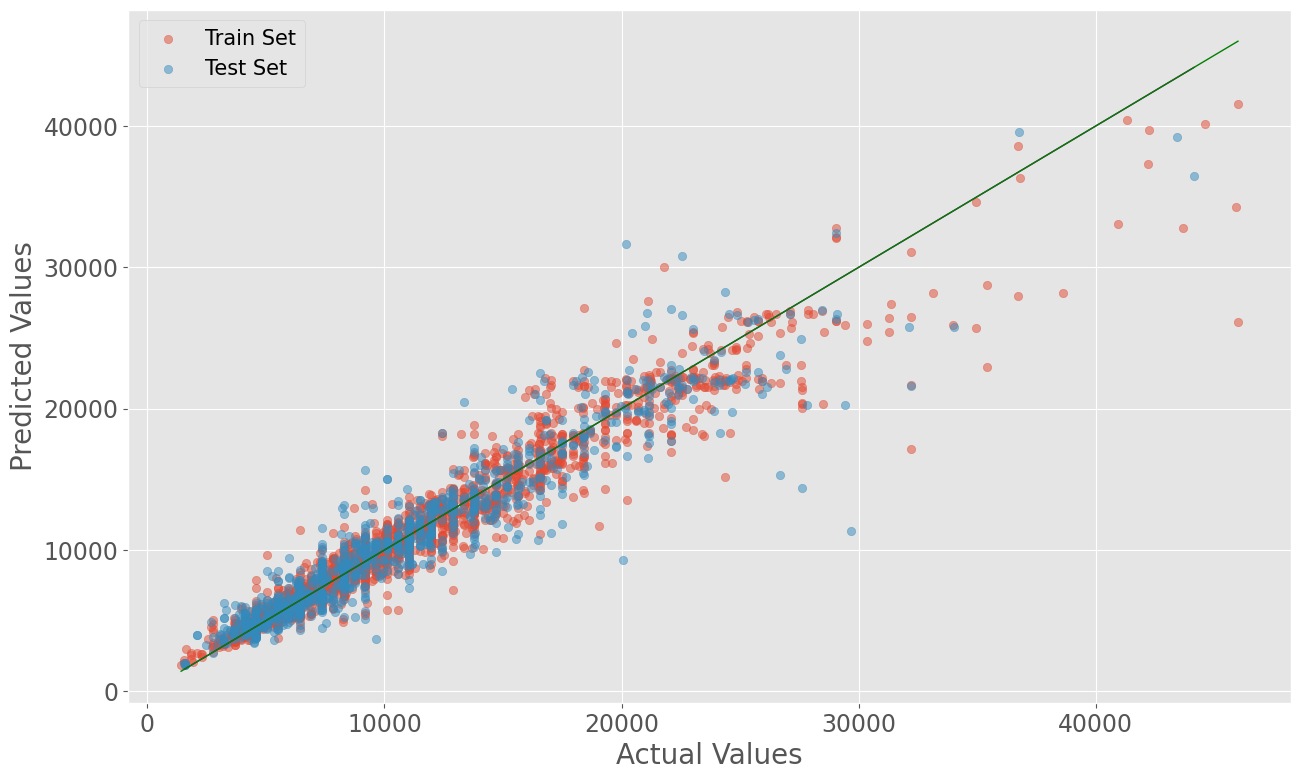

In [42]:
########### Plot Errors ###########

plt.figure(figsize=(15, 9))
plt.scatter(y_train, y_pred_ens_train_inv, alpha=0.5, label='Train Set')
plt.scatter(y_test, y_pred_ens_test_inv, alpha=0.5, label='Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'purple', linewidth=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'green',  linewidth=1)
plt.legend(loc='best', fontsize = 15)
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.show()

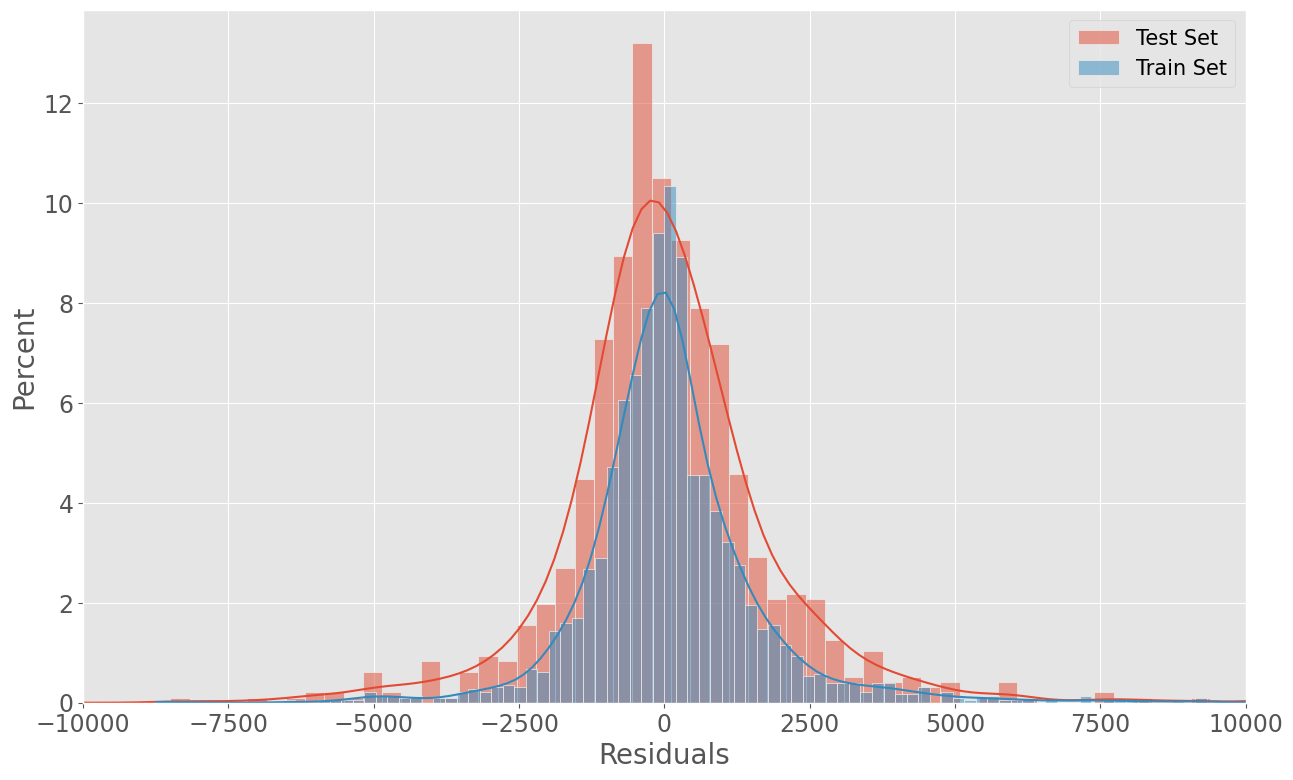

In [43]:
########### Plot Residuals ###########

plt.figure(figsize=(15, 9))
sns.histplot(residuals_test, alpha = 0.5, kde=True, stat='percent', label = 'Test Set')
sns.histplot(residuals_train, alpha = 0.5, kde=True, stat='percent', label = 'Train Set')
plt.legend(loc='best', fontsize = 15)
plt.xlim(-10000, 10000)
plt.xlabel('Residuals', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)

plt.show()

## **Alternative Method: KNN Regressor**

In [44]:
########### parameter grid ###########

param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 13],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'regressor__leaf_size': [20, 30, 40, 50],
    'regressor__p': [1, 2]
}

########### Initialise base model ###########

knn_model = KNeighborsRegressor(algorithm = 'brute')

########### Pipeline for base model ###########

model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('regressor', knn_model)
])

########### Random Search for best parameters ###########

random_search_knn = RandomizedSearchCV(estimator=model_knn, param_distributions=param_grid_knn, n_iter=200, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fit for Search ###########

random_search_knn.fit(X_train, y_train_log)

########### Set Parameters ###########

best_params_knn = random_search_knn.best_params_
best_knn = model_knn.set_params(**best_params_knn)

start = time.time()
best_knn.fit(X_train, y_train_log) ########### Fit model
stop = time.time()

########### Predict Prices ###########

y_pred_knn = best_knn.predict(X_test)

y_pred_knn_inv = target_transformer_log.inverse_transform(y_pred_knn.reshape(-1, 1)).reshape(-1)

########### Cross Validation with RMSE ###########

cv_scores_knn_rmsle = cross_val_score(best_knn, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for KNN: ")
print(f"Best parameters: {best_params_knn}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_knn_rmsle}")
print(f"Mean RMSE: {-cv_scores_knn_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_knn_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_knn_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_knn_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_knn))
print('Training Time:', stop-start)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regresso

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbor

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, r

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regresso

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, re

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=9, regres

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_nei

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbor

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=7, regress

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_siz

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regres

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regress

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_nei

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, 

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_ne

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7,

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_ne

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=13, 

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_n

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neigh

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_ne

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, r

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor_

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neig

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbor

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neig

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en


[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.1s[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s

[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neig

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbo

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbor

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=9, 

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_nei

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=1

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.1s

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_ne

/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/envs/toolbox/lib/python3.12/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/home/tabea/.local/mambaforge/en

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20,

Metrics for KNN: 

Best parameters: {'regressor__weights': 'distance', 'regressor__p': 1, 'regressor__n_neighbors': 9, 'regressor__leaf_size': 30, 'regressor__algorithm': 'brute'}

Cross-Validation RMSE Scores: [2377.92342683 3591.76083688 2403.09033469 2326.03507088 2490.74604856 2172.2016863  2545.23792788 2467.29637138 2809.09758649 1971.88264244]

Mean RMSE: 2515.5271932342266

Standard Deviation of RMSE: 415.83547059024744

MSE: 5167510.12

MAE: **1418.12**

R2-Score: **0.877**

Training Time: 0.015s

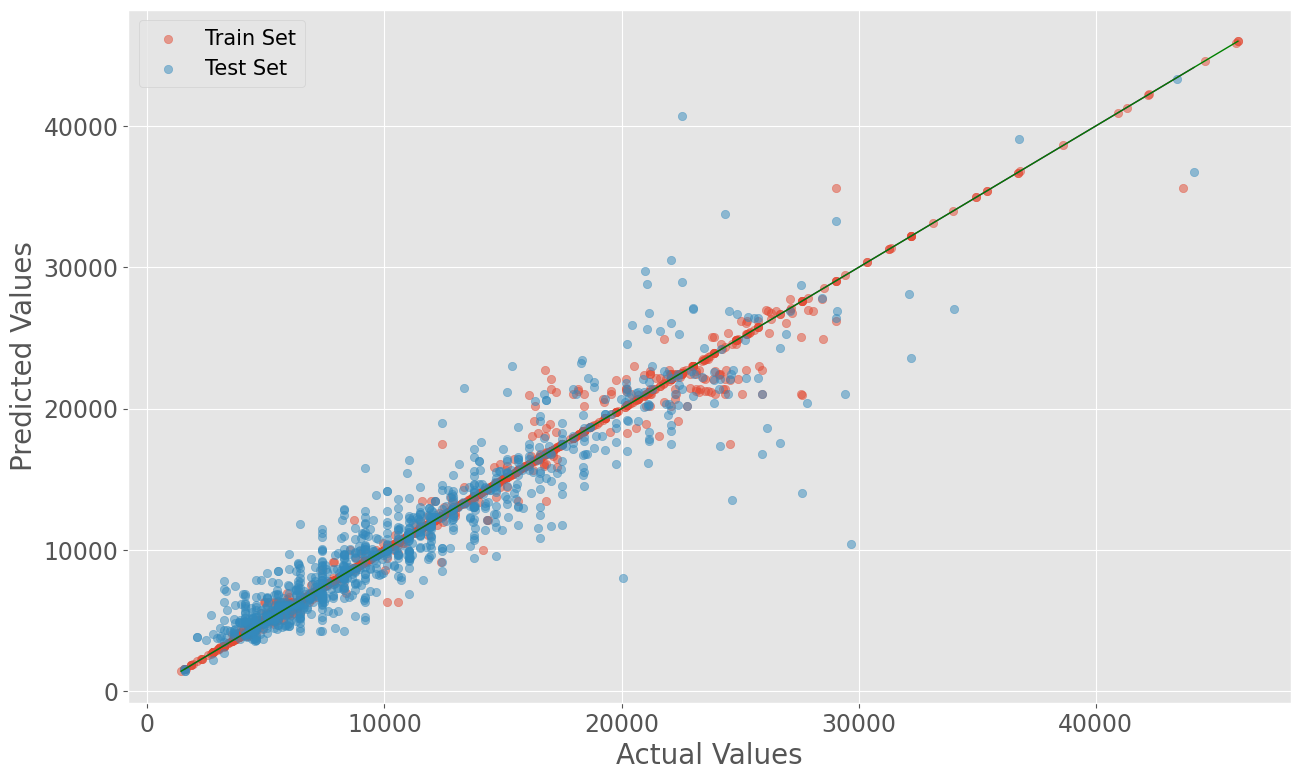

MAE: 1418.12
R2-Score Test: 0.88
R2-Score Train: 0.99


In [45]:
########### Predict Prices for testing and training ###########

y_pred_knn_test = best_knn.predict(X_test)
y_pred_knn_test_inv = target_transformer_log.inverse_transform(y_pred_knn_test.reshape(-1, 1)).reshape(-1)
y_pred_knn_train = best_knn.predict(X_train)
y_pred_knn_train_inv = target_transformer_log.inverse_transform(y_pred_knn_train.reshape(-1, 1)).reshape(-1)

########### Plot Errors ###########

plt.figure(figsize=(15, 9))
plt.scatter(y_train, y_pred_knn_train_inv, alpha=0.5, label='Train Set')
plt.scatter(y_test, y_pred_knn_test_inv, alpha=0.5, label='Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'purple', linewidth=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'green',  linewidth=1)
plt.legend(loc = 'best', fontsize = 15)
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.show()
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_knn_test_inv))
print('R2-Score Test: %.2f' % r2_score(y_test_log, y_pred_knn_test))
print('R2-Score Train: %.2f' % r2_score(y_train_log, y_pred_knn_train))

MAE: 1418.09
R2-Score Test: 0.88
R2-Score Train: 0.99

/tmp/ipykernel_1106/4072533479.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


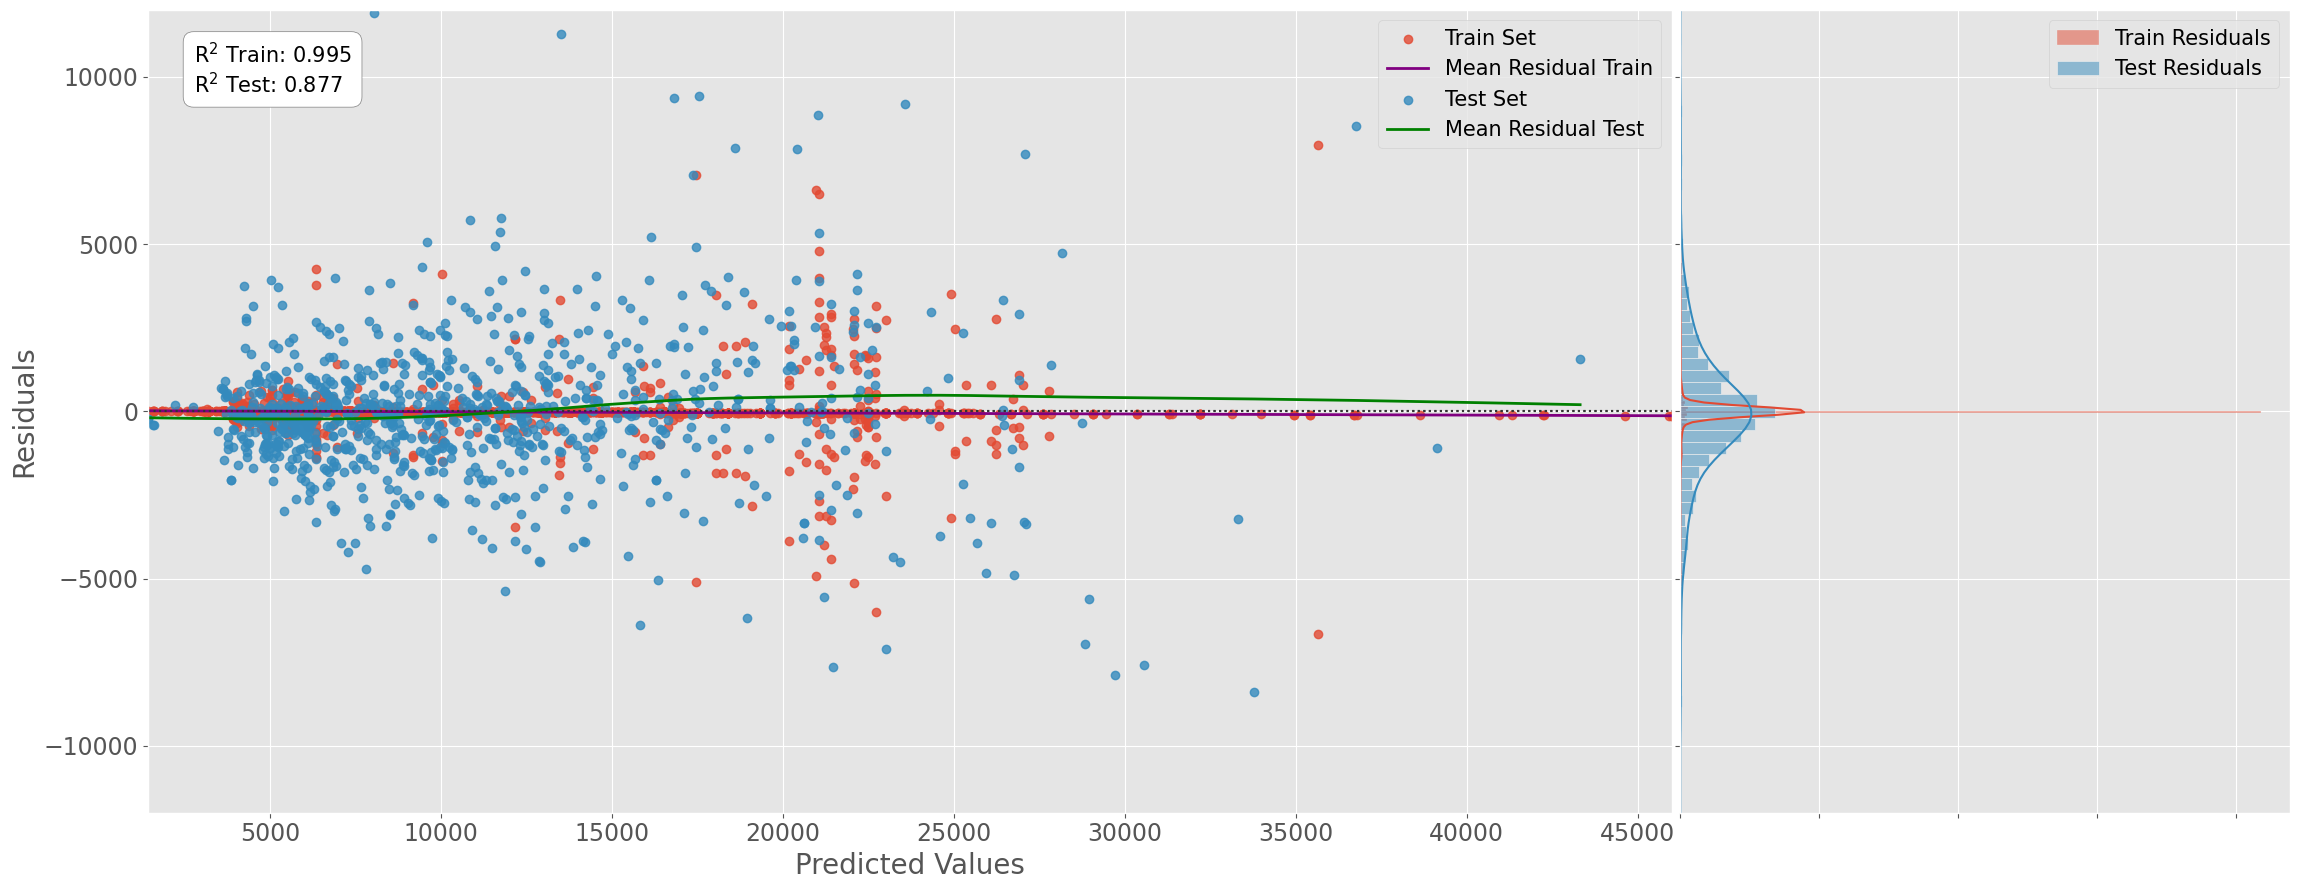

r2 train: 0.9947258408580637
r2 test: 0.8771690771583285


In [46]:
########### r2 scores ###########

r2trainknn = r2_score(y_train_log, y_pred_knn_train)
r2testknn = r2_score(y_test_log, y_pred_knn_test)

########### Residuals ###########

residuals_test_knn = y_test - y_pred_knn_test_inv
residuals_train_knn = y_train - y_pred_knn_train_inv

########### Residuals Plot ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_knn_train_inv, y=residuals_train_knn, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Train'}, label='Train Set')
sns.residplot(x= y_pred_knn_test_inv, y=residuals_test_knn, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual Test'}, label='Test Set')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = y_train - np.round(y_pred_knn_train_inv,10), kde=True,stat = 'percent',  label='Train Residuals', alpha=0.5, ax = ax_hist, bins = 200)
sns.histplot(y = residuals_test_knn, kde=True, stat = 'percent', label='Test Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")
ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Train: {:.3f}'.format(r2trainknn),
    r'R$^2$ Test: {:.3f}'.format(r2testknn),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

print("r2 train:", r2trainknn)
print("r2 test:", r2testknn)

/tmp/ipykernel_1106/321885824.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


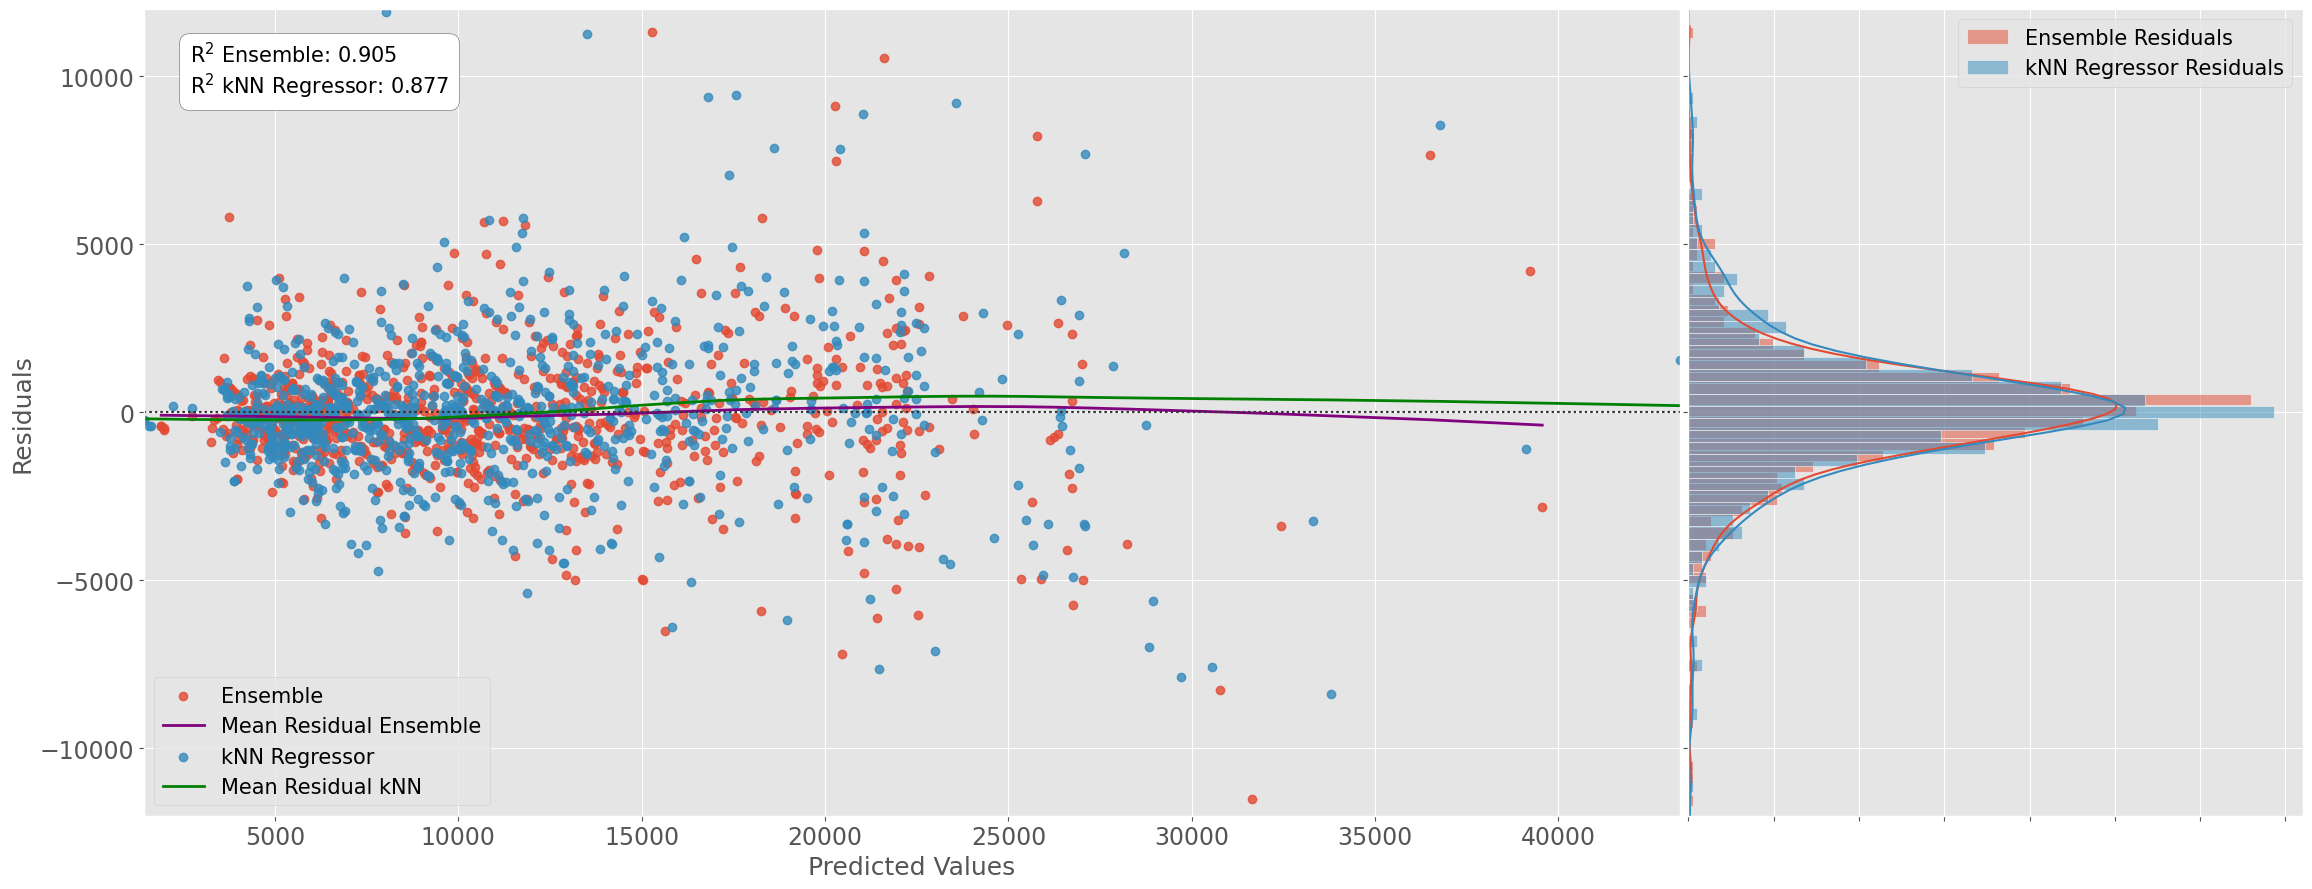

In [66]:
########### Plot Resiudals ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_ens_test_inv, y=residuals_test, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Ensemble'}, label='Ensemble')
sns.residplot(x= y_pred_knn_test_inv, y=residuals_test_knn, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual kNN'}, label='kNN Regressor')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = -residuals_test, kde=True,stat = 'percent',  label='Ensemble Residuals', alpha=0.5, ax = ax_hist)
sns.histplot(y =-residuals_test_knn, kde=True, stat = 'percent', label='kNN Regressor Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")

ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Ensemble: {:.3f}'.format(r2test),
    r'R$^2$ kNN Regressor: {:.3f}'.format(r2testknn),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

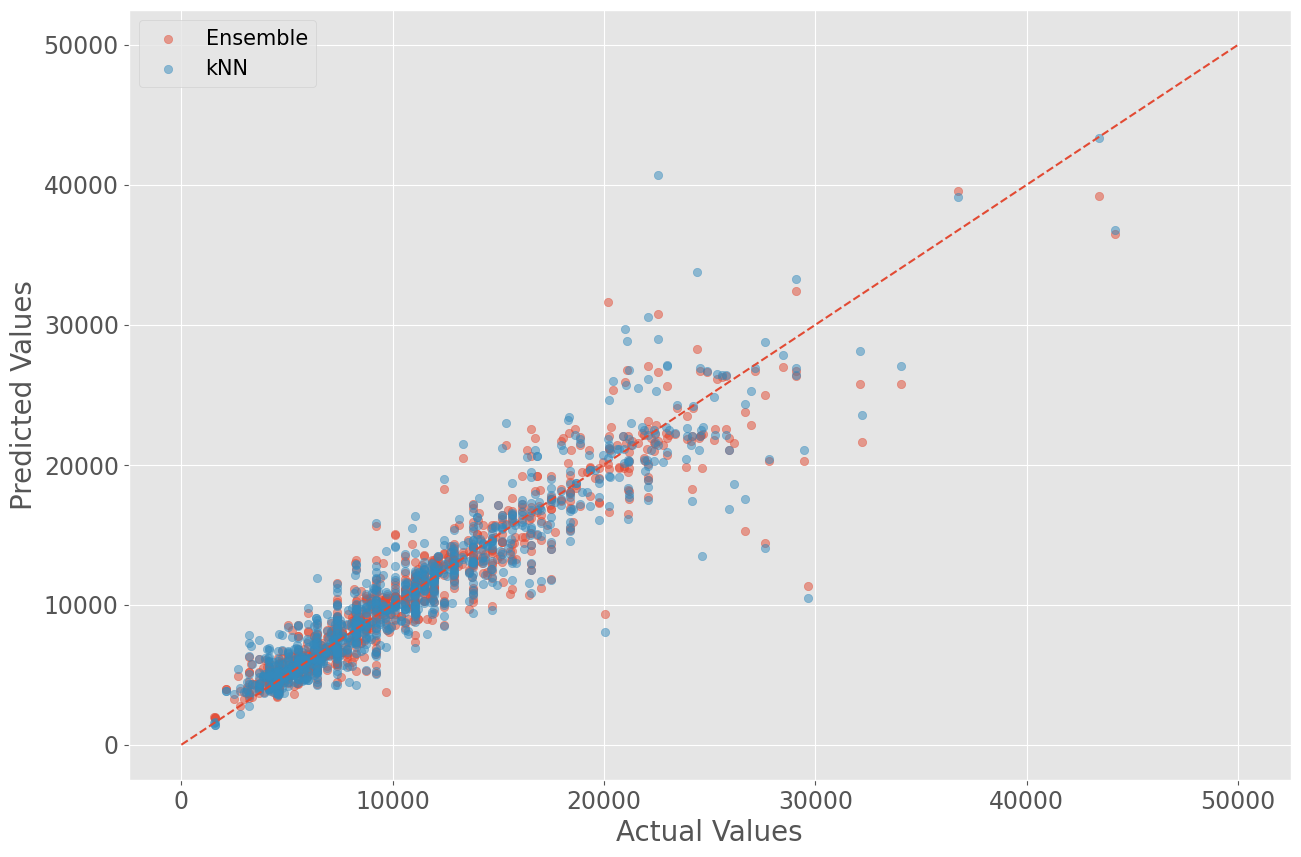

In [48]:
########### Predicted vs actual ###########

plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ens_test_inv, alpha=0.5, label='Ensemble')
plt.scatter(y_test, y_pred_knn_test_inv, alpha=0.5, label='kNN')
plt.plot([0, 50000], [0, 50000], '--')
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.show()

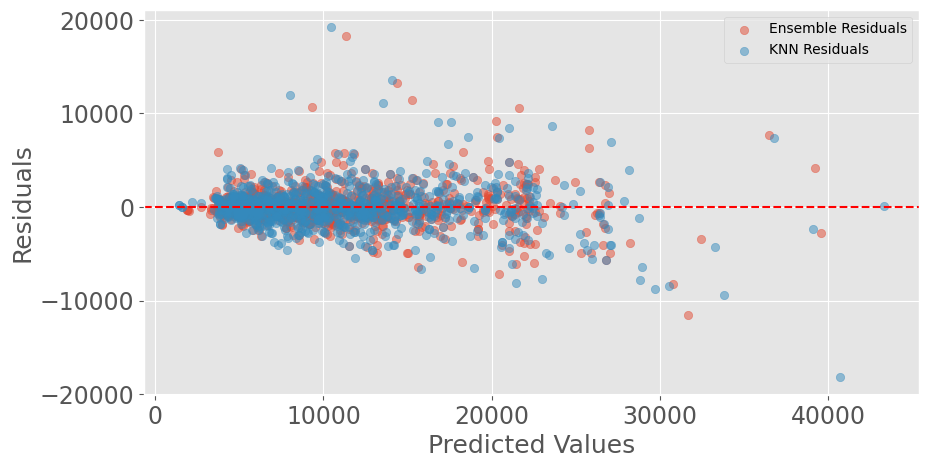

In [49]:
########### Plot Residuals ###########

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_ens_test_inv, residuals_test, alpha=0.5, label='Ensemble Residuals')
plt.scatter(y_pred_knn_test_inv, residuals_test_knn, alpha=0.5, label='KNN Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

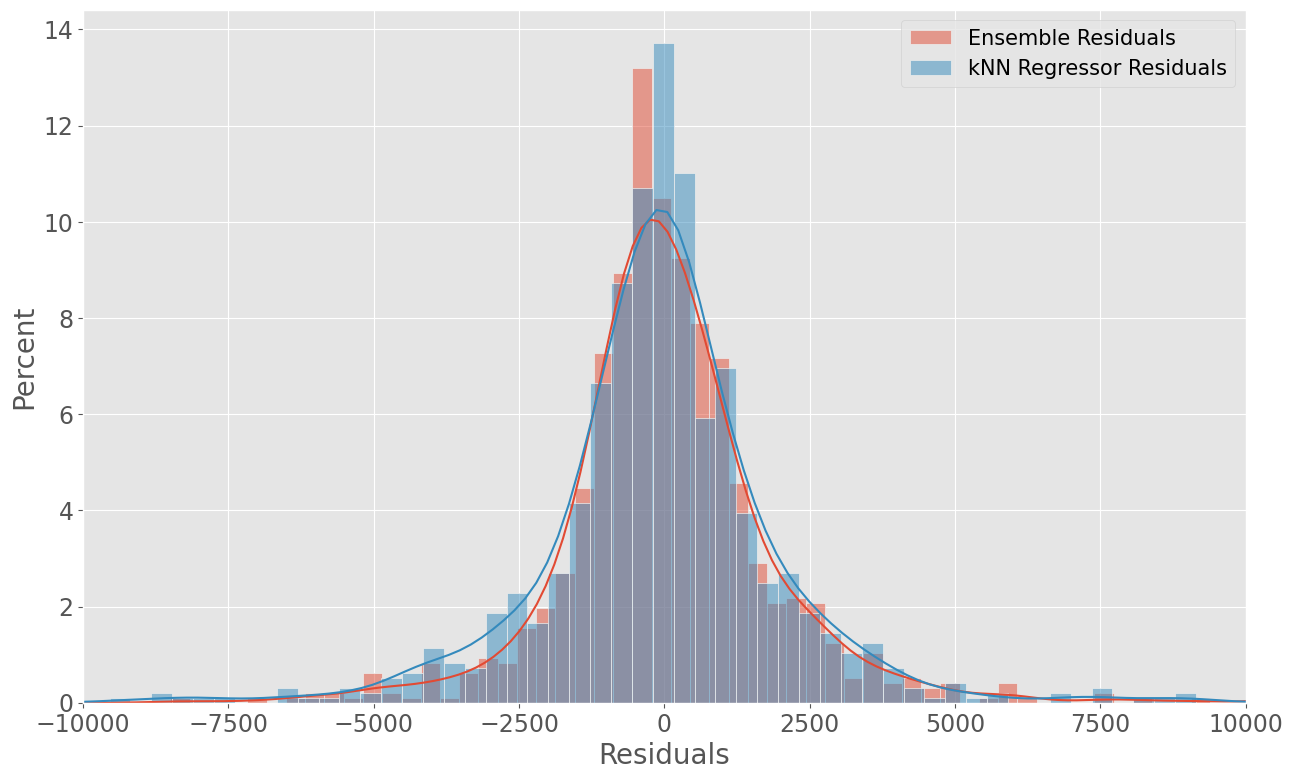

In [50]:
########### Plot Residuals ###########

plt.figure(figsize=(15, 9))
sns.histplot(residuals_test, kde=True,stat = 'percent',  label='Ensemble Residuals', alpha=0.5)
sns.histplot(residuals_test_knn, kde=True, stat = 'percent', label='kNN Regressor Residuals', alpha=0.5)
plt.xlim(-10000, 10000)
plt.xlabel('Residuals', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)

plt.legend(loc='best', fontsize = 15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


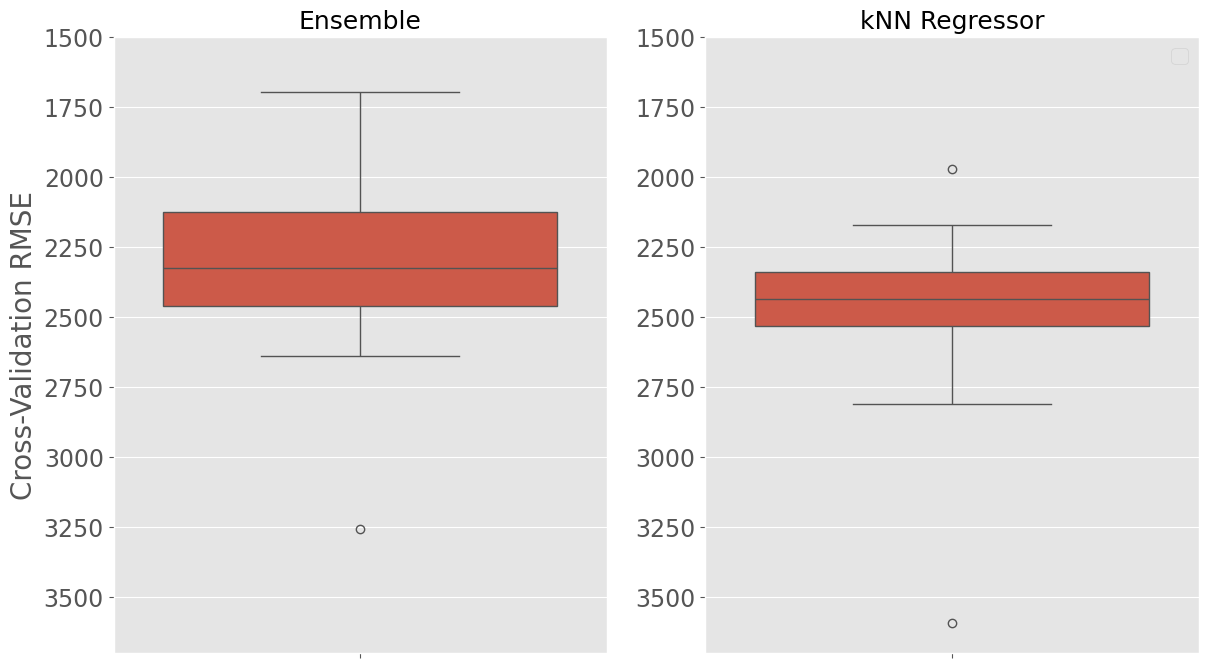

In [51]:
########### Plot Box Plot for Cross Vals ###########

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.boxplot(y=np.abs(cv_scores_ensemble_rmse),ax = axes[0])
sns.boxplot(y=np.abs(cv_scores_knn_rmsle),ax = axes[1])
axes[0].set_title('Ensemble', fontsize = 18)
axes[1].set_title('kNN Regressor', fontsize = 18)

axes[0].set_ylim(3700, 1500)
axes[1].set_ylim(3700, 1500)
axes[0].set_ylabel('Cross-Validation RMSE', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.show()

In [596]:
########### Predict prices for whole dataset and visualise ###########

df_True_pred = X_test
df_True_pred['True Prices [€]'] = y_test
df_True_pred['Predicted Prices [€]'] = y_pred_ens_test_inv
df_True_pred['Difference [€]'] = np.abs(residuals_test)
df_True_pred.rename = residuals_test
df_True_pred = df_True_pred[['Brand', 'Bike', 'Category', 'Power [hp]', 'Displacement [ccm]', 'Torque [Nm]', 'Mileage [km]', 'Age [a]', 'True Prices [€]', 'Predicted Prices [€]', 'Difference [€]']]
df_True_pred.sort_values(by = 'Difference [€]', ascending=False).head(10).style.format({'Power [hp]': "{:,.0f}", 'Displacement [ccm]': "{:,.0f}", 'Torque [Nm]': "{:,.0f}", 'Mileage [km]': "{:,.0f}", 'True Prices [€]': "{:,.2f} €", 'Predicted Prices [€]': "{:,.2f} €", 'Difference [€]': "{:,.2f} €"})

In [41]:
########### For Variable Importance ###########

param_grid_xgbtree = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__learning_rate': [0.03, 0.05, 0.08],
    'regressor__max_depth': [4, 5, 6],
    'regressor__min_child_weight': [2, 3, 4],
    'regressor__subsample': [0.4, 0.6, 0.7],
    'regressor__colsample_bytree': [0.3, 0.6, 0.8],
    'regressor__gamma': [0, 0.1, 0.3, 0.5],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1]
}


extra_tree_model2 = ExtraTreesRegressor()

model_extratree2 = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', extra_tree_model2)
])

model_extratree2.fit(X_train, y_train_log.ravel())

preprocessor_std.fit(X_train)

num_features_out2 = preprocessor_std.transformers_[0][1].named_steps['scaler'].get_feature_names_out(num_features)
cat_features_out2 = preprocessor_std.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features_)
feature_names2 = np.concatenate([num_features_out2, cat_features_out2])
selected_features2 = model_extratree2.named_steps['feature_selection'].get_support()
selected_feature_names2 = feature_names2[selected_features2]

y_pred_xgbtree2 = model_extratree2.predict(X_test)

y_pred_xgbtree2_inv = target_transformer_log.inverse_transform(y_pred_xgbtree2.reshape(-1, 1)).reshape(-1)

cv_scores_xgbtree2_rmsle = cross_val_score(model_extratree2, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

print("Metrics for XGBoost Tree: ")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgbtree2_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgbtree2_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgbtree2_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgbtree2_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgbtree2_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgbtree2))

Metrics for XGBoost Tree: 
Cross-Validation RMSE Scores: [2364.81879562 3699.85508907 2491.28925866 2355.25288936 3227.46425371
 2295.54191006 2759.18474374 2679.47129287 3001.63216303 1986.96805689]
Mean RMSE: 2686.1478453016175
Standard Deviation of RMSE: 481.42229089437313
MSE: 5251045.65
MAE: 1446.82
R2-Score: 0.881


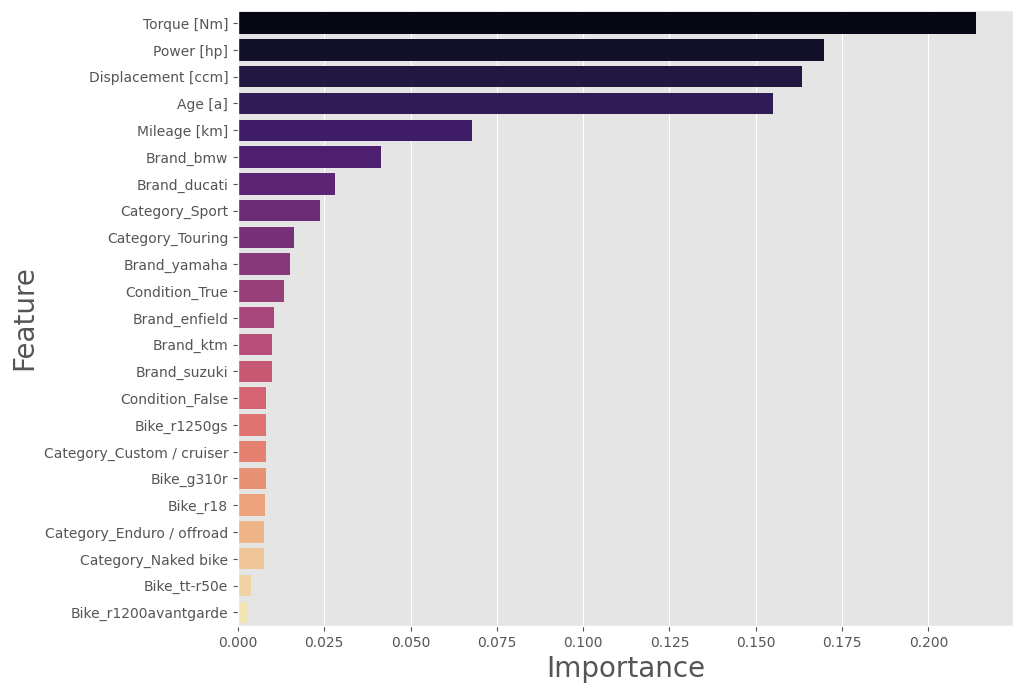

In [42]:
########### Plot Importance ###########

xgb_model3 = model_extratree2.named_steps['regressor']

importances2 = xgb_model3.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names2,
    'importance': importances2
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='magma', hue = 'feature')
plt.xlabel('Importance', fontsize = 20)
plt.ylabel('Feature', fontsize = 20)
plt.show()